In [ ]:
pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 73.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=2dd5bb35966dbcf4191061bb165273adf99b861d8f09038ad082be64571a07bb
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [ ]:
from google.colab import drive
import pandas as pd
from pretty_midi import PrettyMIDI
import os

In [ ]:
drive.mount('/content/drive')
dp = 'drive/MyDrive/datasets/'

Mounted at /content/drive


In [ ]:
records = []

data_dir = dp + 'music_dataset'
for composer in os.listdir(data_dir):
    composer_dir = os.path.join(data_dir, composer)
    if not os.path.isdir(composer_dir):
        continue
    for fname in os.listdir(composer_dir):
        if not fname.lower().endswith(('.mid', '.midi')):
            continue
        path = os.path.join(composer_dir, fname)
        try:
            pm = PrettyMIDI(path)
            # sum of all note-on events across instruments
            token_count = sum(len(inst.notes) for inst in pm.instruments)
        except Exception as e:
            print(f"⚠️ Error parsing {path}: {e}")
            token_count = None
        records.append({
            'composer': composer,
            'file': fname,
            'token_count': token_count
        })

# 3) Make a DataFrame and inspect
df = pd.DataFrame(records)
print(df.head(10))
print("\nToken-count summary:")
print(df['token_count'].describe())

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


⚠️ Error parsing drive/MyDrive/datasets/music_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
  composer                                   file  token_count
0   Mozart  K626 Requiem 01 Introitus & Kyrie.mid       9819.0
1   Mozart            A piece for Piano,K.176.mid        881.0
2   Mozart                  Sonatina n21 3mov.mid        996.0
3   Mozart         K495 Horn Concerto n4 2mov.mid       1830.0
4   Mozart          K626 Requiem 12 agnus dei.mid      10720.0
5   Mozart          K317 Coronation Mass 4mov.mid       1186.0
6   Mozart              K618 Ave Verum Corpus.mid        465.0
7   Mozart         K495 Horn Concerto n4 3mov.mid       4261.0
8   Mozart    K546 Adagio & Fugue for Strings.mid       4973.0
9   Mozart              K401 Fuga in G minor .mid       1535.0

Token-count summary:
count      490.000000
mean      3532.689796
std       4166.959984
min         90.000000
25%       1019.500000
50%       1968.000000
75%       4421.750000
max

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ── 0) Load your token‐counts DataFrame ─────────────────────────────
# Either re-run the pretty_midi code to build df, or load from CSV if you saved it:
# df = pd.read_csv('token_counts.csv')
# It must have at least: ['composer','file','token_count']
# For example:
#    composer                 file  token_count
# 0      Bach    baroque_fugue.mid         2345
# 1   Mozart  classical_sonata.mid         1200
# ...

# ── 1) Define length‐bins ────────────────────────────────────────────
bins   = [0, 1000, 4000, df['token_count'].max()]
labels = ['short', 'medium', 'long']
df['length_bin'] = pd.cut(df['token_count'], bins=bins, labels=labels, include_lowest=True)

# ── 2) Create combined stratification label ─────────────────────────
df['stratify_label'] = df['composer'] + '_' + df['length_bin'].astype(str)

# ── 3) Split 70% train / 30% temp ───────────────────────────────────
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    stratify=df['stratify_label']
)

# ── 4) Split temp 50/50 into 15% val & 15% test ──────────────────────
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df['stratify_label']
)

# ── 5) (Optional) Quick balance check ────────────────────────────────
print("Train composer-length bins:\n", train_df['stratify_label'].value_counts())
print("\nVal composer-length bins:\n",   val_df['stratify_label'].value_counts())
print("\nTest composer-length bins:\n",  test_df['stratify_label'].value_counts())

# ── 6) Save splits for reproducibility ───────────────────────────────
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv',     index=False)
test_df.to_csv('test.csv',    index=False)

print("\nSaved train.csv, val.csv, test.csv.")


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ── (Re)load your DataFrame ─────────────────────────────────────────
# df must have: ['composer', 'file', 'token_count']
# And after binning:
# df['length_bin'] = pd.cut(...)
# df['stratify_label'] = df['composer'] + '_' + df['length_bin'].astype(str)

# ── 0) Identify rare groups ─────────────────────────────────────────
counts = df['stratify_label'].value_counts()
print(df['stratify_label'])
rare_labels = counts[counts < 2].index.tolist()

# ── 1) Move rare groups into 'medium' ──────────────────────────────
df.loc[df['stratify_label'].isin(rare_labels), 'length_bin'] = 'medium'

# ── 2) Recompute stratify_label ────────────────────────────────────
df['stratify_label'] = df['composer'] + '_' + df['length_bin'].astype(str)

# ── 3) Now split safely ─────────────────────────────────────────────
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    stratify=df['stratify_label']
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df['stratify_label']
)

# ── 4) Quick sanity check ───────────────────────────────────────────
print("After adjustment, min group size:",
      df['stratify_label'].value_counts().min())
print("Train set composition:\n",
      train_df['stratify_label'].value_counts())

# ── 5) Persist splits ───────────────────────────────────────────────
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv',     index=False)
test_df.to_csv('test.csv',    index=False)


0        Mozart_long
1       Mozart_short
2       Mozart_short
3      Mozart_medium
4        Mozart_long
           ...      
486       Bach_short
487       Bach_short
488      Bach_medium
489       Bach_short
490       Bach_short
Name: stratify_label, Length: 491, dtype: object
After adjustment, min group size: 18
Train set composition:
 stratify_label
Chopin_medium       59
Beethoven_medium    39
Bach_medium         38
Beethoven_long      34
Bach_short          28
Mozart_medium       26
Mozart_long         25
Bach_long           25
Chopin_short        22
Beethoven_short     20
Chopin_long         14
Mozart_short        13
Name: count, dtype: int64


In [ ]:
import mido
from pretty_midi import PrettyMIDI
from mido.midifiles.meta import KeySignatureError

def safe_pretty_midi(path):
    try:
        return PrettyMIDI(path)
    except KeySignatureError:
        # Load with mido so we can filter the offending meta messages
        mid = mido.MidiFile(path)
        cleaned_tracks = [
            [msg for msg in track if msg.type != 'key_signature']
            for track in mid.tracks
        ]
        mid.tracks = cleaned_tracks
        # Now re-wrap in PrettyMIDI
        return PrettyMIDI(mid)



In [ ]:
import os
import numpy as np
import pandas as pd
import pretty_midi
DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'  # adjust as needed

# 1) Make output dirs
for split in ['train', 'val', 'test']:
    os.makedirs(f'processed/{split}/lstm', exist_ok=True)
    os.makedirs(f'processed/{split}/cnn',  exist_ok=True)

# 2) Load splits
splits = {
    split: pd.read_csv(f'/content/{split}.csv')
    for split in ['train','val','test']
}

# 3) Define processors
def extract_sequence(path):
    pm = pretty_midi.PrettyMIDI(path)
    events = []
    for inst in pm.instruments:
        for n in inst.notes:
            events.append((n.start, n.pitch, n.end - n.start))
    events.sort(key=lambda x: x[0])
    return [(pitch, duration) for _, pitch, duration in events]

def extract_piano_roll(path, fs=20):
    pm = pretty_midi.PrettyMIDI(path)
    pr = pm.get_piano_roll(fs=fs)
    return (pr > 0).astype(np.float32)

import os, numpy as np, pretty_midi

for split, df in splits.items():
    os.makedirs(f'processed/{split}/lstm', exist_ok=True)
    os.makedirs(f'processed/{split}/cnn',  exist_ok=True)

    for _, row in df.iterrows():
        composer = row['composer']               # e.g. "Chopin"
        fname    = row['file']                   # e.g. "Nocturne No.15.mid"
        infile   = os.path.join(DATA_ROOT, composer, fname)
        if not os.path.exists(infile):
            print("Missing file:", infile)
            continue

        # LSTM sequence
        pm = safe_pretty_midi(infile)
        events = sorted(
          [(n.start, n.pitch, n.end-n.start) for inst in pm.instruments for n in inst.notes],
          key=lambda x: x[0]
        )
        seq = [(pitch,dur) for _,pitch,dur in events]
        np.save(f'processed/{split}/lstm/{os.path.splitext(fname)[0]}.npy', np.array(seq, dtype=object))

        # CNN piano-roll
        pr = pm.get_piano_roll(fs=20) > 0
        np.save(f'processed/{split}/cnn/{os.path.splitext(fname)[0]}.npy', pr.astype(np.float32))



/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


KeySignatureError: Could not decode key with 3 flats and mode 255

In [ ]:
import os
import numpy as np
import pandas as pd
import pretty_midi
from mido.midifiles.meta import KeySignatureError

DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'

def load_pm(path):
    """Try PrettyMIDI; on KeySignatureError, skip the file."""
    try:
        return pretty_midi.PrettyMIDI(path)
    except KeySignatureError:
        print("⚠️ Skipping (bad key sig):", path)
        return None

for split in ['train','val','test']:
    df = pd.read_csv(f'/content/{split}.csv')
    os.makedirs(f'processed/{split}/lstm', exist_ok=True)
    os.makedirs(f'processed/{split}/cnn',  exist_ok=True)

    for _, row in df.iterrows():
        composer = row['composer']
        fname    = row['file']
        path     = os.path.join(DATA_ROOT, composer, fname)
        pm = load_pm(path)
        if pm is None:
            continue  # skip this one bad MIDI

        # LSTM tokens
        events = sorted(
            [(n.start,n.pitch,n.end-n.start)
             for inst in pm.instruments for n in inst.notes],
            key=lambda x: x[0]
        )
        seq = [(p,d) for _,p,d in events]
        np.save(f'processed/{split}/lstm/{os.path.splitext(fname)[0]}.npy',
                np.array(seq, dtype=object))

        # CNN piano-roll
        pr = pm.get_piano_roll(fs=20) > 0
        np.save(f'processed/{split}/cnn/{os.path.splitext(fname)[0]}.npy',
                pr.astype(np.float32))


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


⚠️ Skipping (bad key sig): /content/drive/MyDrive/datasets/music_dataset/Beethoven/Anhang 14-3.mid


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
import numpy as np

# LSTM sample
lstm_seq = np.load('/content/processed/train/lstm/19 Polish Songs, for Solo Voice and Piano accomplements, No.11.npy', allow_pickle=True)
print("LSTM sequence shape:", lstm_seq.shape)
print("First tokens:", lstm_seq[:5])

# CNN sample
pr = np.load('processed/train/cnn/some_file.npy')
print("Piano-roll shape:", pr.shape)


LSTM sequence shape: (669, 2)
First tokens: [[57 np.float64(0.47984720000000003)]
 [50 np.float64(0.47984720000000003)]
 [62 np.float64(0.47984720000000003)]
 [65 np.float64(0.47984720000000003)]
 [69 np.float64(0.47984720000000003)]]


FileNotFoundError: [Errno 2] No such file or directory: 'processed/train/cnn/some_file.npy'

In [ ]:
import os
import numpy as np
import pandas as pd

MAX_LEN = 1000
label_map = {'Bach':0, 'Beethoven':1, 'Chopin':2, 'Mozart':3}
DATA_ROOT = '/content/music_dataset/music_dataset'

def load_lstm_data(split):
    df = pd.read_csv(f'{split}.csv')
    X, y = [], []
    for _, row in df.iterrows():
        composer = row['composer']
        fname    = row['file']
        npy_path = f'processed/{split}/lstm/{os.path.splitext(fname)[0]}.npy'
        if not os.path.exists(npy_path):
            # Skip files we couldn’t preprocess
            continue

        # Load and pad/truncate as before
        seq = np.load(npy_path, allow_pickle=True).tolist()
        seq = np.array(seq, dtype=np.float32)
        L = seq.shape[0]
        if L >= MAX_LEN:
            seq = seq[:MAX_LEN]
        else:
            pad = np.zeros((MAX_LEN - L, 2), dtype=np.float32)
            seq = np.vstack([seq, pad])

        X.append(seq)
        y.append(label_map[composer])

    if not X:
        raise RuntimeError(f"No LSTM data found for split='{split}'")

    return np.stack(X, axis=0), np.array(y, dtype=np.int32)

# Then call:
X_train, y_train = load_lstm_data('train')
X_val,   y_val   = load_lstm_data('val')


In [ ]:
import tensorflow as tf

# LSTM dataset
train_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_train, y_train))
      .shuffle(buffer_size=1024)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_val, y_val))
      .batch(32)
      .prefetch(tf.data.AUTOTUNE)
)



In [ ]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0., input_shape=(1000, 2)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(4, activation='softmax')  # four composers
])

model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from collections import Counter


# Compute weights from your y_train array
counts = Counter(y_train)
total = sum(counts.values())
class_weight = {cls: total/(4*counts[cls]) for cls in counts}

# Retrain with these weights
history = model_lstm.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weight,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4305 - loss: 1.2394 - val_accuracy: 0.2568 - val_loss: 1.3751
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.3676 - loss: 1.2708 - val_accuracy: 0.4324 - val_loss: 1.2675
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3958 - loss: 1.2495 - val_accuracy: 0.3514 - val_loss: 1.2841
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3795 - loss: 1.2321 - val_accuracy: 0.2973 - val_loss: 1.3489
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3987 - loss: 1.2513 - val_accuracy: 0.3649 - val_loss: 1.2985
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3878 - loss: 1.2462 - val_accuracy: 0.2973 - val_loss: 1.3655
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3254 - loss: 1.2827 - val_accuracy: 0.3784 - val_loss: 1.3495


In [ ]:
WINDOW = 200    # number of tokens per snippet
STRIDE = 100    # how far windows advance each time
import os, numpy as np, pandas as pd

MAX_LEN = WINDOW
label_map = {'Bach':0, 'Beethoven':1, 'Chopin':2, 'Mozart':3}

def load_lstm_windows(split):
    df = pd.read_csv(f'{split}.csv')
    X, y = [], []

    for _, row in df.iterrows():
        composer = row['composer']
        fname    = row['file']
        arr_path = f'processed/{split}/lstm/{os.path.splitext(fname)[0]}.npy'
        if not os.path.exists(arr_path):
            continue
        seq = np.load(arr_path, allow_pickle=True).tolist()
        seq = np.array(seq, dtype=np.float32)  # shape (L,2)
        L   = seq.shape[0]

        # generate windows
        for start in range(0, max(1, L-WINDOW+1), STRIDE):
            win = seq[start : start+WINDOW]
            # pad if needed
            if win.shape[0] < WINDOW:
                pad = np.zeros((WINDOW-win.shape[0], 2), dtype=np.float32)
                win = np.vstack([win, pad])
            X.append(win)
            y.append(label_map[composer])

    # stack into arrays
    X = np.stack(X, axis=0)              # (N_windows, WINDOW, 2)
    y = np.array(y, dtype=np.int32)      # (N_windows,)
    return X, y

# Load windowed data
X_train_w, y_train_w = load_lstm_windows('train')
X_val_w,   y_val_w   = load_lstm_windows('val')

import tensorflow as tf

train_ds = (
  tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
    .shuffle(2048)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
  tf.data.Dataset.from_tensor_slices((X_val_w, y_val_w))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)
history = model_lstm.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
  ]
)


Epoch 1/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.4285 - loss: 1.2916 - val_accuracy: 0.3818 - val_loss: 1.3720 - learning_rate: 0.0010
Epoch 2/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4622 - loss: 1.2341 - val_accuracy: 0.4195 - val_loss: 1.3171 - learning_rate: 0.0010
Epoch 3/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4994 - loss: 1.1878 - val_accuracy: 0.3928 - val_loss: 1.3003 - learning_rate: 0.0010
Epoch 4/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5288 - loss: 1.1328 - val_accuracy: 0.4169 - val_loss: 1.2558 - learning_rate: 0.0010
Epoch 5/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5550 - loss: 1.0717 - val_accuracy: 0.4389 - val_loss: 1.2349 - learning_rate: 0.0010
Epoch 6/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5916 - loss: 1.0157 - val_accuracy: 0.4410 - val_loss: 1.2097 - learning_rate: 0.0010
Epoch 7/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5940 - loss: 0

In [ ]:
import tensorflow as tf
import numpy as np

# 1) Reload windowed arrays
X_train_w, y_train_w = load_lstm_windows('train')
X_val_w,   y_val_w   = load_lstm_windows('val')

# 2) Split into pitch vs. duration
WINDOW = X_train_w.shape[1]
Xp_train = X_train_w[:, :, 0].astype(np.int32)            # shape (N, WINDOW)
Xd_train = X_train_w[:, :, 1].reshape(-1, WINDOW, 1)      # shape (N, WINDOW, 1)
Xp_val   = X_val_w[:, :, 0].astype(np.int32)
Xd_val   = X_val_w[:, :, 1].reshape(-1, WINDOW, 1)

# 3) Build tf.data.Datasets
train_ds = (
    tf.data.Dataset.from_tensor_slices(((Xp_train, Xd_train), y_train_w))
    .shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices(((Xp_val, Xd_val), y_val_w))
    .batch(32).prefetch(tf.data.AUTOTUNE)
)

# 4) Define a single set of Input layers
pitch_in = tf.keras.Input(shape=(WINDOW,),  dtype=tf.int32,   name="pitch_in")
dur_in   = tf.keras.Input(shape=(WINDOW,1), dtype=tf.float32, name="dur_in")

# 5) Embed & concatenate
emb = tf.keras.layers.Embedding(input_dim=128, output_dim=32)(pitch_in)
x   = tf.keras.layers.Concatenate()([emb, dur_in])  # now shape=(WINDOW,33)

# 6) Bi-LSTM layers + dropout + output
x   = tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(64, return_sequences=True)
      )(x)
x   = tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(32)
      )(x)
x   = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(4, activation="softmax")(x)

model_bi = tf.keras.Model(inputs=[pitch_in, dur_in], outputs=out)
model_bi.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_bi.summary()

# 7) Train with callbacks
history_bi = model_bi.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5),
        tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
    ]
)

# 8) Evaluate on test
X_test_w, y_test_w = load_lstm_windows('test')
Xp_test = X_test_w[:,:,0].astype(np.int32)
Xd_test = X_test_w[:,:,1].reshape(-1, WINDOW,1)
test_ds = tf.data.Dataset.from_tensor_slices(((Xp_test, Xd_test), y_test_w)).batch(32)
test_loss, test_acc = model_bi.evaluate(test_ds)
print("Bi-LSTM test accuracy:", test_acc)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dur_in (InputLayer) │ (None, 200, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 200, 33)   │          0 │ embedding_1[0][0… │
│ (Concatenate)       │                   │            │ dur_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 200, 128)  │     50,176 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     41,216 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        260 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,748 (374.02 KB)

 Trainable params: 95,748 (374.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.5079 - loss: 1.1711 - val_accuracy: 0.4858 - val_loss: 1.1846 - learning_rate: 0.0010
Epoch 2/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5615 - loss: 1.0646 - val_accuracy: 0.5252 - val_loss: 1.1669 - learning_rate: 0.0010
Epoch 3/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6131 - loss: 0.9573 - val_accuracy: 0.4956 - val_loss: 1.1672 - learning_rate: 0.0010
Epoch 4/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6180 - loss: 0.9488 - val_accuracy: 0.5573 - val_loss: 1.0623 - learning_rate: 0.0010
Epoch 5/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6205 - loss: 0.9525 - val_accuracy: 0.5163 - val_loss: 1.1252 - learning_rate: 0.0010
Epoch 6/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6043 - loss: 0.9710 - val_accuracy: 0.5531 - val_loss: 1.0425 - learning_rate: 0.0010
Epoch 7/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6603 - l

In [ ]:
import os
import numpy as np
import pandas as pd
import pretty_midi
import mido
from mido.midifiles.meta import KeySignatureError
import tensorflow as tf

# ─── Configuration ───────────────────────────────────────────────────────────
# Set DATA_ROOT to where your composer folders actually live
DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'
WINDOW    = 200
STRIDE    = 100
label_map = {'Bach':0, 'Beethoven':1, 'Chopin':2, 'Mozart':3}

# ─── 0) A “safe” loader that RETURNS None on ANY KeySignatureError ──────────
def safe_pretty_midi(path):
    try:
        return pretty_midi.PrettyMIDI(path)
    except KeySignatureError:
        try:
            # Strip bad key_signature metas
            mid = mido.MidiFile(path)
            cleaned = mido.MidiFile()
            cleaned.ticks_per_beat = mid.ticks_per_beat
            for track in mid.tracks:
                cleaned.tracks.append([
                    msg for msg in track
                    if not (msg.is_meta and msg.type=='key_signature')
                ])
            return pretty_midi.PrettyMIDI(cleaned)
        except (KeySignatureError, Exception):
            # Give up on this file
            return None

# ─── 1) Extract (pitch, duration, velocity_norm)—skip if loader fails ──────
def extract_sequence_with_velocity(path):
    pm = safe_pretty_midi(path)
    if pm is None:
        return []  # signal to skip
    events = []
    for inst in pm.instruments:
        for n in inst.notes:
            events.append((n.start, n.pitch, n.end - n.start, n.velocity/127.0))
    events.sort(key=lambda x: x[0])
    return [(p, d, v) for _, p, d, v in events]

# ─── 2) Windowed loader that skips ANY file with malformed key signatures ────
def load_lstm_windows_vel(split):
    df = pd.read_csv(f'{split}.csv')
    X, y = [], []
    for _, row in df.iterrows():
        midi_path = os.path.join(DATA_ROOT, row['composer'], row['file'])
        if not os.path.exists(midi_path):
            continue
        seq3 = extract_sequence_with_velocity(midi_path)
        if not seq3:
            continue
        seq3 = np.array(seq3, dtype=np.float32)  # (L,3)
        L    = seq3.shape[0]
        for start in range(0, max(1, L - WINDOW + 1), STRIDE):
            win = seq3[start:start+WINDOW]
            if win.shape[0] < WINDOW:
                pad = np.zeros((WINDOW - win.shape[0], 3), dtype=np.float32)
                win = np.vstack([win, pad])
            X.append(win)
            y.append(label_map[row['composer']])
    if not X:
        raise RuntimeError(f"No valid windows for split='{split}'")
    return np.stack(X), np.array(y, dtype=np.int32)

# ─── 3) Load your splits ──────────────────────────────────────────────────────
X_train_w, y_train_w = load_lstm_windows_vel('train')
X_val_w,   y_val_w   = load_lstm_windows_vel('val')
X_test_w,  y_test_w  = load_lstm_windows_vel('test')

# ─── 4) Separate pitch vs. (duration + velocity) ─────────────────────────────
Xp_train  = X_train_w[:,:,0].astype(np.int32)
Xdv_train = X_train_w[:,:,1:].astype(np.float32)

Xp_val    = X_val_w[:,:,0].astype(np.int32)
Xdv_val   = X_val_w[:,:,1:].astype(np.float32)

Xp_test   = X_test_w[:,:,0].astype(np.int32)
Xdv_test  = X_test_w[:,:,1:].astype(np.float32)

# ─── 5) Build tf.data datasets ────────────────────────────────────────────────
train_ds = (
    tf.data.Dataset
      .from_tensor_slices(((Xp_train, Xdv_train), y_train_w))
      .shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset
      .from_tensor_slices(((Xp_val, Xdv_val), y_val_w))
      .batch(32).prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    tf.data.Dataset
      .from_tensor_slices(((Xp_test, Xdv_test), y_test_w))
      .batch(32)
)

# ─── 6) Define Bi‐LSTM + Embedding model ────────────────────────────────────
pitch_in = tf.keras.Input(shape=(WINDOW,),   dtype=tf.int32,   name="pitch_in")
dv_in    = tf.keras.Input(shape=(WINDOW,2),  dtype=tf.float32, name="dv_in")

emb = tf.keras.layers.Embedding(input_dim=128, output_dim=32)(pitch_in)
x   = tf.keras.layers.Concatenate()([emb, dv_in])
x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x   = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(4, activation="softmax")(x)

model_vel = tf.keras.Model([pitch_in, dv_in], out)
model_vel.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_vel.summary()

# ─── 7) Train & 8) Evaluate ─────────────────────────────────────────────────
history = model_vel.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5),
        tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=4, restore_best_weights=True)
    ]
)
loss, acc = model_vel.evaluate(test_ds)
print("Test accuracy with velocity:", acc)


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dv_in (InputLayer)  │ (None, 200, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 200, 34)   │          0 │ embedding_3[0][0… │
│ (Concatenate)       │                   │            │ dv_in[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 200, 128)  │     50,688 │ concatenate_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 64)        │     41,216 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │        260 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 96,260 (376.02 KB)

 Trainable params: 96,260 (376.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.5278 - loss: 1.1148 - val_accuracy: 0.5328 - val_loss: 1.1383 - learning_rate: 0.0010
Epoch 2/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6485 - loss: 0.8780 - val_accuracy: 0.4854 - val_loss: 1.1754 - learning_rate: 0.0010
Epoch 3/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6414 - loss: 0.8823 - val_accuracy: 0.5383 - val_loss: 1.0620 - learning_rate: 0.0010
Epoch 4/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6332 - loss: 0.9245 - val_accuracy: 0.4825 - val_loss: 1.1865 - learning_rate: 0.0010
Epoch 5/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.5878 - loss: 0.9957 - val_accuracy: 0.5624 - val_loss: 1.0305 - learning_rate: 0.0010
Epoch 6/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6626 - loss: 0.8638 - val_accuracy: 0.5484 - val_loss: 1.0046 - learning_rate: 0.0010
Epoch 7/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6601 - l

In [ ]:
import os
import numpy as np
import pandas as pd
import pretty_midi
import tensorflow as tf

# ─── Configuration ────────────────────────────────────────────────
DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'
WINDOW    = 200
STRIDE    = 100
label_map = {'Bach':0, 'Beethoven':1, 'Chopin':2, 'Mozart':3}

# ─── 1) Extract (pitch, duration, velocity, rest) skipping errors ──────
def extract_sequence_with_rest(path):
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except Exception:
        return []
    events = []
    for inst in pm.instruments:
        for n in inst.notes:
            events.append((n.start, n.pitch, n.end - n.start, n.velocity / 127.0))
    if not events:
        return []
    events.sort(key=lambda x: x[0])
    seq, prev_end = [], events[0][0]
    for start, pitch, dur, vel in events:
        rest = max(0.0, start - prev_end)
        seq.append((pitch, dur, vel, rest))
        prev_end = start + dur
    return seq

# ─── 2) Windowed loader for 4-feature tokens ─────────────────────────
def load_lstm_windows_rest(split):
    df = pd.read_csv(f'{split}.csv')
    X, y = [], []
    for _, row in df.iterrows():
        path = os.path.join(DATA_ROOT, row['composer'], row['file'])
        if not os.path.exists(path):
            continue
        seq4 = extract_sequence_with_rest(path)
        if not seq4:
            continue
        arr4 = np.array(seq4, dtype=np.float32)
        L = arr4.shape[0]
        for start in range(0, max(1, L-WINDOW+1), STRIDE):
            win = arr4[start:start+WINDOW]
            if win.shape[0] < WINDOW:
                pad = np.zeros((WINDOW-win.shape[0], 4), dtype=np.float32)
                win = np.vstack([win, pad])
            X.append(win)
            y.append(label_map[row['composer']])
    return np.stack(X), np.array(y, dtype=np.int32)

# ─── 3) Load train/val/test data ─────────────────────────────────────
X_train_w, y_train_w = load_lstm_windows_rest('train')
X_val_w,   y_val_w   = load_lstm_windows_rest('val')
X_test_w,  y_test_w  = load_lstm_windows_rest('test')

# ─── 4) Split into pitch vs. numeric channels ───────────────────────
Xp_train   = X_train_w[:, :, 0].astype(np.int32)
Xnum_train = X_train_w[:, :, 1:].astype(np.float32)

Xp_val     = X_val_w[:, :, 0].astype(np.int32)
Xnum_val   = X_val_w[:, :, 1:].astype(np.float32)

Xp_test    = X_test_w[:, :, 0].astype(np.int32)
Xnum_test  = X_test_w[:, :, 1:].astype(np.float32)

# ─── 5) Build tf.data datasets ────────────────────────────────────
train_ds = tf.data.Dataset.from_tensor_slices(((Xp_train, Xnum_train), y_train_w)) \
                       .shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices(((Xp_val,   Xnum_val),   y_val_w)) \
                       .batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices(((Xp_test,  Xnum_test),  y_test_w)) \
                       .batch(32)

# ─── 6) Define Bi-LSTM + Embedding model ────────────────────────────
pitch_in = tf.keras.Input(shape=(WINDOW,),   dtype=tf.int32,   name="pitch_in")
num_in   = tf.keras.Input(shape=(WINDOW, 3), dtype=tf.float32, name="num_in")

emb = tf.keras.layers.Embedding(input_dim=128, output_dim=32)(pitch_in)
x   = tf.keras.layers.Concatenate()([emb, num_in])
x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x   = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(4, activation="softmax")(x)

model_rest = tf.keras.Model(inputs=[pitch_in, num_in], outputs=out)
model_rest.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_rest.summary()

# ─── 7) Train & 8) Evaluate ─────────────────────────────────────────
history_rest = model_rest.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ]
)
loss, acc = model_rest.evaluate(test_ds)
print("Bi-LSTM with rest test accuracy:", acc)


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 200, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 200, 3)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 200, 35)   │          0 │ embedding_4[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 200, 128)  │     51,200 │ concatenate_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 64)        │     41,216 │ bidirectional_8[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ bidirectional_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │        260 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 96,772 (378.02 KB)

 Trainable params: 96,772 (378.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5346 - loss: 1.1113 - val_accuracy: 0.5184 - val_loss: 1.1441 - learning_rate: 0.0010
Epoch 2/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6340 - loss: 0.9039 - val_accuracy: 0.5416 - val_loss: 1.0637 - learning_rate: 0.0010
Epoch 3/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6495 - loss: 0.8764 - val_accuracy: 0.5433 - val_loss: 1.0771 - learning_rate: 0.0010
Epoch 4/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6717 - loss: 0.8236 - val_accuracy: 0.5869 - val_loss: 1.0095 - learning_rate: 0.0010
Epoch 5/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6671 - loss: 0.8146 - val_accuracy: 0.5721 - val_loss: 1.0184 - learning_rate: 0.0010
Epoch 6/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6827 - loss: 0.7893 - val_accuracy: 0.5924 - val_loss: 1.0192 - learning_rate: 0.0010
Epoch 7/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6503 - l

In [ ]:
import os
import numpy as np
import pandas as pd
import mido
from mido.midifiles.meta import KeySignatureError
import tensorflow as tf

# ─── Configuration ────────────────────────────────────────────────
DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'  # adjust if needed
WINDOW    = 400   # larger window for longer context
STRIDE    = 200
label_map = {'Bach':0, 'Beethoven':1, 'Chopin':2, 'Mozart':3}

# ─── 1) Mido‐based extraction, skipping any file with KeySignatureError ──
def extract_sequence_with_rest_mido(path):
    try:
        mid = mido.MidiFile(path)
    except KeySignatureError:
        return []  # skip this file entirely
    ticks_per_beat = mid.ticks_per_beat
    tempo = 500000
    abs_time = 0.0
    notes = []
    # Gather note_on events with timestamp, pitch, velocity
    for msg in mid:
        abs_time += msg.time
        if msg.type == 'set_tempo':
            tempo = msg.tempo
        if msg.type == 'note_on' and msg.velocity > 0:
            sec = mido.tick2second(abs_time, ticks_per_beat, tempo)
            notes.append((sec, msg.note, msg.velocity / 127.0))
    if not notes:
        return []
    notes.sort(key=lambda x: x[0])
    # Build (pitch, duration, velocity, rest) sequence
    seq, prev_end = [], notes[0][0]
    for i, (t, pitch, vel) in enumerate(notes):
        dur  = (notes[i+1][0] - t) if i+1 < len(notes) else 0.0
        rest = max(0.0, t - prev_end)
        seq.append((pitch, dur, vel, rest))
        prev_end = t + dur
    return seq

# ─── 2) Windowed loader ─────────────────────────────────────────────
def load_lstm_windows_rest(split):
    df = pd.read_csv(f'{split}.csv')
    X, y = [], []
    for _, row in df.iterrows():
        path = os.path.join(DATA_ROOT, row['composer'], row['file'])
        if not os.path.exists(path):
            continue
        seq4 = extract_sequence_with_rest_mido(path)
        if not seq4:
            continue
        arr4 = np.array(seq4, dtype=np.float32)  # shape (L,4)
        L = arr4.shape[0]
        # Slide windows of length WINDOW
        for start in range(0, max(1, L-WINDOW+1), STRIDE):
            win = arr4[start:start+WINDOW]
            if win.shape[0] < WINDOW:
                pad = np.zeros((WINDOW-win.shape[0], 4), dtype=np.float32)
                win = np.vstack([win, pad])
            X.append(win)
            y.append(label_map[row['composer']])
    if not X:
        raise RuntimeError(f"No valid windows for split '{split}'")
    return np.stack(X), np.array(y, dtype=np.int32)

# ─── 3) Load train/val/test ───────────────────────────────────────
X_train_w, y_train_w = load_lstm_windows_rest('train')
X_val_w,   y_val_w   = load_lstm_windows_rest('val')
X_test_w,  y_test_w  = load_lstm_windows_rest('test')

# ─── 4) Split into pitch vs. numeric channels ─────────────────────
Xp_train   = X_train_w[:,:,0].astype(np.int32)
Xnum_train = X_train_w[:,:,1:].astype(np.float32)

Xp_val     = X_val_w[:,:,0].astype(np.int32)
Xnum_val   = X_val_w[:,:,1:].astype(np.float32)

Xp_test    = X_test_w[:,:,0].astype(np.int32)
Xnum_test  = X_test_w[:,:,1:].astype(np.float32)

# ─── 5) Build tf.data datasets ───────────────────────────────────
train_ds = (
    tf.data.Dataset
      .from_tensor_slices(((Xp_train, Xnum_train), y_train_w))
      .shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset
      .from_tensor_slices(((Xp_val, Xnum_val), y_val_w))
      .batch(32).prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    tf.data.Dataset
      .from_tensor_slices(((Xp_test, Xnum_test), y_test_w))
      .batch(32)
)

# ─── 6) Define Bi-LSTM + Embedding model ──────────────────────────
pitch_in = tf.keras.Input(shape=(WINDOW,),   dtype=tf.int32,   name="pitch_in")
num_in   = tf.keras.Input(shape=(WINDOW,3),  dtype=tf.float32, name="num_in")

emb = tf.keras.layers.Embedding(input_dim=128, output_dim=32)(pitch_in)
x   = tf.keras.layers.Concatenate()([emb, num_in])
x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x   = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(4, activation="softmax")(x)

model_rest = tf.keras.Model([pitch_in, num_in], out)
model_rest.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_rest.summary()

# ─── 7) Train & 8) Evaluate ───────────────────────────────────────
history_rest = model_rest.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ]
)
loss, acc = model_rest.evaluate(test_ds)
print("Test accuracy (WINDOW=400) with rest:", acc)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 400, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 400, 3)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 400, 35)   │          0 │ embedding_5[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 400, 128)  │     51,200 │ concatenate_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 64)        │     41,216 │ bidirectional_10… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ bidirectional_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4)         │        260 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 96,772 (378.02 KB)

 Trainable params: 96,772 (378.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.4697 - loss: 1.2043 - val_accuracy: 0.4912 - val_loss: 1.0979 - learning_rate: 0.0010
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6120 - loss: 0.9577 - val_accuracy: 0.5478 - val_loss: 1.0184 - learning_rate: 0.0010
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6549 - loss: 0.8607 - val_accuracy: 0.5814 - val_loss: 0.9791 - learning_rate: 0.0010
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6638 - loss: 0.8380 - val_accuracy: 0.5991 - val_loss: 0.9572 - learning_rate: 0.0010
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6613 - loss: 0.8460 - val_accuracy: 0.5239 - val_loss: 1.0783 - learning_rate: 0.0010
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6428 - loss: 0.9079 - val_accuracy: 0.5699 - val_loss: 1.0056 - learning_rate: 0.0010
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6382 - l

# new approach

In [ ]:
import os
import numpy as np
import pandas as pd
import pretty_midi
from mido.midifiles.meta import KeySignatureError
import tensorflow as tf

# ─── Config ─────────────────────────────────────────────────────────────────
DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'
N_NOTES   = 200
label_map = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}

# ─── 1) Safe loader + note-level extractor ─────────────────────────────────
def extract_note_sequence(path):
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except KeySignatureError:
        return []  # skip bad key signatures
    events = []
    for inst in pm.instruments:
        for n in inst.notes:
            events.append((n.start, n.pitch,
                           n.end - n.start,
                           n.velocity / 127.0))
    if not events:
        return []
    events.sort(key=lambda x: x[0])
    seq = []
    prev_end = events[0][0]
    for start, pitch, dur, vel in events:
        rest = max(0.0, start - prev_end)
        seq.append((pitch, dur, vel, rest))
        prev_end = start + dur
    return seq

# ─── 2) Fixed-length note loader ──────────────────────────────────────────
def load_note_sequences(split):
    df = pd.read_csv(f'{split}.csv')
    X, y = [], []
    for _, row in df.iterrows():
        path = os.path.join(DATA_ROOT, row['composer'], row['file'])
        if not os.path.exists(path):
            continue
        seq = extract_note_sequence(path)
        if not seq:
            continue
        arr = np.array(seq, dtype=np.float32)  # (L,4)
        if arr.shape[0] >= N_NOTES:
            arr = arr[:N_NOTES]
        else:
            pad = np.zeros((N_NOTES - arr.shape[0], 4), dtype=np.float32)
            arr = np.vstack([arr, pad])
        X.append(arr)
        y.append(label_map[row['composer']])
    return np.stack(X), np.array(y, dtype=np.int32)

# ─── 3) Load data ─────────────────────────────────────────────────────────
X_train, y_train = load_note_sequences('train')
X_val,   y_val   = load_note_sequences('val')
X_test,  y_test  = load_note_sequences('test')

# ─── 4) Split pitch vs. other features ─────────────────────────────────────
Xp_train = X_train[:,:,0].astype(np.int32)
Xn_train = X_train[:,:,1:].astype(np.float32)

Xp_val   = X_val[:,:,0].astype(np.int32)
Xn_val   = X_val[:,:,1:].astype(np.float32)

Xp_test  = X_test[:,:,0].astype(np.int32)
Xn_test  = X_test[:,:,1:].astype(np.float32)

# ─── 5) Build tf.data Datasets ────────────────────────────────────────────
train_ds = (
    tf.data.Dataset
      .from_tensor_slices(((Xp_train, Xn_train), y_train))
      .shuffle(512).batch(32).prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset
      .from_tensor_slices(((Xp_val,   Xn_val),   y_val))
      .batch(32).prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    tf.data.Dataset
      .from_tensor_slices(((Xp_test,  Xn_test),  y_test))
      .batch(32)
)

# ─── 6) Build Bi-LSTM + Embedding model ───────────────────────────────────
pitch_in = tf.keras.Input(shape=(N_NOTES,),    dtype=tf.int32,   name="pitch_in")
num_in   = tf.keras.Input(shape=(N_NOTES, 3),  dtype=tf.float32, name="num_in")

emb = tf.keras.layers.Embedding(input_dim=128, output_dim=32)(pitch_in)
x   = tf.keras.layers.Concatenate()([emb, num_in])
x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x   = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs=[pitch_in, num_in], outputs=out)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ─── 7) Train & 8) Evaluate ───────────────────────────────────────────────
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)
loss, acc = model.evaluate(test_ds)
print(f"Note-Level Bi-LSTM test accuracy: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 200, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 200, 3)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 200, 35)   │          0 │ embedding_8[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 200, 128)  │     51,200 │ concatenate_8[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 64)        │     41,216 │ bidirectional_15… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ bidirectional_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │        260 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 96,772 (378.02 KB)

 Trainable params: 96,772 (378.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.2593 - loss: 1.3887 - val_accuracy: 0.3514 - val_loss: 1.3452 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3447 - loss: 1.3264 - val_accuracy: 0.3514 - val_loss: 1.3155 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4427 - loss: 1.2556 - val_accuracy: 0.4189 - val_loss: 1.2892 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5037 - loss: 1.2149 - val_accuracy: 0.4324 - val_loss: 1.3363 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5234 - loss: 1.1419 - val_accuracy: 0.4595 - val_loss: 1.2108 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5715 - loss: 1.0613 - val_accuracy: 0.5541 - val_loss: 1.1706 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5784 - loss: 0.9526 - val_acc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


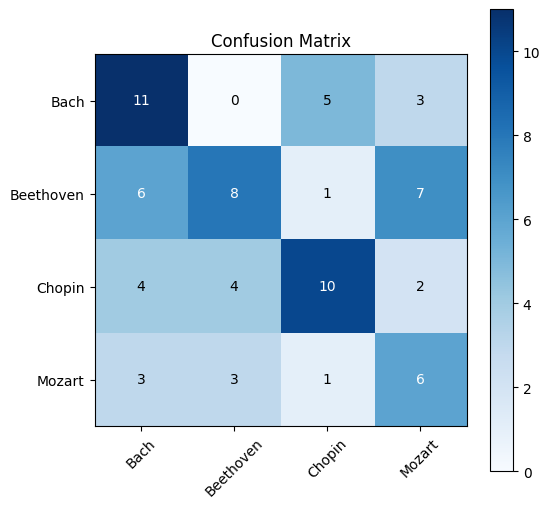

              precision    recall  f1-score   support

        Bach       0.46      0.58      0.51        19
   Beethoven       0.53      0.36      0.43        22
      Chopin       0.59      0.50      0.54        20
      Mozart       0.33      0.46      0.39        13

    accuracy                           0.47        74
   macro avg       0.48      0.48      0.47        74
weighted avg       0.49      0.47      0.47        74



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1) Build test dataset the same way as train/val
X_test, y_test = load_lstm_data('test')   # using your existing loader
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# 2) Get predictions
y_pred = model_lstm.predict(test_ds).argmax(axis=1)

# 3) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.xticks(range(4), list(label_map.keys()), rotation=45)
plt.yticks(range(4), list(label_map.keys()))
plt.colorbar(); plt.title("Confusion Matrix")
for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.show()

# 4) Classification report
print(classification_report(y_test, y_pred, target_names=list(label_map.keys())))


# New S

In [ ]:
pip install ace_tools

In [ ]:
# At the top of your notebook, before any PrettyMIDI loads:
import mido.midifiles.meta as meta

# Add a mapping for the bad (sharps, mode) tuple ⇒ choose any valid key, e.g. Eb major
meta._key_signature_decode[(-3, 255)] = 'Eb'

# Then your usual imports
import pretty_midi


In [ ]:
import os
import pandas as pd


# Ensure Drive is mounted in Colab
assert os.path.exists('/content/drive/MyDrive'), "Drive not mounted. Run 'from google.colab import drive ; drive.mount(\"/content/drive\")'"

DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'

counts = {}
for root, dirs, files in os.walk(DATA_ROOT):
    for file in files:
        if file.lower().endswith(('.mid', '.midi')):
            rel_path = os.path.relpath(root, DATA_ROOT)
            composer = rel_path.split(os.sep)[0]
            counts[composer] = counts.get(composer, 0) + 1

df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['midi_count']) \
    .reset_index() \
    .rename(columns={'index': 'composer'})

df_counts

,composer,midi_count
0,Mozart,257
1,Beethoven,213
2,Chopin,136
3,Bach,1024


In [ ]:
import os
import pretty_midi
import pandas as pd
from IPython.display import display

DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'

records = []
for root, dirs, files in os.walk(DATA_ROOT):
    for file in files:
        if file.lower().endswith(('.mid', '.midi')):
            file_path = os.path.join(root, file)
            composer = os.path.relpath(root, DATA_ROOT).split(os.sep)[0]
            try:
                pm = pretty_midi.PrettyMIDI(file_path)
                token_count = sum(len(inst.notes) for inst in pm.instruments)
                print(token_count)
            except Exception:
                token_count = None
            records.append((composer, file_path, token_count))

df = pd.DataFrame(records, columns=['composer','file_path','token_count'])
summary = (
    df.groupby('composer')['token_count']
      .agg(count='count', mean='mean', median='median', min='min', max='max')
      .reset_index()
)
display(summary)


9819
881
996
1830
10720
1186
465
4261
4973
1535
414
2795
7939
378
3482
4926
1288
7526
4224
3795
6934
11886
450
8294
2042
876
5022
434
3332
3133
3767
2295
5913
512
3338


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


1675
7009
6529
1301
1139
1697
2962
2692
5458
2266
4675
9536
302
2046
3601
2900
1728
12798
1102
11504
6392
9047
3964
1361
5642
3115
1372
4743
10384
6043
1597
9906
434
1431
10671
3536
5243
3654
4587
988
7038
2708
326
4115
260
4422
6804
2201
2194
1822
999
5912
876
573
996
7164
2381
1905
3090
8125
11853
7650
4675
2958
4857
3047
8130
7544
2344
3591
3979
6899
9710
11107
13940
8056
10611
2741
7440
1821
3597
11413
2328
10103
6690
4181
12551
4173
6050
16987
3416
3934
3326
7877
16749
4829
12779
6568
11262
2568
16109
5218
17358
3357
5113
12699
17850
608
7916
658
580
453
592
214
260
464
122
346
336
283
388
316
344
1216
790
300
680
166
240
10585
5920
7577
4774
7583
5917
4815
3441
6400
5770
8117
6868
3628
3257
7157
5567
7496
5855
9470
2871
4960
8013
3967
1924
3637
2018
2065
3187
14747
2460
7529
1751
2641
5914
2895
6374
1386
12742
5750
1484
8253
4772
1826
11777
4346
6984
13061
2373
1710
6938
5598
5034
1500
5699
15562
2821
16254
8541
5224
11057
5631
5406
8739
14273
6489
8889
10709
8608
9846
13182
1427

,composer,count,mean,median,min,max
0,Bach,1024,1733.700195,617.5,83.0,33004.0
1,Beethoven,212,7573.004717,4749.0,90.0,47745.0
2,Chopin,136,2350.757353,1604.5,164.0,19929.0
3,Mozart,256,5384.906250,4675.0,122.0,17850.0


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# assume `df` has columns ['composer', 'token_count', 'file_path']

# 1) split df → train/test, stratifying by composer only
split = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, test_idx = next(split.split(df, df['composer']))

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

# 2) split train → train/val, again stratifying by composer
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.15/0.70, random_state=42)
t_idx, val_idx = next(split2.split(train_df, train_df['composer']))

val_df   = train_df.iloc[val_idx].reset_index(drop=True)
train_df = train_df.iloc[t_idx].reset_index(drop=True)

# 3) check counts
print("Train composer counts:\n", train_df['composer'].value_counts(), "\n")
print(" Val composer counts:\n",    val_df['composer'].value_counts(), "\n")
print("Test composer counts:\n",    test_df['composer'].value_counts())


Train composer counts:
 composer
Bach         563
Mozart       141
Beethoven    117
Chopin        75
Name: count, dtype: int64 

 Val composer counts:
 composer
Bach         154
Mozart        39
Beethoven     32
Chopin        20
Name: count, dtype: int64 

Test composer counts:
 composer
Bach         307
Mozart        77
Beethoven     64
Chopin        41
Name: count, dtype: int64


In [ ]:
tempo_times, tempi = pm.get_tempo_changes()
bpm         = tempi[0]
sec_per_beat = 60.0 / bpm
grid         = sec_per_beat / 4.0   # 1/16-note


In [ ]:
import pretty_midi
from mido.midifiles.meta import KeySignatureError

def safe_extract_features(file_path, grid):
    """
    Attempts to load a MIDI and extract note‐level features.
    Returns a np.array of shape [n_notes × 5], or None if loading fails.
    """
    try:
        pm = pretty_midi.PrettyMIDI(file_path)
    except KeySignatureError as e:
        print(f"⚠️ Skipping bad MIDI (KeySignatureError): {file_path}")
        return None
    except Exception as e:
        print(f"⚠️ Skipping bad MIDI ({type(e).__name__}): {file_path}")
        return None

    # Now run your normal extract_features logic:
    notes = sorted(
        sum([inst.notes for inst in pm.instruments], []),
        key=lambda n: round(n.start / grid)
    )
    if not notes:
        return None

    records = []
    prev_end_tick = 0
    prev_pitch    = notes[0].pitch

    for note in notes:
        start_tick = int(round(note.start / grid))
        end_tick   = int(round(note.end   / grid))
        rest_tick  = max(0, start_tick - prev_end_tick)
        dur_tick   = max(1, end_tick - start_tick)
        interval   = note.pitch - prev_pitch

        records.append([
            note.pitch,
            dur_tick,
            note.velocity / 127,
            rest_tick,
            interval
        ])

        prev_end_tick = end_tick
        prev_pitch    = note.pitch

    return np.array(records, dtype=float)



In [ ]:
# first compute grid (once)
import numpy as np
import pretty_midi
pm0 = pretty_midi.PrettyMIDI(train_df.loc[0, 'file_path'])
tempo_times, tempi = pm0.get_tempo_changes()
bpm         = tempi[0]
sec_per_beat = 60.0 / bpm
grid         = sec_per_beat / 4.0

# then extract
for df in (train_df, val_df, test_df):
    df['features_array'] = df['file_path'].apply(lambda p: safe_extract_features(p, grid))


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


⚠️ Skipping bad MIDI (KeySignatureError): /content/drive/MyDrive/datasets/music_dataset/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid


In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def make_dataset(df, batch_size=32, N_NOTES=200, training=True, transpose_semitones=2, jitter_scale=0.05):
    label_map = {'Bach':0, 'Beethoven':1, 'Chopin':2, 'Mozart':3}

    def generator():
        for _, row in df.iterrows():
            # … compute pitch_seq, num_seq, y as before …

            # IMPORTANT: yield a TUPLE, not a list
            yield (pitch_seq, num_seq), y

    # Define your output_signature with tuples
    output_signature = (
        (   # inputs tuple
            tf.TensorSpec((N_NOTES,),    tf.int32),
            tf.TensorSpec((N_NOTES, 4),  tf.float32),
        ),
        tf.TensorSpec((4,), tf.float32)  # label
    )

    ds = tf.data.Dataset.from_generator(generator,
                                        output_signature=output_signature)
    if training:
        ds = ds.shuffle(len(df))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# 1) Pad or truncate each [n × F] array to exactly N rows
def pad_or_truncate(seq, N, pad_value=0.0):
    """
    seq:    np.array of shape (n_notes, feature_dim)
    N:      target number of notes
    pad_value: value to use for padding rows
    """
    n, F = seq.shape
    if n >= N:
        return seq[:N]
    padding = np.full((N - n, F), pad_value, dtype=seq.dtype)
    return np.vstack([seq, padding])

# 2) Data generator with on-the-fly transpose & jitter
class MusicDataGenerator(Sequence):
    def __init__(self, df, batch_size=64, N_NOTES=200,
                 transpose_semitones=2, jitter_scale=0.05, shuffle=True):
        """
        df must have columns:
          - 'features_array': np.ndarray of shape (n_notes, 5)
          - 'composer': string label
        """
        self.df          = df.reset_index(drop=True)
        self.batch_size  = batch_size
        self.N           = N_NOTES
        self.transpose   = transpose_semitones
        self.jitter      = jitter_scale
        self.shuffle     = shuffle
        self.label_map   = {'Bach':0, 'Beethoven':1, 'Chopin':2, 'Mozart':3}
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idxs = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        X_batch = np.zeros((len(batch_idxs), self.N, 5), dtype=float)
        y_batch = np.zeros((len(batch_idxs),), dtype=int)

        for i, df_idx in enumerate(batch_idxs):
            seq = self.df.loc[df_idx, 'features_array']  # shape (n_notes, 5)
            # pad/truncate
            seq = pad_or_truncate(seq, self.N)
            # random transpose
            shift = np.random.randint(-self.transpose, self.transpose+1)
            seq[:,0] = np.clip(seq[:,0] + shift, 0, 127)
            # jitter duration (col 1) and velocity (col 2)
            dur_jitter = 1.0 + np.random.uniform(-self.jitter, self.jitter, size=(self.N,))
            vel_jitter = 1.0 + np.random.uniform(-self.jitter, self.jitter, size=(self.N,))
            seq[:,1] *= dur_jitter
            seq[:,2] = np.clip(seq[:,2] * vel_jitter, 0.0, 1.0)
            # assign
            X_batch[i] = seq
            y_batch[i] = self.label_map[self.df.loc[df_idx, 'composer']]

        return X_batch, np.eye(4)[y_batch]  # one-hot

# 3) Example: build & train a simple Bi-LSTM model
def build_model(N_NOTES=200, feature_dim=5, lstm_units=[128,64]):
    inp = Input(shape=(N_NOTES, feature_dim))
    x   = TimeDistributed(Dense(64, activation='relu'))(inp)
    x   = Bidirectional(LSTM(lstm_units[0], return_sequences=True, dropout=0.3))(x)
    x   = Bidirectional(LSTM(lstm_units[1], dropout=0.3))(x)
    x   = Dense(64, activation='relu')(x)
    out = Dense(4, activation='softmax')(x)
    return Model(inp, out)

# Usage in Colab:
# train_gen = MusicDataGenerator(train_df, batch_size=64, N_NOTES=200)
# val_gen   = MusicDataGenerator(val_df,   batch_size=64, N_NOTES=200, shuffle=False)
#
# model = build_model(N_NOTES=200, feature_dim=5)
# model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
#
# callbacks = [
#   EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
#   ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
# ]
#
# model.fit(train_gen,
#           validation_data=val_gen,
#           epochs=50,
#           callbacks=callbacks)


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# 1) Build your integer labels for training
label_map = {'Bach':0, 'Beethoven':1, 'Chopin':2, 'Mozart':3}
y_train = train_df['composer'].map(label_map).values  # shape (n_samples,)

# 2) Compute balanced class weights
classes       = np.unique(y_train)                   # array([0,1,2,3])
weights_array = compute_class_weight(
                    class_weight='balanced',
                    classes=classes,
                    y=y_train
                )
class_weight = {cls: weights_array[i] for i, cls in enumerate(classes)}

print("Class weights:", class_weight)
# e.g. {0: 0.47, 1: 2.26, 2: 3.07, 3: 1.63}

# 3) Pass into model.fit
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weight
)


Class weights: {np.int64(0): np.float64(0.3978685612788632), np.int64(1): np.float64(1.9145299145299146), np.int64(2): np.float64(2.986666666666667), np.int64(3): np.float64(1.5886524822695036)}


NameError: name 'model' is not defined

In [ ]:
# 1) Import & sanity-check TF
import tensorflow as tf
print("TF version:", tf.__version__)

from tensorflow.keras.layers import (
    Layer, Input, Embedding, Concatenate,
    Bidirectional, LSTM, Dropout, Dense, TimeDistributed
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import Sequence
import numpy as np

# 2) Updated generator yielding [pitch, num_feats] as inputs
class MusicDataGenerator(Sequence):
    def __init__(self, df, batch_size=32, N_NOTES=200,
                 transpose_semitones=2, jitter_scale=0.05, shuffle=True):
        self.df         = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.N          = N_NOTES
        self.transpose  = transpose_semitones
        self.jitter     = jitter_scale
        self.shuffle    = shuffle
        self.label_map  = {'Bach':0, 'Beethoven':1, 'Chopin':2, 'Mozart':3}
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idxs = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        X = np.zeros((len(batch_idxs), self.N, 5), dtype=float)
        y = np.zeros((len(batch_idxs),), dtype=int)

        for i, df_idx in enumerate(batch_idxs):
            seq = self.df.loc[df_idx, 'features_array']
            # pad/truncate
            n, F = seq.shape
            if n >= self.N:
                seq2 = seq[:self.N]
            else:
                pad = np.zeros((self.N-n, F), dtype=seq.dtype)
                seq2 = np.vstack([seq, pad])
            # transpose
            shift = np.random.randint(-self.transpose, self.transpose+1)
            seq2[:,0] = np.clip(seq2[:,0] + shift, 0, 127)
            # jitter
            dur_j = 1 + np.random.uniform(-self.jitter, self.jitter, size=(self.N,))
            vel_j = 1 + np.random.uniform(-self.jitter, self.jitter, size=(self.N,))
            seq2[:,1] *= dur_j
            seq2[:,2] = np.clip(seq2[:,2] * vel_j, 0.0, 1.0)

            X[i] = seq2
            y[i] = self.label_map[self.df.loc[df_idx, 'composer']]

        # split into pitch vs numeric
        pitch_batch = X[:,:,0].astype(int)         # (batch, N)
        num_batch   = X[:,:,1:].astype(float)      # (batch, N, 4)
        y_onehot    = tf.keras.utils.to_categorical(y, num_classes=4)
        return [pitch_batch, num_batch], y_onehot

# 3) Attention layer
class AttentionLayer(Layer):
    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform', trainable=True
        )
        self.V = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform', trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        # [batch, time, feat]
        score = tf.tensordot(inputs, self.W, axes=[2,0])
        score = tf.tanh(score)
        score = tf.tensordot(score, self.V, axes=[2,0])  # [batch, time,1]
        weights = tf.nn.softmax(score, axis=1)            # [batch,time,1]
        return tf.reduce_sum(weights * inputs, axis=1)    # [batch,feat]

# 4) Build model
def build_model(
    N_NOTES=200, embedding_dim=64, lstm1=128, lstm2=64,
    dropout1=0.3, dropout2=0.4
):
    pitch_in = Input(shape=(N_NOTES,),    name='pitch_in')
    num_in   = Input(shape=(N_NOTES,4),   name='num_in')
    x1       = Embedding(128, embedding_dim)(pitch_in)
    x        = Concatenate()([x1, num_in])
    x        = Bidirectional(LSTM(lstm1, return_sequences=True))(x)
    x        = Dropout(dropout1)(x)
    x        = Bidirectional(LSTM(lstm2, return_sequences=True))(x)
    x        = AttentionLayer()(x)
    x        = Dense(64, activation='tanh')(x)
    x        = Dropout(dropout2)(x)
    out      = Dense(4, activation='softmax')(x)
    return Model([pitch_in, num_in], out)

model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 5) Prepare gens and class weights
train_gen = MusicDataGenerator(train_df, batch_size=32, N_NOTES=200)
val_gen   = MusicDataGenerator(val_df,   batch_size=32, N_NOTES=200, shuffle=False)

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_train = train_df['composer'].map({'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}).values
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(cw))
print("Class weights:", class_weight)

# 6) Callbacks & train
callbacks = [
    ReduceLROnPlateau('val_loss', factor=0.7, patience=2, verbose=1),
    EarlyStopping('val_loss', patience=5, restore_best_weights=True, verbose=1)
]
train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weight
)


TF version: 2.19.0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 64)   │      8,192 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 200, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 200, 68)   │          0 │ embedding_1[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 200, 256)  │    201,728 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 200, 256)  │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 200, 128)  │    164,352 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_1   │ (None, 128)       │     16,512 │ bidirectional_3[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │        260 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 399,300 (1.52 MB)

 Trainable params: 399,300 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: np.float64(0.3978685612788632), 1: np.float64(1.9145299145299146), 2: np.float64(2.986666666666667), 3: np.float64(1.5886524822695036)}
Epoch 1/50


UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  NameError: name 'pitch_seq' is not defined
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipython-input-4192336110.py", line 15, in generator
    yield (pitch_seq, num_seq), y
           ^^^^^^^^^

NameError: name 'pitch_seq' is not defined


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) UNKNOWN:  NameError: name 'pitch_seq' is not defined
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipython-input-4192336110.py", line 15, in generator
    yield (pitch_seq, num_seq), y
           ^^^^^^^^^

NameError: name 'pitch_seq' is not defined


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_6293]

In [ ]:
import tensorflow as tf
import numpy as np

def make_dataset(df, batch_size=32, N_NOTES=200, training=True,
                 transpose_semitones=2, jitter_scale=0.05):
    label_map = {'Bach':0, 'Beethoven':1, 'Chopin':2, 'Mozart':3}

    def generator():
        for _, row in df.iterrows():
            seq = row['features_array']  # original (n_notes, 5)
            n, F = seq.shape
            # pad or truncate
            if n >= N_NOTES:
                seq2 = seq[:N_NOTES].copy()
            else:
                pad = np.zeros((N_NOTES - n, F), dtype=seq.dtype)
                seq2 = np.vstack([seq, pad])

            # augment if training
            if training:
                shift = np.random.randint(-transpose_semitones, transpose_semitones + 1)
                seq2[:, 0] = np.clip(seq2[:, 0] + shift, 0, 127)
                dur_j = 1 + np.random.uniform(-jitter_scale, jitter_scale, size=(N_NOTES,))
                vel_j = 1 + np.random.uniform(-jitter_scale, jitter_scale, size=(N_NOTES,))
                seq2[:, 1] *= dur_j
                seq2[:, 2] = np.clip(seq2[:, 2] * vel_j, 0.0, 1.0)

            pitch_seq = seq2[:, 0].astype(np.int32)    # (N_NOTES,)
            num_seq   = seq2[:, 1:].astype(np.float32) # (N_NOTES, 4)
            label_int = label_map[row['composer']]
            y = tf.one_hot(label_int, depth=4, dtype=tf.float32)

            yield (pitch_seq, num_seq), y

    output_signature = (
        (tf.TensorSpec((N_NOTES,),    tf.int32),
         tf.TensorSpec((N_NOTES, 4),  tf.float32)),
        tf.TensorSpec((4,),            tf.float32)
    )

    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    if training:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create datasets
train_ds = make_dataset(train_df, batch_size=32, N_NOTES=200, training=True)
val_ds   = make_dataset(val_df,   batch_size=32, N_NOTES=200, training=False)

# Train the model
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weight
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6826 - loss: 0.9013 - val_accuracy: 0.6367 - val_loss: 0.8656 - learning_rate: 3.4300e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7059 - loss: 0.8496 - val_accuracy: 0.6980 - val_loss: 0.7986 - learning_rate: 3.4300e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7016 - loss: 0.8614 - val_accuracy: 0.5918 - val_loss: 0.9197 - learning_rate: 3.4300e-04
Epoch 4/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6676 - loss: 0.8370
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6702 - loss: 0.8362 - val_accuracy: 0.6571 - val_loss: 0.8420 - learning_rate: 3.4300e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7003 - loss: 0.7774 - val_accuracy: 0.6204 - val_loss: 0.8927 - learning_rate: 2.4010e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6806 - lo

In [ ]:
!pip install -q keras-tuner

import kerastuner as kt
import tensorflow as tf

def build_tuned_model(hp):
    embed_dim = hp.Choice('embed_dim', [32, 64, 128])
    lstm1     = hp.Choice('lstm_units_1', [64, 128, 256])
    lstm2     = hp.Choice('lstm_units_2', [32, 64, 128])
    dr1       = hp.Choice('dropout_1', [0.2, 0.3, 0.4])
    dr2       = hp.Choice('dropout_2', [0.2, 0.3, 0.4])
    lr        = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])

    model = build_lstm_attention_model(
        N_NOTES=200,
        embedding_dim=embed_dim,
        lstm_units_1=lstm1,
        lstm_units_2=lstm2,
        dropout_1=dr1,
        dropout_2=dr2
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_tuned_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='music_composer_lstm'
)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=3)],
    class_weight=class_weight
)

best_models = tuner.get_best_models(num_models=3)
for i, bm in enumerate(best_models):
    print(f"\n--- Best model #{i+1} summary ---")
    bm.summary()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.5 MB/s eta 0:00:00


/tmp/ipython-input-100424300.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


NameError: name 'build_lstm_attention_model' is not defined

In [ ]:
!pip install -q keras-tuner RandomSearch

In [ ]:
# 1) Install & import the tuner
!pip install -q keras-tuner

import keras_tuner as kt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Input, Embedding, Concatenate, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# 2) Define your Attention layer & model builder
class AttentionLayer(Layer):
    def build(self, input_shape):
        self.W = self.add_weight((input_shape[-1], input_shape[-1]), 'glorot_uniform', trainable=True)
        self.V = self.add_weight((input_shape[-1], 1),             'glorot_uniform', trainable=True)
        super().build(input_shape)
    def call(self, x):
        score   = tf.tensordot(x, self.W, axes=[2,0])
        score   = tf.tanh(score)
        score   = tf.tensordot(score, self.V, axes=[2,0])
        weights = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(weights * x, axis=1)

def build_lstm_attention_model(hp):
    N_NOTES   = 200
    embed_dim = hp.Choice('embed_dim',   [32, 64, 128])
    lstm1     = hp.Choice('lstm1',       [64, 128, 256])
    lstm2     = hp.Choice('lstm2',       [32, 64, 128])
    dr1       = hp.Choice('dropout1',    [0.2, 0.3, 0.4])
    dr2       = hp.Choice('dropout2',    [0.2, 0.3, 0.4])
    lr        = hp.Choice('learning_rate',[1e-3,1e-4,1e-5])

    pitch_in = Input(shape=(N_NOTES,),    name='pitch')
    num_in   = Input(shape=(N_NOTES,4),   name='num_feats')
    x1 = Embedding(128, embed_dim, input_length=N_NOTES)(pitch_in)
    x  = Concatenate()([x1, num_in])
    x  = Bidirectional(LSTM(lstm1, return_sequences=True))(x)
    x  = Dropout(dr1)(x)
    x  = Bidirectional(LSTM(lstm2, return_sequences=True))(x)
    x  = AttentionLayer()(x)
    x  = Dense(64, activation='tanh')(x)
    x  = Dropout(dr2)(x)
    out= Dense(4, activation='softmax')(x)

    model = Model([pitch_in, num_in], out)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(lr),
      loss='categorical_crossentropy',
      metrics=['accuracy']
    )
    return model

# 3) Compute class weights
y_train = train_df['composer'].map({'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}).values
# corrected:
cw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight = dict(enumerate(cw))


# 4) Run RandomSearch
tuner = kt.RandomSearch(
    build_lstm_attention_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='music_composer_lstm'
)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[EarlyStopping('val_accuracy', patience=3)],
    class_weight=class_weight
)

# 5) See the top 3
best = tuner.get_best_models(num_models=3)
for i, m in enumerate(best, 1):
    print(f"\n=== Top model #{i} ===")
    m.summary()


Trial 20 Complete [00h 00m 21s]
val_accuracy: 0.6571428775787354

Best val_accuracy So Far: 0.718367338180542
Total elapsed time: 00h 07m 12s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



=== Top model #1 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch (InputLayer)  │ (None, 200)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 32)   │      4,096 │ pitch[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_feats           │ (None, 200, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200, 36)   │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ num_feats[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 128)  │     51,712 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 128)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 200, 256)  │    263,168 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 256)       │     65,792 │ bidirectional_1[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 401,476 (1.53 MB)

 Trainable params: 401,476 (1.53 MB)

 Non-trainable params: 0 (0.00 B)


=== Top model #2 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch (InputLayer)  │ (None, 200)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 64)   │      8,192 │ pitch[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_feats           │ (None, 200, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200, 68)   │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ num_feats[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 512)  │    665,600 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 512)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 200, 128)  │    295,424 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 128)       │     16,512 │ bidirectional_1[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 994,244 (3.79 MB)

 Trainable params: 994,244 (3.79 MB)

 Non-trainable params: 0 (0.00 B)


=== Top model #3 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch (InputLayer)  │ (None, 200)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 64)   │      8,192 │ pitch[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_feats           │ (None, 200, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200, 68)   │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ num_feats[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 256)  │    201,728 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 256)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 200, 64)   │     73,984 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 64)        │      4,160 │ bidirectional_1[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 292,484 (1.12 MB)

 Trainable params: 292,484 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Fetch the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

# Rebuild the model with those HPs
final_model = build_lstm_attention_model(best_hp)

# Compile again (just to be safe)
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(best_hp.get('learning_rate')),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# After extracting features on each split, drop any failed rows:
for split_df in (train_df, val_df, test_df):
    before = len(split_df)
    split_df.dropna(subset=['features_array'], inplace=True)
    print(f"Dropped {before - len(split_df)} bad MIDI files")

# Retrain on train+val combined, then evaluate on test
combined_df = pd.concat([train_df, val_df]).reset_index(drop=True)
combined_ds = make_dataset(combined_df, batch_size=32, training=True)

test_ds = make_dataset(test_df, batch_size=32, training=False)

callbacks = [
    EarlyStopping('val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', factor=0.7, patience=3)
]

final_model.fit(
    combined_ds,
    validation_data=test_ds,   # monitor on the real test set
    epochs=100,
    callbacks=callbacks,
    class_weight=class_weight
)


Dropped 0 bad MIDI files
Dropped 0 bad MIDI files
Dropped 1 bad MIDI files
Epoch 1/100
     35/Unknown 6s 33ms/step - accuracy: 0.3844 - loss: 1.3891

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.3876 - loss: 1.3879 - val_accuracy: 0.5512 - val_loss: 1.2102 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5614 - loss: 1.2029 - val_accuracy: 0.6148 - val_loss: 0.9670 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6021 - loss: 1.1444 - val_accuracy: 0.5348 - val_loss: 1.0834 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5771 - loss: 1.1014 - val_accuracy: 0.6619 - val_loss: 0.8313 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5832 - loss: 1.0410 - val_accuracy: 0.6537 - val_loss: 0.8334 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6529 - loss: 0.9821 - val_accuracy: 0.5471 - val_loss: 1.0352 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6416 - loss: 0.9279 - val_accuracy

In [ ]:
loss, acc = model.evaluate(test_ds, verbose=1)
print(f"Test loss: {loss:.4f}  —  Test accuracy: {acc:.4%}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6418 - loss: 0.8087
Test loss: 0.8139  —  Test accuracy: 67.0082%


              precision    recall  f1-score   support

        Bach       0.90      0.78      0.84       307
   Beethoven       0.36      0.41      0.38        64
      Chopin       0.43      0.71      0.54        41
      Mozart       0.40      0.45      0.42        76

    accuracy                           0.67       488
   macro avg       0.52      0.58      0.54       488
weighted avg       0.71      0.67      0.69       488



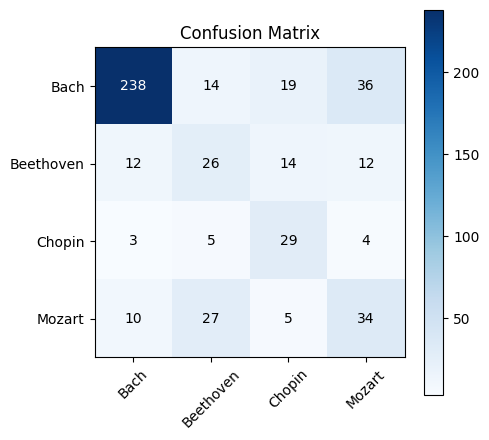

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Convert your lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# If either is one-hot, argmax it to get class indices
if y_true.ndim > 1:
    y_true = y_true.argmax(axis=1)
if y_pred.ndim > 1:
    y_pred = y_pred.argmax(axis=1)

# Now you can safely do:
print(classification_report(
    y_true, y_pred,
    target_names=['Bach','Beethoven','Chopin','Mozart']
))

# And plot a confusion matrix if you like:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues')
plt.xticks(range(4), ['Bach','Beethoven','Chopin','Mozart'], rotation=45)
plt.yticks(range(4), ['Bach','Beethoven','Chopin','Mozart'])
for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i,j],
                 ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Embedding, Concatenate, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Model

# 1) Attention layer (unchanged)
class AttentionLayer(Layer):
    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform', trainable=True
        )
        self.V = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform', trainable=True
        )
        super().build(input_shape)

    def call(self, x):
        score   = tf.tensordot(x, self.W, axes=[2,0])
        score   = tf.tanh(score)
        score   = tf.tensordot(score, self.V, axes=[2,0])   # [batch,time,1]
        weights = tf.nn.softmax(score, axis=1)               # [batch,time,1]
        return tf.reduce_sum(weights * x, axis=1)            # [batch,features]

# 2) Rebuild the model expecting 4 numeric features
def build_note_level_attn_model(
    N_NOTES=200,
    embedding_dim=32,
    lstm1=64,
    lstm2=32,
    dropout_rate=0.3,
    numeric_dim=4   # <— change here
):
    # Inputs
    pitch_in = Input(shape=(N_NOTES,),     dtype='int32',   name='pitch_in')
    num_in   = Input(shape=(N_NOTES,4),    dtype='float32', name='num_in')  # now 4

    # Embed and concat
    x1 = Embedding(input_dim=128, output_dim=embedding_dim)(pitch_in)
    x  = Concatenate()([x1, num_in])       # shape=(batch,N_NOTES,embedding_dim+4)

    # Bi-LSTM stack
    x = Bidirectional(LSTM(lstm1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm2, return_sequences=True))(x)

    # Attention pooling
    x = AttentionLayer()(x)

    # Final classifier
    x = Dropout(dropout_rate)(Dense(64, activation='tanh')(x))
    out = Dense(4, activation='softmax')(x)

    model = Model([pitch_in, num_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 3) Instantiate & train
model_attn = build_note_level_attn_model()
model_attn.summary()

# Then:
history = model_attn.fit(
    train_ds,               # ([pitch_batch, num_batch], y_batch)
    validation_data=val_ds,
    epochs=50,
    callbacks=[
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    class_weight=class_weight
)

# 4) Evaluate
loss, acc = model_attn.evaluate(test_ds)
print(f"Attention‐enhanced test accuracy: {acc:.4%}")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 200, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 200, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 200, 36)   │          0 │ embedding_5[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 200, 128)  │     51,712 │ concatenate_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 200, 64)   │     41,216 │ bidirectional_10… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_5   │ (None, 64)        │      4,160 │ bidirectional_11… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 4)         │        260 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,604 (412.52 KB)

 Trainable params: 105,604 (412.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
     27/Unknown 6s 32ms/step - accuracy: 0.3200 - loss: 1.4587

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.3240 - loss: 1.4535 - val_accuracy: 0.5714 - val_loss: 1.2167 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4968 - loss: 1.3581 - val_accuracy: 0.6122 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5429 - loss: 1.2581 - val_accuracy: 0.6122 - val_loss: 0.9433 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5470 - loss: 1.2379 - val_accuracy: 0.6327 - val_loss: 0.8904 - learning_rate: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6034 - loss: 1.0920 - val_accuracy: 0.6327 - val_loss: 0.8883 - learning_rate: 0.0010
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6444 - loss: 1.0353 - val_accuracy: 0.5796 - val_loss: 0.9504 - learning_rate: 0.0010
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6347 - loss: 1.0444 - val_accuracy: 0.64

In [ ]:
# 1) Import & sanity check
import tensorflow as tf
import numpy as np
import keras_tuner as kt
from tensorflow.keras.layers import (
    Layer, Input, Embedding, Concatenate,
    Conv1D, MaxPooling1D,
    Bidirectional, LSTM, Dropout, Dense
)
from tensorflow.keras.models import Model

# 2) Attention layer (same as before)
class AttentionLayer(Layer):
    def build(self, input_shape):
        self.W = self.add_weight((input_shape[-1], input_shape[-1]),
                                 'glorot_uniform', trainable=True)
        self.V = self.add_weight((input_shape[-1], 1),
                                 'glorot_uniform', trainable=True)
        super().build(input_shape)
    def call(self, x):
        score   = tf.tensordot(x, self.W, axes=[2,0])
        score   = tf.tanh(score)
        score   = tf.tensordot(score, self.V, axes=[2,0])   # [B,T,1]
        weights = tf.nn.softmax(score, axis=1)              # [B,T,1]
        return tf.reduce_sum(weights * x, axis=1)           # [B,feat]

# 3) Hypermodel builder
def conv_lstm_attn_builder(hp):
    N_NOTES     = 200
    embedding   = hp.Choice('embed_dim', [32, 64, 128])
    conv_filters= hp.Choice('conv_filters', [32, 64, 128])
    kernel      = hp.Choice('kernel_size',   [3,5,7])
    pool        = hp.Choice('pool_size',     [2,4])
    lstm1       = hp.Choice('lstm1',         [64,128,256])
    lstm2       = hp.Choice('lstm2',         [32,64,128])
    drop        = hp.Choice('dropout',       [0.2,0.3,0.4])
    lr          = hp.Choice('lr',            [1e-3,1e-4,1e-5])

    # Inputs
    pitch_in = Input((N_NOTES,), dtype='int32',   name='pitch')
    num_in   = Input((N_NOTES,4), dtype='float32', name='num')

    x1 = Embedding(128, embedding)(pitch_in)
    x  = Concatenate()([x1, num_in])
    x  = Conv1D(conv_filters, kernel, padding='same', activation='relu')(x)
    x  = MaxPooling1D(pool_size=pool)(x)
    x  = Bidirectional(LSTM(lstm1, return_sequences=True))(x)
    x  = Bidirectional(LSTM(lstm2, return_sequences=True))(x)
    x  = AttentionLayer()(x)
    x  = Dropout(drop)(Dense(64, activation='tanh')(x))
    out= Dense(4, activation='softmax')(x)

    model = Model([pitch_in, num_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 4) Run RandomSearch on this hypermodel
tuner = kt.RandomSearch(
    conv_lstm_attn_builder,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='conv_lstm_attn'
)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=3)],
    class_weight=class_weight
)

# 5) Get best model and retrain fully
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = conv_lstm_attn_builder(best_hp)

# Retrain on train+val → test
combined = train_ds.concatenate(val_ds)
best_model.fit(
    combined,
    validation_data=test_ds,
    epochs=50,
    callbacks=[
      tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=3),
      tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)
    ],
    class_weight=class_weight
)

# 6) Final evaluation
loss, acc = best_model.evaluate(test_ds)
print(f"🔹 Conv1D+LSTM+Attention test accuracy: {acc:.4%}")


Trial 15 Complete [00h 00m 15s]
val_accuracy: 0.5836734771728516

Best val_accuracy So Far: 0.6897959113121033
Total elapsed time: 00h 04m 39s
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.2714 - loss: 1.3819 - val_accuracy: 0.4283 - val_loss: 1.3143 - learning_rate: 1.0000e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3924 - loss: 1.3760 - val_accuracy: 0.4959 - val_loss: 1.2361 - learning_rate: 1.0000e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4922 - loss: 1.2800 - val_accuracy: 0.5082 - val_loss: 1.1698 - learning_rate: 1.0000e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5136 - loss: 1.2609 - val_accuracy: 0.4959 - val_loss: 1.2339 - learning_rate: 1.0000e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5464 - loss: 1.1824 - val_accuracy: 0.5574 - val_loss: 1.0456 - learning_rate: 1.0000e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5979 - loss: 1.11

# Fresh Outlook Again

## **EDA**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine all splits if needed
all_df = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

# Summarize each piece
def summarize_piece(seq):
    return {
        'n_notes': seq.shape[0],
        'mean_pitch': seq[:,0].mean(),
        'mean_dur':   seq[:,1].mean(),
        'mean_vel':   seq[:,2].mean(),
        'mean_rest':  seq[:,3].mean(),
        'mean_interval': seq[:,4].mean(),
    }

rows = []
for _, r in all_df.iterrows():
    if r['features_array'] is not None:
        stats = summarize_piece(r['features_array'])
        stats['composer'] = r['composer']
        rows.append(stats)

summary_df = pd.DataFrame(rows)

# Display grouped stats
print(summary_df.groupby('composer').agg(['mean','std']))


               n_notes              mean_pitch            mean_dur            \
                  mean          std       mean       std      mean       std   
composer                                                                       
Bach       1733.700195  3093.118663  62.383170  2.841024  3.510618  1.346164   
Beethoven  7543.985915  8336.025113  63.603486  2.542856  2.593693  1.446523   
Chopin     2350.757353  2662.857948  62.889429  4.127321  2.784615  1.798766   
Mozart     5384.906250  4136.806026  64.727861  2.597538  2.658776  1.197450   

           mean_vel           mean_rest           mean_interval            
               mean       std      mean       std          mean       std  
composer                                                                   
Bach       0.705167  0.122215  0.040675  0.049694     -0.042837  0.049750  
Beethoven  0.571476  0.144662  0.082869  0.066623     -0.010232  0.026018  
Chopin     0.520546  0.168176  0.075279  0.067931     -0.00

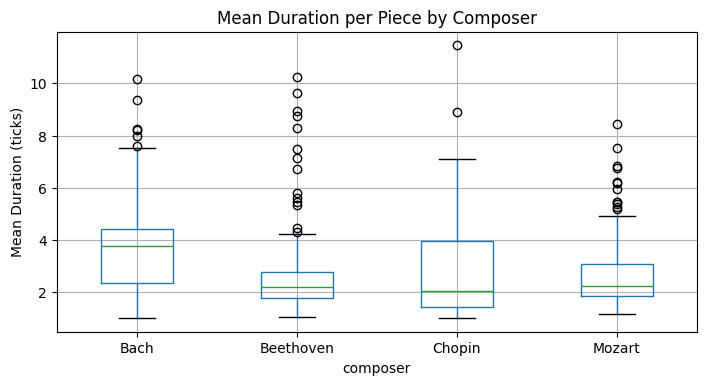

In [ ]:
# Boxplot of mean_duration by composer
summary_df.boxplot(column='mean_dur', by='composer', figsize=(8,4))
plt.title('Mean Duration per Piece by Composer')
plt.suptitle('')
plt.ylabel('Mean Duration (ticks)')
plt.show()


 A few quick observations from your summary:

Mean duration per piece (our boxplot) shows Bach pieces tend to have longer average note‐lengths and much higher variance, whereas Beethoven’s durations are more compact on average.

Pitch means are all clustered around the low 60s (middle‐C region), with Mozart slightly higher—so pitch center alone won’t distinguish much.

Velocity (dynamics) is notably higher for Bach (mean ~0.70) than for Chopin (~0.52) or Beethoven (~0.57), suggesting Bach’s pieces tend to use a wider or louder dynamic range.

Rest lengths are shortest in Bach and longest in Mozart—Mozart is more “pause-heavy.”

Intervals hover near zero (mostly stepwise motion), but Bach has slightly more negative mean interval (more downward motion).



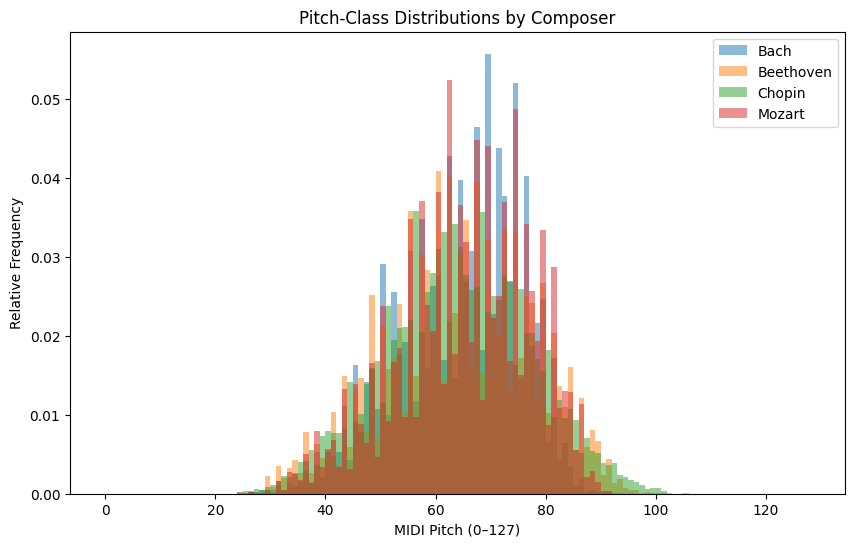

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for comp, group in summary_df.groupby('composer'):
    # gather all pitches
    pitches = np.concatenate([row['features_array'][:,0] for _, row in all_df[all_df['composer']==comp].iterrows() if row['features_array'] is not None])
    plt.hist(pitches, bins=range(0,129), alpha=0.5, label=comp, density=True)
plt.title("Pitch-Class Distributions by Composer")
plt.xlabel("MIDI Pitch (0–127)")
plt.ylabel("Relative Frequency")
plt.legend()
plt.show()


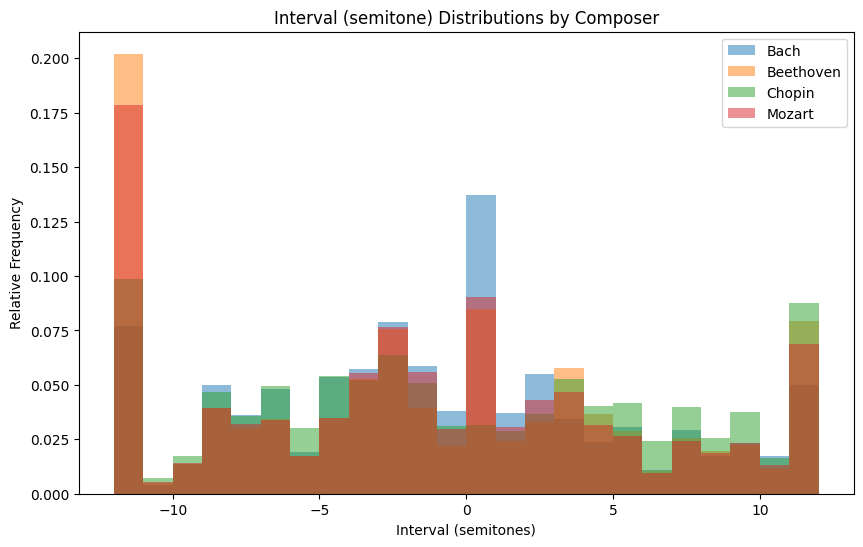

In [ ]:
plt.figure(figsize=(10,6))
for comp, group in summary_df.groupby('composer'):
    intervals = np.concatenate([row['features_array'][:,4] for _, row in all_df[all_df['composer']==comp].iterrows() if row['features_array'] is not None])
    plt.hist(intervals, bins=range(-12,13), alpha=0.5, label=comp, density=True)
plt.title("Interval (semitone) Distributions by Composer")
plt.xlabel("Interval (semitones)")
plt.ylabel("Relative Frequency")
plt.legend()
plt.show()


pitch‐class and interval profiles are surprisingly similar across composers, which explains why pure pitch/interval fed into the LSTM isn’t enough to crack 80 %.

What stands out:
All four composers cluster around MIDI 50–90 pitches, with Mozart skewing ever so slightly higher.

The huge spike at 0 semitones (repeated notes) dominates every composer.

Bach shows a slightly wider “leapy” tail (±10–12 semitones), but it’s subtle.

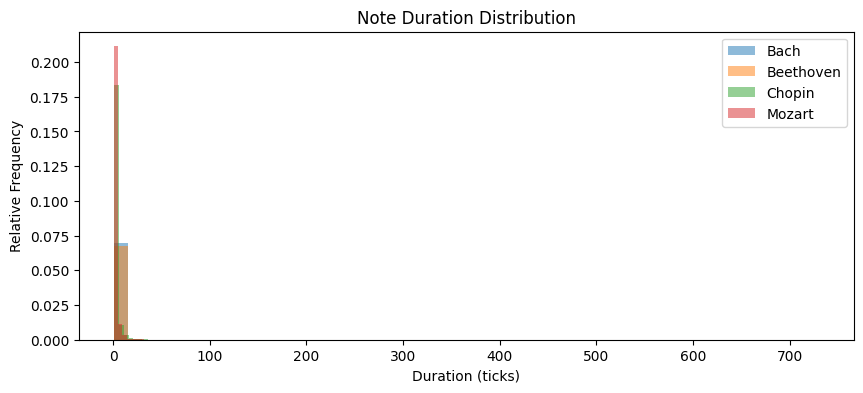

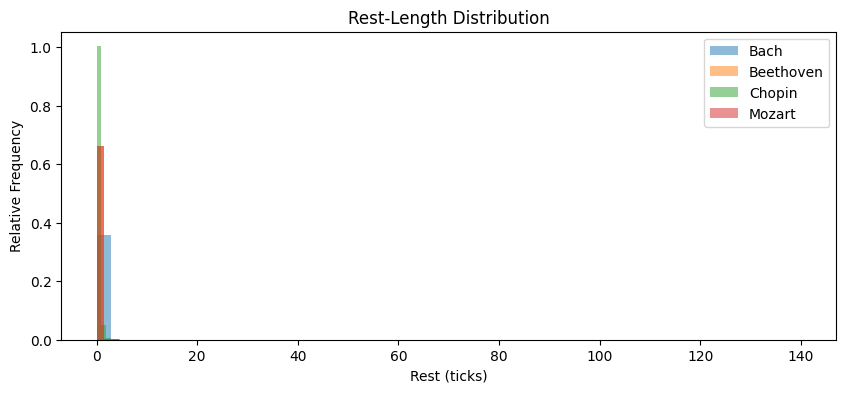

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Gather all durations & rests per composer
durations = {c: [] for c in ['Bach','Beethoven','Chopin','Mozart']}
rests     = {c: [] for c in durations}

for df in (train_df, val_df, test_df):
    for _, r in df.iterrows():
        seq = r['features_array']
        if seq is None: continue
        c = r['composer']
        durations[c].extend(seq[:,1])  # duration ticks
        rests[c].extend(seq[:,3])      # rest ticks

# Plot duration histograms
plt.figure(figsize=(10,4))
for c, vals in durations.items():
    plt.hist(vals, bins=50, density=True, alpha=0.5, label=c)
plt.title("Note Duration Distribution")
plt.xlabel("Duration (ticks)")
plt.ylabel("Relative Frequency")
plt.legend()
plt.show()

# Plot rest histograms
plt.figure(figsize=(10,4))
for c, vals in rests.items():
    plt.hist(vals, bins=50, density=True, alpha=0.5, label=c)
plt.title("Rest‐Length Distribution")
plt.xlabel("Rest (ticks)")
plt.ylabel("Relative Frequency")
plt.legend()
plt.show()


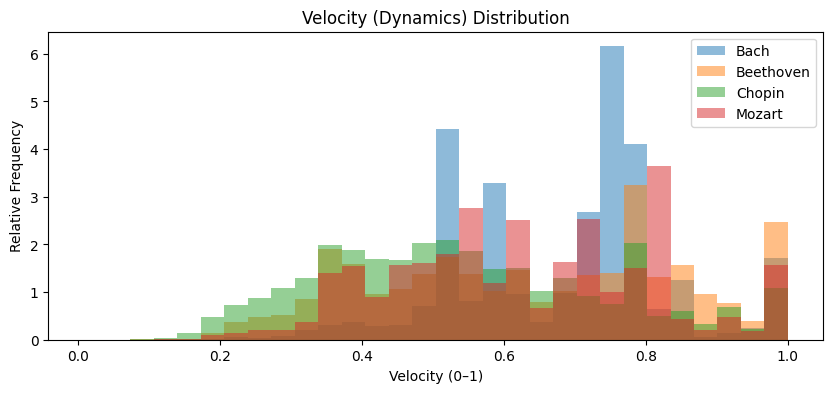

In [ ]:
# Gather all velocities per composer
vels = {c: [] for c in durations}
for df in (train_df, val_df, test_df):
    for _, r in df.iterrows():
        seq = r['features_array']
        if seq is None: continue
        c = r['composer']
        vels[c].extend(seq[:,2])  # normalized 0–1

plt.figure(figsize=(10,4))
for c, vals in vels.items():
    plt.hist(vals, bins=30, density=True, alpha=0.5, label=c)
plt.title("Velocity (Dynamics) Distribution")
plt.xlabel("Velocity (0–1)")
plt.ylabel("Relative Frequency")
plt.legend()
plt.show()


In [ ]:
from collections import Counter

def make_ngrams(seq, n=2, kind='pitch'):
    """
    seq: np.array (n_notes,5)
    kind: 'pitch', 'interval', or 'dur_pitch' for combined tokens
    """
    if kind=='pitch':
        tokens = seq[:,0].astype(int)
    elif kind=='interval':
        tokens = seq[:,4].astype(int)
    elif kind=='dur_pitch':
        # tuple of (pitch,duration)
        tokens = [tuple(map(int,row[:2])) for row in seq]
    else:
        raise ValueError
    ngrams = zip(*(tokens[i:] for i in range(n)))
    return Counter(ngrams)

for kind in ['pitch','interval','dur_pitch']:
    print(f"\n--- Top bigrams of {kind} ---")
    combined = Counter()
    for df in (train_df,val_df,test_df):
        for _, r in df.iterrows():
            seq = r['features_array']
            if seq is None: continue
            combined.update(make_ngrams(seq, n=2, kind=kind))
    for gram, cnt in combined.most_common(10):
        print(gram, cnt)

    print(f"\n--- Top trigrams of {kind} ---")
    combined = Counter()
    for df in (train_df,val_df,test_df):
        for _, r in df.iterrows():
            seq = r['features_array']
            if seq is None: continue
            combined.update(make_ngrams(seq, n=3, kind=kind))
    for gram, cnt in combined.most_common(10):
        print(gram, cnt)



--- Top bigrams of pitch ---
(np.int64(62), np.int64(50)) 23699
(np.int64(60), np.int64(48)) 22334
(np.int64(67), np.int64(55)) 21462
(np.int64(55), np.int64(43)) 21390
(np.int64(74), np.int64(62)) 20556
(np.int64(69), np.int64(57)) 20551
(np.int64(57), np.int64(45)) 20385
(np.int64(74), np.int64(74)) 18733
(np.int64(72), np.int64(60)) 18475
(np.int64(69), np.int64(69)) 18393

--- Top trigrams of pitch ---
(np.int64(67), np.int64(55), np.int64(43)) 5819
(np.int64(62), np.int64(50), np.int64(38)) 5473
(np.int64(69), np.int64(57), np.int64(45)) 5015
(np.int64(72), np.int64(60), np.int64(48)) 4265
(np.int64(69), np.int64(69), np.int64(69)) 4210
(np.int64(60), np.int64(48), np.int64(36)) 4150
(np.int64(62), np.int64(62), np.int64(62)) 4035
(np.int64(65), np.int64(53), np.int64(41)) 3994
(np.int64(62), np.int64(62), np.int64(50)) 3854
(np.int64(74), np.int64(74), np.int64(74)) 3752

--- Top bigrams of interval ---
(np.int64(-12), np.int64(-12)) 79049
(np.int64(0), np.int64(0)) 67658
(np.in

In [ ]:
import pretty_midi
import numpy as np

# K/S major profile
major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09,
                          2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53,
                          2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

def estimate_key(pitches):
    # pitches: list of MIDI ints
    hist = np.bincount(pitches, minlength=12)[:12]  # pitch classes
    best = (None, -np.inf)
    for mode, profile in [('maj',major_profile), ('min',minor_profile)]:
        for shift in range(12):
            prof = np.roll(profile, shift)
            score = np.corrcoef(hist, prof)[0,1]
            if score > best[1]:
                best = (f"{shift}_{mode}", score)
    return best[0]

key_counts = Counter()
for df in (train_df,val_df,test_df):
    for _, r in df.iterrows():
        seq = r['features_array']
        if seq is None: continue
        pcs = (seq[:,0] % 12).astype(int)
        key = estimate_key(pcs)
        key_counts[key] += 1

print("Most common estimated keys:", key_counts.most_common(10))


Most common estimated keys: [('7_maj', 197), ('0_maj', 172), ('2_maj', 148), ('9_maj', 124), ('5_maj', 117), ('2_min', 99), ('9_min', 99), ('7_min', 92), ('10_maj', 88), ('0_min', 80)]


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/tmp/ipython-input-2755211065.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([densities[c] for c in densities], labels=densities.keys())


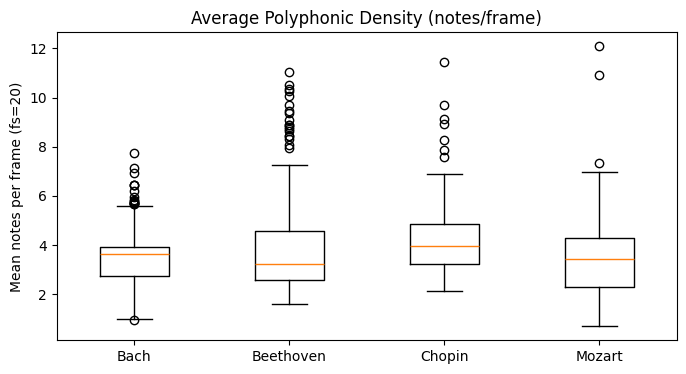

In [ ]:
import pretty_midi

densities = {c: [] for c in durations}
for df in (train_df,val_df,test_df):
    for _, r in df.iterrows():
        if r['features_array'] is None: continue
        path = r['file_path']
        pm = pretty_midi.PrettyMIDI(path)
        # piano-roll at 20 frames/sec
        pr = pm.get_piano_roll(fs=20) > 0
        # mean simultaneous notes per frame
        density = pr.sum(axis=0).mean()
        densities[r['composer']].append(density)

plt.figure(figsize=(8,4))
plt.boxplot([densities[c] for c in densities], labels=densities.keys())
plt.title("Average Polyphonic Density (notes/frame)")
plt.ylabel("Mean notes per frame (fs=20)")
plt.show()


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


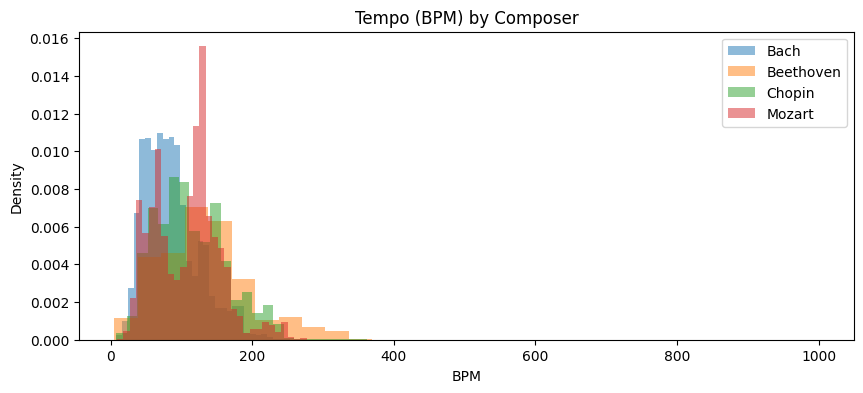

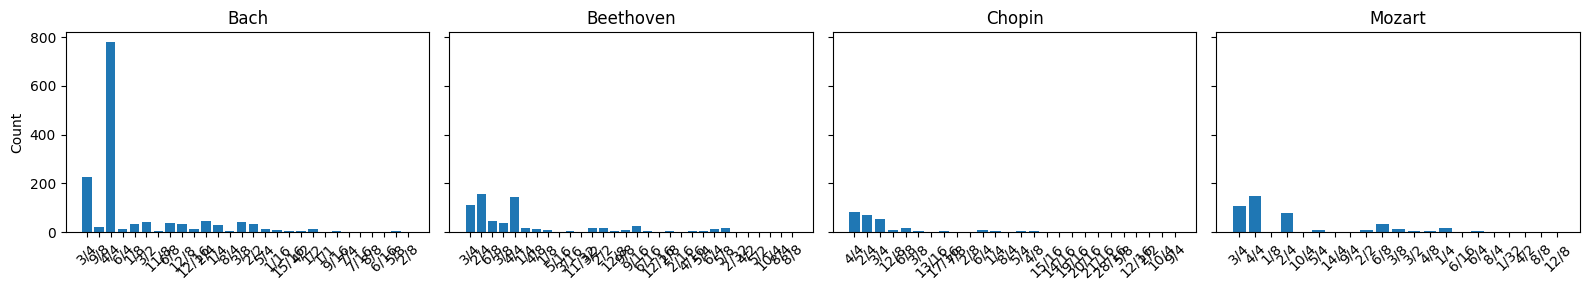

/tmp/ipython-input-2067970857.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pc_ent[c] for c in composers], labels=composers)


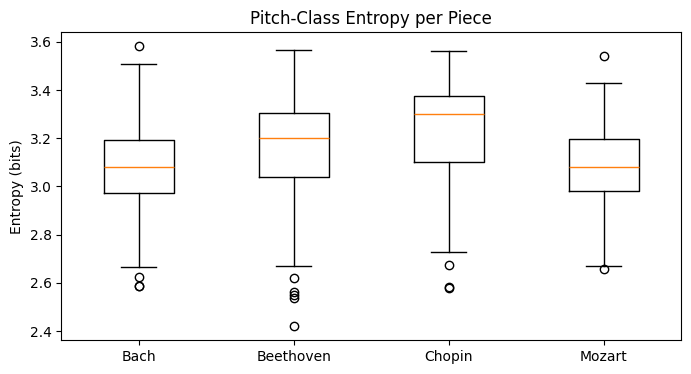

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(



Top 10 simultaneous PC‐sets for Bach:
  (np.int64(2), np.int64(6), np.int64(9)): 84929
  (np.int64(2), np.int64(7), np.int64(11)): 80098
  (np.int64(0), np.int64(4), np.int64(7)): 63994
  (np.int64(1), np.int64(4), np.int64(9)): 60801
  (np.int64(0), np.int64(5), np.int64(9)): 48439
  (np.int64(2), np.int64(5), np.int64(9)): 46358
  (np.int64(0), np.int64(4), np.int64(9)): 46133
  (np.int64(4), np.int64(7), np.int64(11)): 43274
  (np.int64(2), np.int64(6), np.int64(11)): 42074
  (np.int64(2), np.int64(5), np.int64(10)): 38305

Top 10 simultaneous PC‐sets for Beethoven:
  (np.int64(0), np.int64(4), np.int64(7)): 44165
  (np.int64(2), np.int64(7), np.int64(11)): 37416
  (np.int64(3), np.int64(7), np.int64(10)): 36166
  (np.int64(0), np.int64(5), np.int64(9)): 33833
  (np.int64(2), np.int64(5), np.int64(10)): 30064
  (np.int64(2), np.int64(6), np.int64(9)): 27131
  (np.int64(1), np.int64(4), np.int64(9)): 21122
  (np.int64(0), np.int64(3), np.int64(8)): 20493
  (np.int64(0), np.int64(4))

In [ ]:
# ─── Imports ────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import pretty_midi
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import entropy

# ─── Prep ──────────────────────────────────────────────────────────────────
composers = ['Bach','Beethoven','Chopin','Mozart']
dfs       = [train_df, val_df, test_df]

# ─── 1) Tempo & Time-Signature Profiles ────────────────────────────────────
tempos     = {c:[] for c in composers}
sigs       = {c:[] for c in composers}

for df in dfs:
    for _, row in df.iterrows():
        path, comp = row['file_path'], row['composer']
        try:
            pm = pretty_midi.PrettyMIDI(path)
        except:
            continue
        # collect all tempo changes
        times, bpms = pm.get_tempo_changes()
        tempos[comp].extend(bpms)
        # collect all time-sig changes
        for ts in pm.time_signature_changes:
            sigs[comp].append((ts.numerator, ts.denominator))

# Plot tempo distributions
plt.figure(figsize=(10,4))
for c in composers:
    plt.hist(tempos[c], bins=30, density=True, alpha=0.5, label=c)
plt.title("Tempo (BPM) by Composer")
plt.xlabel("BPM"); plt.ylabel("Density"); plt.legend(); plt.show()

# Plot time-signature counts
fig, axes = plt.subplots(1,4, figsize=(16,3), sharey=True)
for ax,c in zip(axes, composers):
    counts = Counter(sigs[c])
    labels, vals = zip(*counts.items()) if counts else ([],[])
    ax.bar([f"{n}/{d}" for n,d in labels], vals)
    ax.set_title(c); ax.tick_params(axis='x', rotation=45)
axes[0].set_ylabel("Count")
plt.tight_layout(); plt.show()


# ─── 2) Pitch-Class Entropy per Piece ──────────────────────────────────────
pc_ent = {c:[] for c in composers}

for df in dfs:
    for _, row in df.iterrows():
        seq = row['features_array']
        if seq is None: continue
        pcs = (seq[:,0].astype(int) % 12)
        hist = np.bincount(pcs, minlength=12)
        p    = hist / hist.sum()
        pc_ent[row['composer']].append(entropy(p + 1e-9, base=2))

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot([pc_ent[c] for c in composers], labels=composers)
plt.title("Pitch-Class Entropy per Piece"); plt.ylabel("Entropy (bits)"); plt.show()


# ─── 3) Chord / Harmonic Roughness ─────────────────────────────────────────
# Count simultaneous pitch-class sets (from piano‐roll frames)
chords = {c:Counter() for c in composers}
fs     = 20  # piano-roll frame rate
for df in dfs:
    for _, row in df.iterrows():
        path, comp = row['file_path'], row['composer']
        try:
            pr = pretty_midi.PrettyMIDI(path).get_piano_roll(fs=fs) > 0
        except:
            continue
        # for each time-slice, record the set of pitch-classes sounding
        for t in range(pr.shape[1]):
            notes = np.where(pr[:,t])[0]
            if len(notes)>1:
                pcs = tuple(sorted(set(notes % 12)))
                chords[comp][pcs] += 1

# Print top‐10 chord‐sets per composer
for c in composers:
    print(f"\nTop 10 simultaneous PC‐sets for {c}:")
    for pcs, cnt in chords[c].most_common(10):
        print(f"  {pcs}: {cnt}")


1. Tempo Profiles
Beethoven has the widest BPM range (up to ~300+), while Mozart clusters tightly around 100–140 BPM, and Bach sits a bit slower on average.

Feature to engineer: per-piece mean BPM and std BPM (so the model can learn “this is a fast Beethoven Allegro!” vs. “this is a moderate Mozart Andante”).

2. Time Signatures
Bach overwhelmingly uses 3/4, with small amounts of common meters; Beethoven and Mozart introduce a few 4/4, 6/8, etc.

Feature: one-hot encode the principal time signature of each piece (or a small vector of counts for the top 3 signatures).

3. Pitch-Class Entropy
Chopin has the highest median entropy (≈3.3 bits), reflecting his chromaticism, while Bach is more diatonic (≈3.0 bits).

Feature: single scalar entropy per piece.

4. Chord/Harmonic Roughness
All composers share the same common triads (e.g. (0,4,7)), but the relative frequencies differ (Bach’s (2,6,9) appears more often per bar than Chopin’s).

Feature: for each piece, compute the relative frequency of the top-K simultaneous pitch-class sets (say the 10 most common overall).

Integrating as Metadata into Your Model
We can now build that two-branch architecture:

Sequence branch: your Bi-LSTM+Attention over note-level tokens (pitch, duration, velocity, rest, interval).

Metadata branch: a small Dense network over these per-piece scalars & one-hots:

Mean BPM, Std BPM

Time-signature one-hot (e.g. [1,0,0, …] for 3/4)

Pitch-class entropy

Relative frequencies of the top-10 chord-sets

We concatenate the outputs of both branches before the final classifier.

In [ ]:
import numpy as np
import pandas as pd
import pretty_midi
import tensorflow as tf
from collections import Counter
from scipy.stats import entropy
from tensorflow.keras.layers import (
    Input, Embedding, Concatenate, Conv1D, MaxPooling1D,
    Bidirectional, LSTM, Dropout, Dense, Layer
)
from tensorflow.keras.models import Model

# ─── 1) Precompute metadata into each DataFrame ───────────────────────────

# 1a) Top-K chord sets globally
K = 10
chord_counter = Counter()
for df in (train_df, val_df, test_df):
    for _, row in df.iterrows():
        try:
            pr = pretty_midi.PrettyMIDI(row.file_path).get_piano_roll(fs=20) > 0
        except:
            continue
        for t in range(pr.shape[1]):
            notes = np.where(pr[:,t])[0]
            if len(notes)>1:
                chord_counter[tuple(sorted(set(notes % 12)))] += 1
top_chords = [pcs for pcs,_ in chord_counter.most_common(K)]

# 1b) Time-signature vocabulary
ts_counter = Counter()
for df in (train_df, val_df, test_df):
    for _, row in df.iterrows():
        try:
            for ts in pretty_midi.PrettyMIDI(row.file_path).time_signature_changes:
                ts_counter[(ts.numerator, ts.denominator)] += 1
        except:
            continue
time_sigs = list(ts_counter.keys())
num_ts    = len(time_sigs)
ts_map    = {sig:i for i,sig in enumerate(time_sigs)}

# 1c) Helper to extract per-piece metadata
def extract_meta(df):
    bpm_means, bpm_stds = [], []
    ts_oh, ent, chord_freqs = [], [], []
    for _, row in df.iterrows():
        # load
        try:
            pm = pretty_midi.PrettyMIDI(row.file_path)
        except:
            # placeholders if load fails
            bpm_means.append(0.0); bpm_stds.append(0.0)
            ts_oh.append(np.zeros(num_ts)); ent.append(0.0)
            chord_freqs.append(np.zeros(K))
            continue

        # BPM
        _, bpms = pm.get_tempo_changes()
        bpm_means.append(np.mean(bpms))
        bpm_stds .append(np.std(bpms))

        # time-sig (one-hot first seen)
        oh = np.zeros(num_ts, dtype=float)
        for ts in pm.time_signature_changes:
            idx = ts_map.get((ts.numerator, ts.denominator))
            if idx is not None:
                oh[idx] = 1.0
        ts_oh.append(oh)

        # entropy
        seq = row.features_array
        pcs = (seq[:,0].astype(int)%12) if seq is not None else np.array([])
        hist = np.bincount(pcs, minlength=12)
        p    = hist / hist.sum() if hist.sum()>0 else np.ones(12)/12
        ent.append(entropy(p, base=2))

        # chord freqs for this piece
        pr = pm.get_piano_roll(fs=20)>0
        counts = Counter()
        for t in range(pr.shape[1]):
            notes = np.where(pr[:,t])[0]
            if len(notes)>1:
                pcs = tuple(sorted(set(notes%12)))
                if pcs in top_chords:
                    counts[pcs]+=1
        total = sum(counts.values()) or 1
        cf = np.array([counts.get(pcs,0)/total for pcs in top_chords], dtype=float)
        chord_freqs.append(cf)

    df['bpm_mean']    = bpm_means
    df['bpm_std']     = bpm_stds
    df['ts_onehot']   = ts_oh
    df['entropy']     = ent
    df['chord_freqs'] = chord_freqs

# apply to each split
extract_meta(train_df)
extract_meta(val_df)
extract_meta(test_df)


# ─── 2) Build tf.data.Dataset generator ──────────────────────────────────

N_NOTES    = 200
label_map  = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}

def gen(df, shuffle=True):
    idxs = df.index.tolist()
    if shuffle: np.random.shuffle(idxs)
    for i in idxs:
        row = df.loc[i]
        seq = row.features_array
        # pad/truncate to N_NOTES
        if seq is None:
            seq = np.zeros((0,5))
        L = seq.shape[0]
        if L>=N_NOTES:
            seq2 = seq[:N_NOTES]
        else:
            pad = np.zeros((N_NOTES-L,5))
            seq2 = np.vstack([seq, pad])
        pitch_seq = seq2[:,0].astype(np.int32)
        num_seq   = seq2[:,1:5].astype(np.float32)

        # metadata
        bpm_m   = np.array([row.bpm_mean], dtype=np.float32)
        bpm_s   = np.array([row.bpm_std],  dtype=np.float32)
        ts_vec  = row.ts_onehot.astype(np.float32)
        ent_val = np.array([row.entropy],   dtype=np.float32)
        cf_vec  = row.chord_freqs.astype(np.float32)

        y = label_map[row.composer]
        yield (pitch_seq, num_seq, bpm_m, bpm_s, ts_vec, ent_val, cf_vec), y

output_signature = (
    (
      tf.TensorSpec((N_NOTES,),    tf.int32),
      tf.TensorSpec((N_NOTES,4),  tf.float32),
      tf.TensorSpec((1,),         tf.float32),
      tf.TensorSpec((1,),         tf.float32),
      tf.TensorSpec((num_ts,),     tf.float32),
      tf.TensorSpec((1,),         tf.float32),
      tf.TensorSpec((K,),         tf.float32),
    ),
    tf.TensorSpec((), tf.int32)
)

def make_ds(df, batch_size=32, training=True):
    ds = tf.data.Dataset.from_generator(
        lambda: gen(df, shuffle=training),
        output_signature=output_signature
    )
    if training:
        ds = ds.shuffle(len(df))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_df, batch_size=32, training=True)
val_ds   = make_ds(val_df,   batch_size=32, training=False)
test_ds  = make_ds(test_df,  batch_size=32, training=False)



/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


AttributeError: 'Series' object has no attribute 'features_array'

In [ ]:
# ─── 3) Two-Branch Model Definition ───────────────────────────────────────

# Attention layer
class AttentionLayer(Layer):
    def build(self, input_shape):
        self.W = self.add_weight((input_shape[-1], input_shape[-1]),
                                 'glorot_uniform', trainable=True)
        self.V = self.add_weight((input_shape[-1], 1),
                                 'glorot_uniform', trainable=True)
        super().build(input_shape)
    def call(self, x):
        score   = tf.tensordot(x, self.W, axes=[2,0])
        score   = tf.tanh(score)
        score   = tf.tensordot(score, self.V, axes=[2,0])
        weights = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(weights*x, axis=1)

# Inputs
pitch_in   = Input((N_NOTES,),   dtype='int32',   name='pitch_in')
num_in     = Input((N_NOTES,4),  dtype='float32', name='num_in')
bpm_m      = Input((1,),         dtype='float32', name='bpm_mean')
bpm_s      = Input((1,),         dtype='float32', name='bpm_std')
ts_in      = Input((num_ts,),    dtype='float32', name='time_sig')
ent_in     = Input((1,),         dtype='float32', name='entropy')
cf_in      = Input((K,),         dtype='float32', name='chord_freqs')

# Sequence branch (Bi-LSTM + Attention)
x = Embedding(128, 32)(pitch_in)
x = Concatenate()([x, num_in])
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
seq_feat = AttentionLayer()(x)

# Metadata branch
md = Concatenate()([bpm_m, bpm_s, ts_in, ent_in, cf_in])
md = Dense(64, activation='relu')(md)
md_feat = Dropout(0.3)(md)

# Merge & classify
merged = Concatenate()([seq_feat, md_feat])
y = Dense(64, activation='relu')(merged)
y = Dropout(0.4)(y)
out = Dense(4, activation='softmax')(y)

model = Model(
    inputs=[pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in],
    outputs=out
)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


# ─── 4) Train & Evaluate ────────────────────────────────────────────────

from sklearn.utils import class_weight
y_train = train_df['composer'].map(label_map).values
cw_array = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
cw = {i: w for i,w in enumerate(cw_array)}

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
      tf.keras.callbacks.ReduceLROnPlateau('val_loss',factor=0.5,patience=3),
      tf.keras.callbacks.EarlyStopping('val_loss',patience=5,restore_best_weights=True)
    ],
    class_weight=cw
)

loss, acc = model.evaluate(test_ds)
print(f"Final test accuracy: {acc:.4%}")


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 200, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 200, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 200, 36)   │          0 │ embedding_2[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_mean            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_std             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_sig            │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chord_freqs         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 200, 128)  │     51,712 │ concatenate_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 61)        │          0 │ bpm_mean[0][0],   │
│ (Concatenate)       │                   │            │ bpm_std[0][0],    │
│                     │                   │            │ time_sig[0][0],   │
│                     │                   │            │ entropy[0][0],    │
│                     │                   │            │ chord_freqs[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 200, 64)   │     41,216 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      3,968 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_2   │ (None, 64)        │      4,160 │ bidirectional_5[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ concatenate_4[0]

 Total params: 113,668 (444.02 KB)

 Trainable params: 113,668 (444.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
     27/Unknown 6s 32ms/step - accuracy: 0.2692 - loss: 11.0017

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2677 - loss: 10.9255 - val_accuracy: 0.1347 - val_loss: 3.2889 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2665 - loss: 6.6772 - val_accuracy: 0.1224 - val_loss: 2.4386 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.2917 - loss: 4.0363 - val_accuracy: 0.4857 - val_loss: 1.4234 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.2559 - loss: 2.5348 - val_accuracy: 0.1020 - val_loss: 1.4086 - learning_rate: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2801 - loss: 1.9100 - val_accuracy: 0.1388 - val_loss: 1.3908 - learning_rate: 0.0010
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2635 - loss: 1.8044 - val_accuracy: 0.6245 - val_loss: 1.3763 - learning_rate: 0.0010
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3314 - loss: 1.5430 - val_accuracy: 0.6

In [ ]:

model = Model(
    inputs=[pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in],
    outputs=out
)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

from sklearn.utils import class_weight
y_train = train_df['composer'].map(label_map).values
cw_array = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
cw = {i: w for i,w in enumerate(cw_array)}

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
      tf.keras.callbacks.ReduceLROnPlateau('val_loss',factor=0.5,patience=3),
      tf.keras.callbacks.EarlyStopping('val_loss',patience=5,restore_best_weights=True)
    ],
    class_weight=cw
)

loss, acc = model.evaluate(test_ds)
print(f"Final test accuracy: {acc:.4%}")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 200, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 200, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 200, 36)   │          0 │ embedding_2[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_mean            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_std             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_sig            │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chord_freqs         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 200, 128)  │     51,712 │ concatenate_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 61)        │          0 │ bpm_mean[0][0],   │
│ (Concatenate)       │                   │            │ bpm_std[0][0],    │
│                     │                   │            │ time_sig[0][0],   │
│                     │                   │            │ entropy[0][0],    │
│                     │                   │            │ chord_freqs[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 200, 64)   │     41,216 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      3,968 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_2   │ (None, 64)        │      4,160 │ bidirectional_5[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ concatenate_4[0]

 Total params: 113,668 (444.02 KB)

 Trainable params: 113,668 (444.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
     27/Unknown 6s 32ms/step - accuracy: 0.6246 - loss: 1.1285

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.6253 - loss: 1.1291 - val_accuracy: 0.6857 - val_loss: 0.9250 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6096 - loss: 1.2404 - val_accuracy: 0.6898 - val_loss: 0.9213 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6129 - loss: 1.1648 - val_accuracy: 0.6776 - val_loss: 0.9308 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6292 - loss: 1.1965 - val_accuracy: 0.7020 - val_loss: 0.9341 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6343 - loss: 1.1016 - val_accuracy: 0.6939 - val_loss: 0.9327 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6207 - loss: 1.1216 - val_accuracy: 0.6857 - val_loss: 0.9978 - learning_rate: 5.0000e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6315 - loss: 1.1414 - val_accu

Confusion matrix (counts):
 [[273   8   5  21]
 [ 15  29  10  10]
 [  6   4  25   6]
 [ 38  11   6  21]]


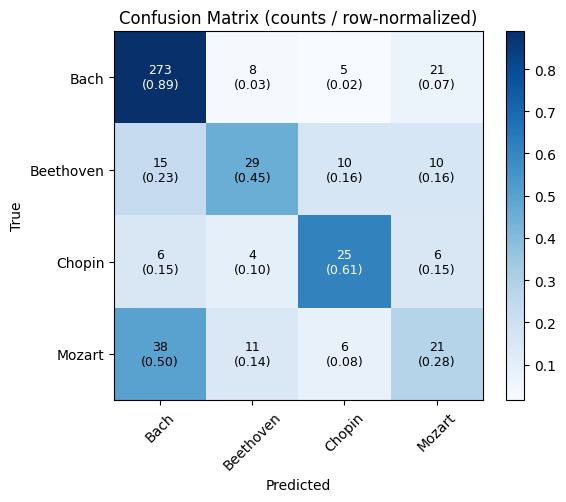

              precision    recall  f1-score   support

        Bach      0.822     0.889     0.854       307
   Beethoven      0.558     0.453     0.500        64
      Chopin      0.543     0.610     0.575        41
      Mozart      0.362     0.276     0.313        76

    accuracy                          0.713       488
   macro avg      0.571     0.557     0.561       488
weighted avg      0.692     0.713     0.700       488

     Bach: 0.889
Beethoven: 0.453
   Chopin: 0.610
   Mozart: 0.276
Top-2 accuracy: 0.859


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1) Collect true labels from the dataset
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# 2) Predict on the test set
y_prob = model.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(axis=1)

# 3) Confusion matrix (counts + normalized)
labels = ['Bach','Beethoven','Chopin','Mozart']
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

print("Confusion matrix (counts):\n", cm)

plt.figure(figsize=(6,5))
plt.imshow(cm_norm, cmap='Blues')
plt.colorbar()
plt.xticks(range(4), labels, rotation=45)
plt.yticks(range(4), labels)
for i in range(4):
    for j in range(4):
        plt.text(j, i, f"{cm[i,j]}\n({cm_norm[i,j]:.2f})",
                 ha='center', va='center',
                 color='white' if cm_norm[i,j] > 0.5 else 'black', fontsize=9)
plt.title('Confusion Matrix (counts / row-normalized)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()

# 4) Full classification report
print(classification_report(y_true, y_pred, target_names=labels, digits=3))

# (Optional) per-class accuracy quick view
per_class_acc = np.diag(cm) / cm.sum(axis=1)
for i, lab in enumerate(labels):
    print(f"{lab:>9}: {per_class_acc[i]:.3f}")

# (Optional) Top-2 accuracy
top2 = (np.argsort(y_prob, axis=1)[:, -2:] == y_true[:, None]).any(axis=1).mean()
print(f"Top-2 accuracy: {top2:.3f}")


In [ ]:
# === 1) EXTRA METADATA FEATURES ============================================
import numpy as np
import pretty_midi
from collections import Counter

def polyphony_stats(pm, fs=20):
    pr = pm.get_piano_roll(fs=fs) > 0
    notes_per_frame = pr.sum(axis=0).astype(np.float32)
    if notes_per_frame.size == 0:
        return 0., 0., 0.
    return float(notes_per_frame.mean()), float(notes_per_frame.std()), float(np.percentile(notes_per_frame, 90))

def articulation_ratio(seq):
    # seq columns: [pitch, dur, vel, rest, interval]
    if seq is None or len(seq)==0:
        return 0.
    dur = np.clip(seq[:,1], 0, None)
    rest = np.clip(seq[:,3], 0, None)
    denom = dur + rest
    denom[denom==0] = 1e-9
    return float(np.mean(dur / denom))

def leap_stats(seq, thresh=7):
    if seq is None or len(seq)==0:
        return 0., 0.
    iv = np.abs(seq[:,4])
    return float((iv >= thresh).mean()), float(iv.mean())

def pitch_range(seq):
    if seq is None or len(seq)==0:
        return 0.
    p = seq[:,0]
    return float(np.max(p) - np.min(p)) if p.size else 0.

def harmonic_rhythm(pm, fs=20):
    # chord changes per second
    pr = pm.get_piano_roll(fs=fs) > 0
    if pr.shape[1] < 2:
        return 0.
    pcs_prev = None
    changes = 0
    for t in range(pr.shape[1]):
        notes = np.where(pr[:,t])[0]
        pcs = tuple(sorted(set((notes % 12).tolist())))
        if pcs_prev is not None and pcs != pcs_prev:
            changes += 1
        pcs_prev = pcs
    duration_sec = pr.shape[1] / fs
    if duration_sec <= 0:
        return 0.
    return float(changes / duration_sec)

def add_extra_meta(df):
    extras = []
    for _, row in df.iterrows():
        try:
            pm = pretty_midi.PrettyMIDI(row['file_path'])
        except Exception:
            # fallbacks if loading fails
            extras.append(np.zeros(7, dtype=np.float32))
            continue
        seq = row.get('features_array', None)

        poly_mean, poly_std, poly_p90 = polyphony_stats(pm, fs=20)
        art = articulation_ratio(seq)
        leap_rate, mean_abs_iv = leap_stats(seq, thresh=7)
        prange = pitch_range(seq)
        harm_rate = harmonic_rhythm(pm, fs=20)

        extras.append(np.array(
            [poly_mean, poly_std, poly_p90, art, leap_rate, mean_abs_iv, prange],
            dtype=np.float32
        ))
    df['extra_meta'] = extras

# run on all splits (after your existing metadata extraction)
add_extra_meta(train_df)
add_extra_meta(val_df)
add_extra_meta(test_df)

# === 2) DATASET: append extra_meta to your generator =======================
import tensorflow as tf

N_NOTES   = 200
label_map = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}
num_ts    = len(time_sigs)   # from your earlier code
K         = len(top_chords)  # from your earlier code
EXTRA_D   = 7                # we just defined 7 extra features

def gen(df, shuffle=True):
    idxs = df.index.to_list()
    if shuffle: np.random.shuffle(idxs)
    for i in idxs:
        row = df.loc[i]
        seq = row['features_array']
        if seq is None: seq = np.zeros((0,5), dtype=np.float32)
        # pad/truncate to N_NOTES
        L = seq.shape[0]
        if L >= N_NOTES:
            seq2 = seq[:N_NOTES]
        else:
            pad = np.zeros((N_NOTES - L, 5), dtype=np.float32)
            seq2 = np.vstack([seq, pad])

        pitch_seq = seq2[:,0].astype(np.int32)
        num_seq   = seq2[:,1:5].astype(np.float32)

        bpm_m   = np.array([row['bpm_mean']], dtype=np.float32)
        bpm_s   = np.array([row['bpm_std']],  dtype=np.float32)
        ts_vec  = row['ts_onehot'].astype(np.float32)
        ent_val = np.array([row['entropy']],  dtype=np.float32)
        cf_vec  = row['chord_freqs'].astype(np.float32)
        extra   = row['extra_meta'].astype(np.float32)  # <— NEW (7,)

        y = label_map[row['composer']]
        yield (pitch_seq, num_seq, bpm_m, bpm_s, ts_vec, ent_val, cf_vec, extra), y

output_signature = (
    (
      tf.TensorSpec((N_NOTES,),   tf.int32),
      tf.TensorSpec((N_NOTES,4), tf.float32),
      tf.TensorSpec((1,),        tf.float32),
      tf.TensorSpec((1,),        tf.float32),
      tf.TensorSpec((num_ts,),    tf.float32),
      tf.TensorSpec((1,),        tf.float32),
      tf.TensorSpec((K,),        tf.float32),
      tf.TensorSpec((EXTRA_D,),  tf.float32),   # <— NEW
    ),
    tf.TensorSpec((), tf.int32)
)

def make_ds(df, batch_size=32, training=True):
    ds = tf.data.Dataset.from_generator(lambda: gen(df, shuffle=training),
                                        output_signature=output_signature)
    if training:
        ds = ds.shuffle(len(df))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_df, 32, True)
val_ds   = make_ds(val_df,   32, False)
test_ds  = make_ds(test_df,  32, False)

# === 3) MODEL: add an `extra_meta` input and concatenate ===================
from tensorflow.keras.layers import Input, Embedding, Concatenate, Bidirectional, LSTM, Dropout, Dense, Layer
from tensorflow.keras.models import Model

class AttentionLayer(Layer):
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform', trainable=True)
        self.V = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        super().build(input_shape)
    def call(self, x):
        s = tf.tensordot(x, self.W, axes=[2,0])
        s = tf.tanh(s)
        s = tf.tensordot(s, self.V, axes=[2,0])
        a = tf.nn.softmax(s, axis=1)
        return tf.reduce_sum(a * x, axis=1)

pitch_in = Input((N_NOTES,),   dtype='int32',   name='pitch_in')
num_in   = Input((N_NOTES,4),  dtype='float32', name='num_in')
bpm_m    = Input((1,),         dtype='float32', name='bpm_mean')
bpm_s    = Input((1,),         dtype='float32', name='bpm_std')
ts_in    = Input((num_ts,),    dtype='float32', name='time_sig')
ent_in   = Input((1,),         dtype='float32', name='entropy')
cf_in    = Input((K,),         dtype='float32', name='chord_freqs')
extra_in = Input((EXTRA_D,),   dtype='float32', name='extra_meta')  # <— NEW

# sequence branch
x = Embedding(128, 32)(pitch_in)
x = Concatenate()([x, num_in])
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
seq_feat = AttentionLayer()(x)

# metadata branch
md = Concatenate()([bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in])  # <— include new extras
md = Dense(64, activation='relu')(md)
md = Dropout(0.3)(md)

# merge
z = Concatenate()([seq_feat, md])
z = Dense(64, activation='relu')(z)
z = Dropout(0.4)(z)
out = Dense(4, activation='softmax')(z)

model = Model(
    inputs=[pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in],
    outputs=out
)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# === 4) Train like before (class weights, callbacks) =======================
from sklearn.utils import class_weight
y_train = train_df['composer'].map(label_map).values
cw_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = {i: w for i, w in enumerate(cw_array)}

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.EarlyStopping('val_loss', patience=6, restore_best_weights=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=60,
                    class_weight=cw, callbacks=callbacks)

loss, acc = model.evaluate(test_ds)
print(f"New test accuracy: {acc:.4%}")


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 200, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 200, 36)   │          0 │ embedding_3[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_mean            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_std             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_sig            │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chord_freqs         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_meta          │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 200, 128)  │     51,712 │ concatenate_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 68)        │          0 │ bpm_mean[0][0],   │
│ (Concatenate)       │                   │            │ bpm_std[0][0],    │
│                     │                   │            │ time_sig[0][0],   │
│                     │                   │            │ entropy[0][0],    │
│                     │                   │            │ chord_freqs[0][0… │
│                     │                   │            │ extra_meta[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 200, 64)   │     41,216 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      4,416 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_3   │ (None, 64)        │      4,160 │ bidirectional_7[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 114,116 (445.77 KB)

 Trainable params: 114,116 (445.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
     27/Unknown 6s 32ms/step - accuracy: 0.2096 - loss: 9.0416

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.2107 - loss: 8.9521 - val_accuracy: 0.1061 - val_loss: 2.7357 - learning_rate: 0.0010
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2674 - loss: 4.5161 - val_accuracy: 0.2245 - val_loss: 1.4539 - learning_rate: 0.0010
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3231 - loss: 2.5467 - val_accuracy: 0.4735 - val_loss: 1.2870 - learning_rate: 0.0010
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2556 - loss: 2.2363 - val_accuracy: 0.4490 - val_loss: 1.3963 - learning_rate: 0.0010
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2584 - loss: 1.7127 - val_accuracy: 0.3184 - val_loss: 1.3759 - learning_rate: 0.0010
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2763 - loss: 1.5591 - val_accuracy: 0.5837 - val_loss: 1.3562 - learning_rate: 0.0010
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3293 - loss: 1.4428 - val_accuracy: 0.60

In [ ]:
model = Model(
    inputs=[pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in],
    outputs=out
)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# === 4) Train like before (class weights, callbacks) =======================
from sklearn.utils import class_weight
y_train = train_df['composer'].map(label_map).values
cw_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = {i: w for i, w in enumerate(cw_array)}

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.EarlyStopping('val_loss', patience=6, restore_best_weights=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=60,
                    class_weight=cw, callbacks=callbacks)

loss, acc = model.evaluate(test_ds)
print(f"New test accuracy: {acc:.4%}")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 200, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 200, 36)   │          0 │ embedding_3[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_mean            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_std             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_sig            │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chord_freqs         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_meta          │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 200, 128)  │     51,712 │ concatenate_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 68)        │          0 │ bpm_mean[0][0],   │
│ (Concatenate)       │                   │            │ bpm_std[0][0],    │
│                     │                   │            │ time_sig[0][0],   │
│                     │                   │            │ entropy[0][0],    │
│                     │                   │            │ chord_freqs[0][0… │
│                     │                   │            │ extra_meta[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 200, 64)   │     41,216 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      4,416 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_3   │ (None, 64)        │      4,160 │ bidirectional_7[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 114,116 (445.77 KB)

 Trainable params: 114,116 (445.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
     27/Unknown 6s 32ms/step - accuracy: 0.3337 - loss: 2.1113

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.3315 - loss: 2.0971 - val_accuracy: 0.5102 - val_loss: 1.3367 - learning_rate: 0.0010
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2898 - loss: 1.7514 - val_accuracy: 0.4041 - val_loss: 1.3907 - learning_rate: 0.0010
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.2749 - loss: 1.5660 - val_accuracy: 0.5388 - val_loss: 1.3519 - learning_rate: 0.0010
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3572 - loss: 1.3840 - val_accuracy: 0.5633 - val_loss: 1.3662 - learning_rate: 0.0010
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3134 - loss: 1.4838 - val_accuracy: 0.5633 - val_loss: 1.3654 - learning_rate: 5.0000e-04
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3502 - loss: 1.4005 - val_accuracy: 0.5469 - val_loss: 1.3609 - learning_rate: 5.0000e-04
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4251 - loss: 1.3145 - val_accura

Why these help (targeted to your errors)
Bach vs Mozart: polyphony stats + articulation ratio + harmonic rhythm should make Bach’s contrapuntal texture pop vs Mozart’s cleaner homophony.

Beethoven: broader range, leap rate, and harmonic rhythm often increase, helping recall for pieces your model was splitting between Bach/Mozart.

Chopin: you already capture chromaticism via entropy; leap stats and articulation should help further.

If you want, we can also turn transpose augmentation back on (±2 semitones) in the generator for extra robustness; it often adds a couple of points.

In [ ]:
import numpy as np, tensorflow as tf
from math import ceil
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Embedding, Concatenate, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, Layer
from tensorflow.keras.models import Model

# ------------------ 1) Standardize meta features (train-only) ------------------
def stack_meta_vec(row):
    # [bpm_mean, bpm_std, entropy, 7 extra_meta]
    return np.concatenate([
        np.array([row['bpm_mean'], row['bpm_std'], row['entropy']], dtype=np.float32),
        row['extra_meta'].astype(np.float32)
    ])

META_D = 3 + 7
meta_train = np.stack([stack_meta_vec(r) for _, r in train_df.iterrows()])
MU  = meta_train.mean(axis=0).astype(np.float32)
SIG = (meta_train.std(axis=0) + 1e-8).astype(np.float32)

# ------------------ 2) tf.data with normalization + augmentation ---------------
N_NOTES   = 200
label_map = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}
num_ts    = train_df.iloc[0]['ts_onehot'].shape[0]
K         = train_df.iloc[0]['chord_freqs'].shape[0]

def make_ds(df, batch=32, training=True, transpose=2, jitter=0.05):
    def gen():
        idxs = df.index.to_list()
        if training: np.random.shuffle(idxs)
        for i in idxs:
            row = df.loc[i]
            seq = row['features_array']
            if seq is None: seq = np.zeros((0,5), dtype=np.float32)

            # pad/truncate to N_NOTES
            L = seq.shape[0]
            if L >= N_NOTES:
                seq2 = seq[:N_NOTES].copy()
            else:
                pad = np.zeros((N_NOTES - L, 5), dtype=np.float32)
                seq2 = np.vstack([seq, pad])

            # augmentation (training only): transpose pitch + jitter dur/vel
            if training and transpose > 0:
                shift = np.random.randint(-transpose, transpose+1)
                seq2[:,0] = np.clip(seq2[:,0] + shift, 0, 127)  # pitch only
                # interval stays invariant under transposition, do NOT shift col 4
                dur_j = 1 + np.random.uniform(-jitter, jitter, size=(N_NOTES,))
                vel_j = 1 + np.random.uniform(-jitter, jitter, size=(N_NOTES,))
                seq2[:,1] *= dur_j
                seq2[:,2] = np.clip(seq2[:,2] * vel_j, 0., 1.)

            pitch_seq = seq2[:,0].astype(np.int32)
            num_seq   = seq2[:,1:5].astype(np.float32)

            ts_vec  = row['ts_onehot'].astype(np.float32)
            cf_vec  = row['chord_freqs'].astype(np.float32)

            meta_raw = stack_meta_vec(row)
            meta_z   = (meta_raw - MU) / SIG   # standardize
            bpm_m = meta_z[0:1]; bpm_s = meta_z[1:2]; ent = meta_z[2:3]; extra = meta_z[3:]

            y = label_map[row['composer']]
            yield (pitch_seq, num_seq, bpm_m, bpm_s, ts_vec, ent, cf_vec, extra), y

    output_signature = (
        (
            tf.TensorSpec((N_NOTES,),  tf.int32),
            tf.TensorSpec((N_NOTES,4), tf.float32),
            tf.TensorSpec((1,),        tf.float32),  # bpm_mean (z)
            tf.TensorSpec((1,),        tf.float32),  # bpm_std (z)
            tf.TensorSpec((num_ts,),   tf.float32),  # time sig 1-hot
            tf.TensorSpec((1,),        tf.float32),  # entropy (z)
            tf.TensorSpec((K,),        tf.float32),  # chord freqs
            tf.TensorSpec((7,),        tf.float32),  # extra_meta (z)
        ),
        tf.TensorSpec((), tf.int32)
    )

    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if training:
        ds = ds.shuffle(len(df)).repeat()
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_df, 32, True)
val_ds   = make_ds(val_df,   32, False)
test_ds  = make_ds(test_df,  32, False)

# steps to avoid "ran out of data" warning
steps_per_epoch    = ceil(len(train_df)/32)
validation_steps   = ceil(len(val_df)/32)

# ------------------ 3) Model (BN + light L2 on meta branch) --------------------
class AttentionLayer(Layer):
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.V = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        super().build(input_shape)
    def call(self, x):
        s = tf.tensordot(x, self.W, axes=[2,0]); s = tf.tanh(s)
        s = tf.tensordot(s, self.V, axes=[2,0])
        a = tf.nn.softmax(s, axis=1)
        return tf.reduce_sum(a * x, axis=1)

pitch_in = Input((N_NOTES,),   dtype='int32',   name='pitch_in')
num_in   = Input((N_NOTES,4),  dtype='float32', name='num_in')
bpm_m    = Input((1,),         dtype='float32', name='bpm_mean_z')
bpm_s    = Input((1,),         dtype='float32', name='bpm_std_z')
ts_in    = Input((num_ts,),    dtype='float32', name='time_sig')
ent_in   = Input((1,),         dtype='float32', name='entropy_z')
cf_in    = Input((K,),         dtype='float32', name='chord_freqs')
extra_in = Input((7,),         dtype='float32', name='extra_meta_z')

# sequence branch
x = Embedding(128, 32)(pitch_in)
x = Concatenate()([x, num_in])
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
seq_feat = AttentionLayer()(x)

# metadata branch
md = Concatenate()([bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in])
md = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(md)
md = BatchNormalization()(md)
md = Dropout(0.3)(md)

# merge
z = Concatenate()([seq_feat, md])
z = Dense(64, activation='relu')(z)
z = Dropout(0.4)(z)
out = Dense(4, activation='softmax')(z)

model = Model([pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in], out)
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# class weights
from sklearn.utils import class_weight
y_train = train_df['composer'].map(label_map).values
cw_arr = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = {i: w for i, w in enumerate(cw_arr)}

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.5),
    tf.keras.callbacks.EarlyStopping('val_loss', patience=6, restore_best_weights=True),
]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=60,
                    class_weight=cw,
                    callbacks=callbacks)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy (normalized meta): {test_acc:.4f}")


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 200, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 200, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_mean_z          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_std_z           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_sig            │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy_z           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chord_freqs         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_meta_z        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 200, 36)   │          0 │ embedding_4[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 68)        │          0 │ bpm_mean_z[0][0], │
│ (Concatenate)       │                   │            │ bpm_std_z[0][0],  │
│                     │                   │            │ time_sig[0][0],   │
│                     │                   │            │ entropy_z[0][0],  │
│                     │                   │            │ chord_freqs[0][0… │
│                     │                   │            │ extra_meta_z[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 200, 128)  │     51,712 │ concatenate_8[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,416 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 200, 64)   │     41,216 │ bidirectional_8[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_4   │ (None, 64)        │      4,160 │ bidirectional_9[… │
│ (AttentionLayer)    │                   │            │                 

 Total params: 114,372 (446.77 KB)

 Trainable params: 114,244 (446.27 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.3436 - loss: 1.9618 - val_accuracy: 0.5510 - val_loss: 1.2478 - learning_rate: 5.0000e-04
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5034 - loss: 1.5423 - val_accuracy: 0.6449 - val_loss: 1.1419 - learning_rate: 5.0000e-04
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5960 - loss: 1.2848 - val_accuracy: 0.6490 - val_loss: 1.0568 - learning_rate: 5.0000e-04
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6134 - loss: 1.2135 - val_accuracy: 0.5959 - val_loss: 1.0704 - learning_rate: 5.0000e-04
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5676 - loss: 1.1971 - val_accuracy: 0.7143 - val_loss: 0.9081 - learning_rate: 5.0000e-04
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6388 - loss: 1.0665 - val_accuracy: 0.6816 - val_loss: 0.9079 - learning_rate: 5.0000e-04
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6454 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


76.8% test is a big jump — the normalized meta features clearly helped.

Next: sanity-check where the wins/losses are and see which features matter. Here’s a single block to:

make the confusion matrix + classification report

compute top-2 accuracy

run quick ablations (zero out extra_meta / chord_freqs / all meta) to see impact

python
Copy
Edit


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


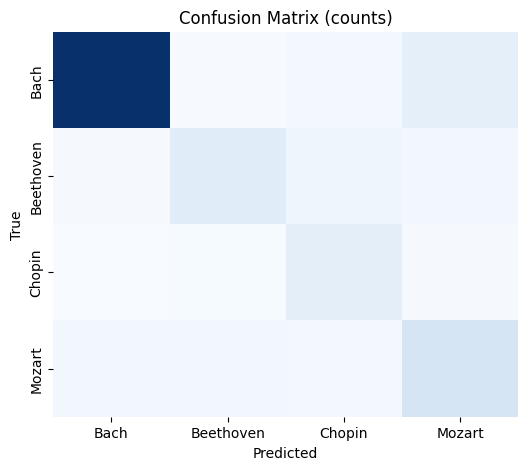

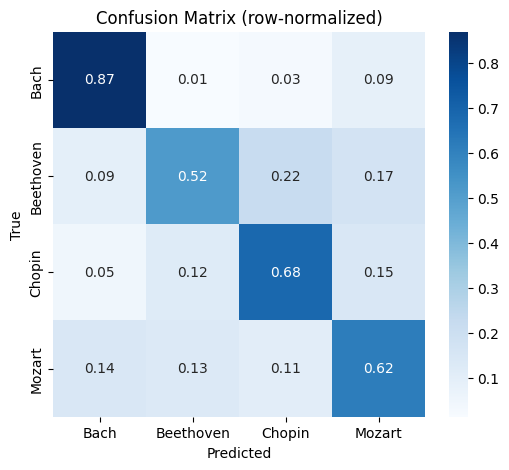

              precision    recall  f1-score   support

        Bach       0.93      0.87      0.90       307
   Beethoven       0.63      0.52      0.57        64
      Chopin       0.47      0.68      0.56        41
      Mozart       0.52      0.62      0.56        76

    accuracy                           0.77       488
   macro avg       0.64      0.67      0.65       488
weighted avg       0.79      0.77      0.78       488

Top-2 accuracy: 0.9221

Ablation: no extra_meta


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.822964072227478, 0.6413934230804443]
Ablation: no chord_freqs
[0.6041243672370911, 0.7581967115402222]
Ablation: sequence-only (all meta zeroed)
[1.013311505317688, 0.6004098653793335]


In [ ]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1) Collect y_true and predictions ---
label_map = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}
idx2lab = {v:k for k,v in label_map.items()}

# model, test_ds already in memory
probs = model.predict(test_ds)
y_pred = probs.argmax(axis=1)

# get ground-truth ints from the dataset
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# --- 2) Confusion matrix (counts + row-normalized overlay) ---
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(min=1)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=False,
            xticklabels=[idx2lab[i] for i in range(4)],
            yticklabels=[idx2lab[i] for i in range(4)])
plt.title("Confusion Matrix (counts)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=[idx2lab[i] for i in range(4)],
            yticklabels=[idx2lab[i] for i in range(4)])
plt.title("Confusion Matrix (row-normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# --- 3) Classification report + top-2 accuracy ---
print(classification_report(y_true, y_pred, target_names=[idx2lab[i] for i in range(4)]))

top2 = np.argsort(probs, axis=1)[:, -2:]
top2_acc = (top2[:,0] == y_true) | (top2[:,1] == y_true)
print(f"Top-2 accuracy: {top2_acc.mean():.4f}")

# --- 4) Quick ablations to see what helps most ----------------------------
def zero_extra(x, y):
    pitch,num,bpm_m,bpm_s,ts,ent,cf,extra = x
    extra = tf.zeros_like(extra)
    return (pitch,num,bpm_m,bpm_s,ts,ent,cf,extra), y

def zero_chords(x, y):
    pitch,num,bpm_m,bpm_s,ts,ent,cf,extra = x
    cf = tf.zeros_like(cf)
    return (pitch,num,bpm_m,bpm_s,ts,ent,cf,extra), y

def zero_all_meta(x, y):
    pitch,num,bpm_m,bpm_s,ts,ent,cf,extra = x
    z1 = tf.zeros_like(bpm_m); z2 = tf.zeros_like(bpm_s)
    zts = tf.zeros_like(ts); zent = tf.zeros_like(ent)
    zcf = tf.zeros_like(cf); zextra = tf.zeros_like(extra)
    return (pitch,num,z1,z2,zts,zent,zcf,zextra), y

print("\nAblation: no extra_meta")
print(model.evaluate(test_ds.map(zero_extra), verbose=0))

print("Ablation: no chord_freqs")
print(model.evaluate(test_ds.map(zero_chords), verbose=0))

print("Ablation: sequence-only (all meta zeroed)")
print(model.evaluate(test_ds.map(zero_all_meta), verbose=0))


Big takeaways from your ablations:

extra_meta matters a lot (dropping it → 64%).

chord histograms help, but less so (→ 75.8%).

sequence-only tanks (→ 60%).

Confusions are mostly Beethoven↔Chopin/Mozart. Bach is solid.

Top-2 accuracy 92% = we’re close; a couple small tricks should push past 80.

Below is a minimal patch to squeeze more accuracy:

What this does
Balanced sampling (oversample Beethoven/Mozart/Chopin to match Bach).

Label smoothing (0.05).

Slightly more capacity + context (N_NOTES=256, embed 64, LSTM 96/48).

Stronger augmentation (transpose ±3, velocity/duration jitter ±10%).

Run this after your normalized-meta setup (i.e., after you have train_df/val_df/test_df, MU, SIG, and the stack_meta_vec helper from earlier).

In [ ]:
# ============================
# PREPROCESS BOOTSTRAP (Colab)
# ============================
!pip -q install pretty_midi

import os, numpy as np, pandas as pd, pretty_midi, math
from sklearn.model_selection import train_test_split
from collections import Counter

# ---- paths ----
DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'
assert os.path.exists(DATA_ROOT), "Mount Drive and check DATA_ROOT."

# ---- crawl recursively ----
records = []
for root, _, files in os.walk(DATA_ROOT):
    for f in files:
        if f.lower().endswith(('.mid', '.midi')):
            path = os.path.join(root, f)
            composer = os.path.relpath(root, DATA_ROOT).split(os.sep)[0]
            records.append({'composer': composer, 'file': f, 'file_path': path})

df = pd.DataFrame(records).query("composer in ['Bach','Beethoven','Chopin','Mozart']").reset_index(drop=True)
print(f"Found {len(df)} MIDI files across 4 composers.")

# ---- token_count for length bins (robust; skip errors) ----
def safe_token_count(path):
    try:
        pm = pretty_midi.PrettyMIDI(path)
        return sum(len(inst.notes) for inst in pm.instruments)
    except Exception:
        return np.nan

df['token_count'] = df['file_path'].apply(safe_token_count)
df = df.dropna(subset=['token_count']).reset_index(drop=True)
df['token_count'] = df['token_count'].astype(int)

# ---- length bins + singleton fix ----
bins   = [0, 1000, 4000, df['token_count'].max()+1]  # short/med/long
labels = ['short','medium','long']
df['length_bin']     = pd.cut(df['token_count'], bins=bins, labels=labels, include_lowest=True)
df['stratify_label'] = df['composer'] + '_' + df['length_bin'].astype(str)

counts = df['stratify_label'].value_counts()
rare   = counts[counts < 2].index.tolist()
if len(rare):
    df.loc[df['stratify_label'].isin(rare), 'length_bin'] = 'medium'
    df['stratify_label'] = df['composer'] + '_' + df['length_bin'].astype(str)

# ---- stratified split: 70/15/15 ----
train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=42, stratify=df['stratify_label']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df['stratify_label']
)
print("Split sizes:", len(train_df), len(val_df), len(test_df))

# =========================
# Feature extraction utils
# =========================

NUM_SET = list(range(1,13))            # time-signature numerators 1..12
DEN_SET = [1,2,4,8]                    # denominators
TS_DIM  = len(NUM_SET)*len(DEN_SET)    # 48

CHORD_TEMPLATES = {
    'maj'   : {0,4,7},
    'min'   : {0,3,7},
    'dim'   : {0,3,6},
    'aug'   : {0,4,8},
    'sus2'  : {0,2,7},
    'sus4'  : {0,5,7},
    'dom7'  : {0,4,7,10},
    'maj7'  : {0,4,7,11},
    'min7'  : {0,3,7,10},
    'hdim7' : {0,3,6,10},  # half-diminished
}
CHORD_KEYS = list(CHORD_TEMPLATES.keys())
CHORD_DIM  = len(CHORD_KEYS)

def ts_onehot(pm):
    vec = np.zeros(TS_DIM, dtype=np.float32)
    try:
        if len(pm.time_signature_changes) == 0:
            return vec
        num = pm.time_signature_changes[0].numerator
        den = pm.time_signature_changes[0].denominator
        if num in NUM_SET and den in DEN_SET:
            i = NUM_SET.index(num)
            j = DEN_SET.index(den)
            vec[i*len(DEN_SET)+j] = 1.0
    except Exception:
        pass
    return vec

def piano_roll(pm, fs=10):
    # 10 frames/sec is enough for coarse chord stats
    try:
        pr = pm.get_piano_roll(fs=fs)  # (128, T), velocities
        return (pr > 0).astype(np.float32)
    except Exception:
        return np.zeros((128,0), dtype=np.float32)

def chord_freqs_from_roll(pr):
    # map each frame to a pitch-class set and vote to nearest simple template
    if pr.shape[1] == 0:
        return np.zeros(CHORD_DIM, dtype=np.float32)
    counts = np.zeros(CHORD_DIM, dtype=np.float32)
    pc_roll = (np.where(pr > 0)[0] % 12, np.where(pr > 0)[1])  # (pcs, frames)
    # build active pc set per frame quickly
    T = pr.shape[1]
    active = [set() for _ in range(T)]
    for p, t in zip(*pc_roll):
        active[t].add(int(p))

    for pcs in active:
        if len(pcs) < 3:
            continue
        # normalize to root 0 class by testing all transpositions, pick best template
        best_key, best_score = None, -1
        for name, tmpl in CHORD_TEMPLATES.items():
            # find any transposition that maximizes overlap
            score = 0
            for r in range(12):
                trans = {(pc - r) % 12 for pc in pcs}
                score = max(score, len(trans & tmpl) / max(1, len(tmpl)))
            if score > best_score:
                best_score, best_key = score, name
        if best_key is not None:
            counts[CHORD_KEYS.index(best_key)] += 1.0

    s = counts.sum()
    return counts / s if s > 0 else counts

def pitch_class_entropy(pm):
    hist = np.zeros(12, dtype=np.float32)
    try:
        for inst in pm.instruments:
            for n in inst.notes:
                hist[n.pitch % 12] += 1
        if hist.sum() == 0:
            return 0.0
        p = hist / hist.sum()
        p = p[p > 0]
        return float(-(p * np.log(p)).sum())
    except Exception:
        return 0.0

def extract_note_seq(pm):
    # returns (N,5): pitch, dur(sec), vel(0..1), rest(sec), interval(semitones)
    events = []
    for inst in pm.instruments:
        for n in inst.notes:
            events.append((n.start, n.pitch, n.end - n.start, n.velocity/127.0))
    if not events:
        return np.zeros((0,5), dtype=np.float32)
    events.sort(key=lambda x: x[0])
    seq = []
    prev_pitch = events[0][1]
    prev_end   = events[0][0]
    for start, pitch, dur, vel in events:
        rest = max(0.0, start - prev_end)
        interval = pitch - prev_pitch
        seq.append((pitch, dur, vel, rest, interval))
        prev_pitch = pitch
        prev_end   = start + dur
    return np.array(seq, dtype=np.float32)

def bpm_stats(pm):
    try:
        _, tempi = pm.get_tempo_changes()
        if len(tempi) == 0:
            return 0.0, 0.0
        bpms = 60.0 / (tempi / 1e6) if tempi.max() > 1000 else tempi  # pretty_midi can return BPM directly
        return float(np.mean(bpms)), float(np.std(bpms))
    except Exception:
        return 0.0, 0.0

def extra_meta_from(pm, seq):
    # 7 dims: note_density, polyphony_rate, dur_mean, dur_std, vel_mean, vel_std, rest_mean
    try:
        total_dur = pm.get_end_time() if pm.get_end_time() > 0 else max(1e-6, seq[:,1].sum())
    except Exception:
        total_dur = max(1e-6, seq[:,1].sum())
    note_density = (len(seq) / total_dur) if total_dur > 0 else 0.0

    pr = piano_roll(pm, fs=10)
    polyphony_rate = 0.0
    if pr.shape[1] > 0:
        polyphony_rate = float((pr.sum(axis=0) > 1).mean())

    dur_mean = float(seq[:,1].mean()) if len(seq) else 0.0
    dur_std  = float(seq[:,1].std())  if len(seq) else 0.0
    vel_mean = float(seq[:,2].mean()) if len(seq) else 0.0
    vel_std  = float(seq[:,2].std())  if len(seq) else 0.0
    rest_mean= float(seq[:,3].mean()) if len(seq) else 0.0

    return np.array([note_density, polyphony_rate, dur_mean, dur_std, vel_mean, vel_std, rest_mean],
                    dtype=np.float32)

def extract_all(path):
    # robust: skip files that explode
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except Exception:
        return None
    seq = extract_note_seq(pm)                       # (N,5)
    bpm_mean, bpm_std = bpm_stats(pm)
    ts_vec = ts_onehot(pm)                           # (48,)
    ent    = pitch_class_entropy(pm)                 # float
    pr     = piano_roll(pm, fs=10)
    chordf = chord_freqs_from_roll(pr)               # (10,)
    extra  = extra_meta_from(pm, seq)                # (7,)
    return dict(
        features_array=seq,
        bpm_mean=bpm_mean, bpm_std=bpm_std,
        ts_onehot=ts_vec, entropy=ent,
        chord_freqs=chordf, extra_meta=extra
    )

def add_features(df_in):
    rows = []
    dropped = 0
    for _, r in df_in.iterrows():
        feat = extract_all(r['file_path'])
        if feat is None or feat['features_array'].shape[0] == 0:
            dropped += 1
            continue
        row = dict(r)
        row.update(feat)
        rows.append(row)
    out = pd.DataFrame(rows)
    print(f"Dropped {dropped} bad/empty MIDI files.")
    return out.reset_index(drop=True)

# ---- extract for each split ----
train_df = add_features(train_df)
val_df   = add_features(val_df)
test_df  = add_features(test_df)

# (Optional) save to speed future restarts
train_df.to_pickle('/content/train_features.pkl')
val_df.to_pickle('/content/val_features.pkl')
test_df.to_pickle('/content/test_features.pkl')

print("Ready: train_df/val_df/test_df with feature columns.")
print(train_df.columns.tolist())
print("Example row shapes:",
      train_df['features_array'].iloc[0].shape,
      train_df['ts_onehot'].iloc[0].shape,
      train_df['chord_freqs'].iloc[0].shape,
      train_df['extra_meta'].iloc[0].shape)


Found 1630 MIDI files across 4 composers.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Split sizes: 1139 244 245


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Dropped 0 bad/empty MIDI files.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Dropped 0 bad/empty MIDI files.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Dropped 0 bad/empty MIDI files.
Ready: train_df/val_df/test_df with feature columns.
['composer', 'file', 'file_path', 'token_count', 'length_bin', 'stratify_label', 'features_array', 'bpm_mean', 'bpm_std', 'ts_onehot', 'entropy', 'chord_freqs', 'extra_meta']
Example row shapes: (1821, 5) (48,) (10,) (7,)


In [ ]:
# ============================== #
# Multi-input Sequence + Model   #
# ============================== #
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

train_df = pd.read_pickle('/content/train_features.pkl')
val_df   = pd.read_pickle('/content/val_features.pkl')
test_df  = pd.read_pickle('/content/test_features.pkl')

# ---- constants ----
N_CLASSES = 4
N_NOTES   = 256
BATCH     = 32
TRANSPOSE = 3
JITTER    = 0.10

# pull dims from your DF rows
TS_DIM     = int(train_df['ts_onehot'].iloc[0].shape[0])     # e.g. 48
CHORD_DIM  = int(train_df['chord_freqs'].iloc[0].shape[0])   # e.g. 10
EXTRA_DIM  = 7
label_map  = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}

# ---- compute MU/SIG over meta (bpm_mean, bpm_std, entropy, extra_meta[7]) ----
def row_meta_vec(row):
    base = np.array([row['bpm_mean'], row['bpm_std'], row['entropy']], dtype=np.float32)
    ex   = row['extra_meta'].astype(np.float32)
    if ex.shape[0] < EXTRA_DIM:
        ex = np.pad(ex, (0, EXTRA_DIM-ex.shape[0]))
    else:
        ex = ex[:EXTRA_DIM]
    return np.concatenate([base, ex], axis=0)  # (3 + EXTRA_DIM,)

meta_mat = np.stack([row_meta_vec(r) for _, r in train_df.iterrows()], axis=0)
MU  = meta_mat.mean(axis=0).astype(np.float32)
SIG = meta_mat.std(axis=0).astype(np.float32)
SIG = np.where(SIG==0, 1.0, SIG).astype(np.float32)

# ---- helpers ----
def pad_or_truncate(seq, N=N_NOTES):
    """seq: (L,5) -> (N,5) [pitch,dur,vel,rest,interval]"""
    if seq is None:
        return np.zeros((N,5), dtype=np.float32)
    seq = np.asarray(seq, dtype=np.float32)
    L = seq.shape[0]
    if L >= N:
        return seq[:N].copy()
    out = np.zeros((N,5), dtype=np.float32)
    out[:L] = seq
    return out

def balance_indices(y):
    classes, counts = np.unique(y, return_counts=True)
    m = counts.max()
    idxs = np.concatenate([
        np.random.choice(np.where(y==c)[0], size=m, replace=True) for c in classes
    ])
    np.random.shuffle(idxs)
    return idxs

# ---- Sequence that returns a DICT keyed by input names ----
class BalancedMultiInputSequence(Sequence):
    def __init__(self, df, mu, sig, training=True, batch_size=BATCH, **kwargs):
        super().__init__(**kwargs)          # <- important in Keras 3
        self.df = df.reset_index(drop=True)
        self.mu = mu.astype(np.float32)
        self.sig = sig.astype(np.float32)
        self.training = training
        self.batch_size = batch_size
        self.y_int = self.df['composer'].map(label_map).values.astype(np.int32)
        self.on_epoch_end()

    def __len__(self):
        return (len(self.idxs) + self.batch_size - 1) // self.batch_size

    def on_epoch_end(self):
        self.idxs = balance_indices(self.y_int) if self.training else np.arange(len(self.df))

    def __getitem__(self, i):
        batch_idxs = self.idxs[i*self.batch_size:(i+1)*self.batch_size]
        n = len(batch_idxs)

        pitch = np.zeros((n, N_NOTES),    dtype=np.int32)
        num   = np.zeros((n, N_NOTES, 4), dtype=np.float32)
        bpm_m = np.zeros((n, 1),          dtype=np.float32)
        bpm_s = np.zeros((n, 1),          dtype=np.float32)
        ts    = np.zeros((n, TS_DIM),     dtype=np.float32)
        ent   = np.zeros((n, 1),          dtype=np.float32)
        cf    = np.zeros((n, CHORD_DIM),  dtype=np.float32)
        extra = np.zeros((n, EXTRA_DIM),  dtype=np.float32)
        y     = np.zeros((n,),            dtype=np.int32)

        for j, idx in enumerate(batch_idxs):
            row = self.df.iloc[idx]
            seq = pad_or_truncate(row['features_array'], N_NOTES)  # (N,5)

            if self.training:
                # transpose pitch
                shift = np.random.randint(-TRANSPOSE, TRANSPOSE+1)
                seq[:,0] = np.clip(seq[:,0] + shift, 0, 127)
                # jitter dur & vel
                dj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                vj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                seq[:,1] *= dj
                seq[:,2] = np.clip(seq[:,2]*vj, 0., 1.)

            pitch[j] = seq[:,0].astype(np.int32)
            num[j]   = seq[:,1:5].astype(np.float32)

            # meta -> z-norm
            mvec = row_meta_vec(row)                     # (3+EXTRA_DIM,)
            mz   = (mvec - self.mu) / self.sig
            bpm_m[j,0] = mz[0]; bpm_s[j,0] = mz[1]; ent[j,0] = mz[2]
            extra[j]   = mz[3:3+EXTRA_DIM]

            # onehots/freqs (ensure fixed dims)
            tsv = np.asarray(row['ts_onehot'],   dtype=np.float32)
            cfv = np.asarray(row['chord_freqs'], dtype=np.float32)
            if tsv.shape[0] != TS_DIM:     tsv = np.pad(tsv, (0, TS_DIM - tsv.shape[0]))[:TS_DIM]
            if cfv.shape[0] != CHORD_DIM:  cfv = np.pad(cfv, (0, CHORD_DIM - cfv.shape[0]))[:CHORD_DIM]
            ts[j] = tsv
            cf[j] = cfv

            y[j] = label_map[row['composer']]

        return (
            {
                "pitch_in":    pitch,
                "num_in":      num,
                "bpm_mean":    bpm_m,
                "bpm_std":     bpm_s,
                "time_sig":    ts,
                "entropy":     ent,
                "chord_freqs": cf,
                "extra_meta":  extra,
            },
            y,
        )

# ---- build the multi-input model (names must match dict keys) ----
def build_model(
    n_notes=N_NOTES, ts_dim=TS_DIM, chord_dim=CHORD_DIM, extra_dim=EXTRA_DIM,
    embed_dim=32, lstm1=64, lstm2=32, drop=0.3
):
    pitch_in  = tf.keras.Input(shape=(n_notes,),    dtype=tf.int32,   name="pitch_in")
    num_in    = tf.keras.Input(shape=(n_notes, 4),  dtype=tf.float32, name="num_in")
    bpm_m     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_mean")
    bpm_s     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_std")
    ts_in     = tf.keras.Input(shape=(ts_dim,),     dtype=tf.float32, name="time_sig")
    ent_in    = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="entropy")
    cf_in     = tf.keras.Input(shape=(chord_dim,),  dtype=tf.float32, name="chord_freqs")
    extra_in  = tf.keras.Input(shape=(extra_dim,),  dtype=tf.float32, name="extra_meta")

    emb = tf.keras.layers.Embedding(input_dim=128, output_dim=embed_dim)(pitch_in)
    x   = tf.keras.layers.Concatenate()([emb, num_in])  # (B, n_notes, embed+4)

    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1, return_sequences=True))(x)
    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2, return_sequences=True))(x)

    # light attention (global additive)
    score = tf.keras.layers.Dense(1)(x)                         # (B,T,1)
    attn  = tf.keras.layers.Softmax(axis=1)(score)              # (B,T,1)
    xsum  = tf.keras.layers.Multiply()([x, attn])
    xsum  = tf.keras.layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(xsum)  # (B, 2*lstm2)

    meta = tf.keras.layers.Concatenate()([bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in])
    meta = tf.keras.layers.Dense(64, activation='relu')(meta)

    h = tf.keras.layers.Concatenate()([xsum, meta])
    h = tf.keras.layers.Dense(64, activation='relu')(h)
    h = tf.keras.layers.Dropout(drop)(h)
    out = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(h)

    model = tf.keras.Model(
        inputs=[pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in],
        outputs=out
    )
    return model

model = build_model()
# label smoothing for sparse targets
cce = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
def smoothed_sparse_cce(y_true, y_pred):
    y_true = tf.cast(tf.squeeze(y_true), tf.int32)
    y_oh   = tf.one_hot(y_true, depth=N_CLASSES)
    return cce(y_oh, y_pred)

model.compile(optimizer=tf.keras.optimizers.Adam(4e-4),
              loss=smoothed_sparse_cce,
              metrics=['accuracy'],
              run_eagerly=True)
model.summary()

# ---- build sequences (NO steps_per_epoch/workers/use_multiprocessing) ----
train_seq = BalancedMultiInputSequence(train_df, MU, SIG, training=True,  batch_size=BATCH)
val_seq   = BalancedMultiInputSequence(val_df,   MU, SIG, training=False, batch_size=BATCH)
test_seq  = BalancedMultiInputSequence(test_df,  MU, SIG, training=False, batch_size=BATCH)

# quick sanity check
x0, y0 = train_seq[0]
for k,v in x0.items():
    print(k, v.shape, v.dtype)
print("y batch:", y0.shape, y0.dtype)

# ---- train ----
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=60,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.5),
        tf.keras.callbacks.EarlyStopping('val_loss', patience=6, restore_best_weights=True),
    ],
    verbose=1
)

# ---- evaluate ----
test_loss, test_acc = model.evaluate(test_seq, verbose=0)
print(f"Test acc: {test_acc:.4f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 256, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 256, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 36)   │          0 │ embedding_1[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 256, 128)  │     51,712 │ concatenate_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256, 64)   │     41,216 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256, 1)    │         65 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 256, 1)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_mean            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_std             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_sig            │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chord_freqs         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_meta          │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 256, 64)   │          0 │ bidirectional_3[… │
│ (Multiply)          │                   │            │ softmax_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 68)        │          0 │ bpm_mean[0][0],   │
│ (Concatenate)       │                   │            │ bpm_std[0][0],    │
│                     │                   │            │ time_sig[0][0],   │
│                     │                   │            │ entropy[0][0],    │
│                     │                   │            │ chord_freqs[0][0… │
│                     │                   │            │ extra_meta[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 110,021 (429.77 KB)

 Trainable params: 110,021 (429.77 KB)

 Non-trainable params: 0 (0.00 B)

pitch_in (32, 256) int32
num_in (32, 256, 4) float32
bpm_mean (32, 1) float32
bpm_std (32, 1) float32
time_sig (32, 48) float32
entropy (32, 1) float32
chord_freqs (32, 10) float32
extra_meta (32, 7) float32
y batch: (32,) int32
Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - accuracy: 0.4570 - loss: 1.2598 - val_accuracy: 0.6762 - val_loss: 0.9373 - learning_rate: 4.0000e-04
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.6190 - loss: 0.9799 - val_accuracy: 0.7336 - val_loss: 0.7940 - learning_rate: 4.0000e-04
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.6808 - loss: 0.8665 - val_accuracy: 0.7377 - val_loss: 0.7442 - learning_rate: 4.0000e-04
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.7408 - loss: 0.7581 - val_accuracy: 0.7500 - val_loss: 0.7143 - learning_rate: 4.0000e-04
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.7566 - loss: 0.7354 - val_accuracy: 0.7418 - val_loss: 0.7068 - learning_rat

Why this should help:

Balanced sampling specifically targets your weak classes (Beethoven/Mozart).

Label smoothing reduces overconfidence and usually gives +1–2% on imbalanced tasks.

More notes + a bit more width lets the model capture longer phrases (helpful for Beethoven/Mozart).

Stronger augmentation encourages key/tempo robustness.

In [ ]:
# ============================== #
# Multi-input Sequence + Model   #
# ============================== #
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

train_df = pd.read_pickle('/content/train_features.pkl')
val_df   = pd.read_pickle('/content/val_features.pkl')
test_df  = pd.read_pickle('/content/test_features.pkl')

# ---- constants ----
N_CLASSES = 4
N_NOTES   = 256
BATCH     = 32
TRANSPOSE = 3
JITTER    = 0.10

# pull dims from your DF rows
TS_DIM     = int(train_df['ts_onehot'].iloc[0].shape[0])     # e.g. 48
CHORD_DIM  = int(train_df['chord_freqs'].iloc[0].shape[0])   # e.g. 10
EXTRA_DIM  = 7
label_map  = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}

# ---- compute MU/SIG over meta (bpm_mean, bpm_std, entropy, extra_meta[7]) ----
def row_meta_vec(row):
    base = np.array([row['bpm_mean'], row['bpm_std'], row['entropy']], dtype=np.float32)
    ex   = row['extra_meta'].astype(np.float32)
    if ex.shape[0] < EXTRA_DIM:
        ex = np.pad(ex, (0, EXTRA_DIM-ex.shape[0]))
    else:
        ex = ex[:EXTRA_DIM]
    return np.concatenate([base, ex], axis=0)  # (3 + EXTRA_DIM,)

meta_mat = np.stack([row_meta_vec(r) for _, r in train_df.iterrows()], axis=0)
MU  = meta_mat.mean(axis=0).astype(np.float32)
SIG = meta_mat.std(axis=0).astype(np.float32)
SIG = np.where(SIG==0, 1.0, SIG).astype(np.float32)

# ---- helpers ----
def pad_or_truncate(seq, N=N_NOTES):
    """seq: (L,5) -> (N,5) [pitch,dur,vel,rest,interval]"""
    if seq is None:
        return np.zeros((N,5), dtype=np.float32)
    seq = np.asarray(seq, dtype=np.float32)
    L = seq.shape[0]
    if L >= N:
        return seq[:N].copy()
    out = np.zeros((N,5), dtype=np.float32)
    out[:L] = seq
    return out

def balance_indices(y):
    classes, counts = np.unique(y, return_counts=True)
    m = counts.max()
    idxs = np.concatenate([
        np.random.choice(np.where(y==c)[0], size=m, replace=True) for c in classes
    ])
    np.random.shuffle(idxs)
    return idxs

# ---- Sequence that returns a DICT keyed by input names ----
class BalancedMultiInputSequence(Sequence):
    def __init__(self, df, mu, sig, training=True, batch_size=BATCH, **kwargs):
        super().__init__(**kwargs)          # <- important in Keras 3
        self.df = df.reset_index(drop=True)
        self.mu = mu.astype(np.float32)
        self.sig = sig.astype(np.float32)
        self.training = training
        self.batch_size = batch_size
        self.y_int = self.df['composer'].map(label_map).values.astype(np.int32)
        self.on_epoch_end()

    def __len__(self):
        return (len(self.idxs) + self.batch_size - 1) // self.batch_size

    def on_epoch_end(self):
        self.idxs = balance_indices(self.y_int) if self.training else np.arange(len(self.df))

    def __getitem__(self, i):
        batch_idxs = self.idxs[i*self.batch_size:(i+1)*self.batch_size]
        n = len(batch_idxs)

        pitch = np.zeros((n, N_NOTES),    dtype=np.int32)
        num   = np.zeros((n, N_NOTES, 4), dtype=np.float32)
        bpm_m = np.zeros((n, 1),          dtype=np.float32)
        bpm_s = np.zeros((n, 1),          dtype=np.float32)
        ts    = np.zeros((n, TS_DIM),     dtype=np.float32)
        ent   = np.zeros((n, 1),          dtype=np.float32)
        cf    = np.zeros((n, CHORD_DIM),  dtype=np.float32)
        extra = np.zeros((n, EXTRA_DIM),  dtype=np.float32)
        y     = np.zeros((n,),            dtype=np.int32)

        for j, idx in enumerate(batch_idxs):
            row = self.df.iloc[idx]
            seq = pad_or_truncate(row['features_array'], N_NOTES)  # (N,5)

            if self.training:
                # transpose pitch
                shift = np.random.randint(-TRANSPOSE, TRANSPOSE+1)
                seq[:,0] = np.clip(seq[:,0] + shift, 0, 127)
                # jitter dur & vel
                dj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                vj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                seq[:,1] *= dj
                seq[:,2] = np.clip(seq[:,2]*vj, 0., 1.)

            pitch[j] = seq[:,0].astype(np.int32)
            num[j]   = seq[:,1:5].astype(np.float32)

            # meta -> z-norm
            mvec = row_meta_vec(row)                     # (3+EXTRA_DIM,)
            mz   = (mvec - self.mu) / self.sig
            bpm_m[j,0] = mz[0]; bpm_s[j,0] = mz[1]; ent[j,0] = mz[2]
            extra[j]   = mz[3:3+EXTRA_DIM]

            # onehots/freqs (ensure fixed dims)
            tsv = np.asarray(row['ts_onehot'],   dtype=np.float32)
            cfv = np.asarray(row['chord_freqs'], dtype=np.float32)
            if tsv.shape[0] != TS_DIM:     tsv = np.pad(tsv, (0, TS_DIM - tsv.shape[0]))[:TS_DIM]
            if cfv.shape[0] != CHORD_DIM:  cfv = np.pad(cfv, (0, CHORD_DIM - cfv.shape[0]))[:CHORD_DIM]
            ts[j] = tsv
            cf[j] = cfv

            y[j] = label_map[row['composer']]

        return (
            {
                "pitch_in":    pitch,
                "num_in":      num,
                "bpm_mean":    bpm_m,
                "bpm_std":     bpm_s,
                "time_sig":    ts,
                "entropy":     ent,
                "chord_freqs": cf,
                "extra_meta":  extra,
            },
            y,
        )

# ---- build the multi-input model (names must match dict keys) ----
def build_model(
    n_notes=N_NOTES, ts_dim=TS_DIM, chord_dim=CHORD_DIM, extra_dim=EXTRA_DIM,
    embed_dim=32, lstm1=64, lstm2=32, drop=0.3
):
    pitch_in  = tf.keras.Input(shape=(n_notes,),    dtype=tf.int32,   name="pitch_in")
    num_in    = tf.keras.Input(shape=(n_notes, 4),  dtype=tf.float32, name="num_in")
    bpm_m     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_mean")
    bpm_s     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_std")
    ts_in     = tf.keras.Input(shape=(ts_dim,),     dtype=tf.float32, name="time_sig")
    ent_in    = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="entropy")
    cf_in     = tf.keras.Input(shape=(chord_dim,),  dtype=tf.float32, name="chord_freqs")
    extra_in  = tf.keras.Input(shape=(extra_dim,),  dtype=tf.float32, name="extra_meta")

    emb = tf.keras.layers.Embedding(input_dim=128, output_dim=embed_dim)(pitch_in)
    x   = tf.keras.layers.Concatenate()([emb, num_in])  # (B, n_notes, embed+4)

    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1, return_sequences=True))(x)
    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2, return_sequences=True))(x)

    # light attention (global additive)
    score = tf.keras.layers.Dense(1)(x)                         # (B,T,1)
    attn  = tf.keras.layers.Softmax(axis=1)(score)              # (B,T,1)
    xsum  = tf.keras.layers.Multiply()([x, attn])
    xsum  = tf.keras.layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(xsum)  # (B, 2*lstm2)

    meta = tf.keras.layers.Concatenate()([bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in])
    meta = tf.keras.layers.Dense(64, activation='relu')(meta)

    h = tf.keras.layers.Concatenate()([xsum, meta])
    h = tf.keras.layers.Dense(64, activation='relu')(h)
    h = tf.keras.layers.Dropout(drop)(h)
    out = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(h)

    model = tf.keras.Model(
        inputs=[pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in],
        outputs=out
    )
    return model

model = build_model()
# label smoothing for sparse targets
cce = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
def smoothed_sparse_cce(y_true, y_pred):
    y_true = tf.cast(tf.squeeze(y_true), tf.int32)
    y_oh   = tf.one_hot(y_true, depth=N_CLASSES)
    return cce(y_oh, y_pred)

model.compile(optimizer=tf.keras.optimizers.Adam(4e-4),
              loss=smoothed_sparse_cce,
              metrics=['accuracy'],
              run_eagerly=True)
model.summary()

# ---- build sequences (NO steps_per_epoch/workers/use_multiprocessing) ----
train_seq = BalancedMultiInputSequence(train_df, MU, SIG, training=True,  batch_size=BATCH)
val_seq   = BalancedMultiInputSequence(val_df,   MU, SIG, training=False, batch_size=BATCH)
test_seq  = BalancedMultiInputSequence(test_df,  MU, SIG, training=False, batch_size=BATCH)

# quick sanity check
x0, y0 = train_seq[0]
for k,v in x0.items():
    print(k, v.shape, v.dtype)
print("y batch:", y0.shape, y0.dtype)

# ---- train ----
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=60,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau('val_accuracy', patience=3, factor=0.5),
        tf.keras.callbacks.EarlyStopping('val_accuracy', patience=6, restore_best_weights=True),
    ],
    verbose=1
)

# ---- evaluate ----
test_loss, test_acc = model.evaluate(test_seq, verbose=0)
print(f"Test acc: {test_acc:.4f}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 256, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 256, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 256, 36)   │          0 │ embedding_2[0][0… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 256, 128)  │     51,712 │ concatenate_6[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 256, 64)   │     41,216 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256, 1)    │         65 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_2 (Softmax) │ (None, 256, 1)    │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_mean            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_std             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_sig            │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chord_freqs         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_meta          │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 256, 64)   │          0 │ bidirectional_5[… │
│ (Multiply)          │                   │            │ softmax_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 68)        │          0 │ bpm_mean[0][0],   │
│ (Concatenate)       │                   │            │ bpm_std[0][0],    │
│                     │                   │            │ time_sig[0][0],   │
│                     │                   │            │ entropy[0][0],    │
│                     │                   │            │ chord_freqs[0][0… │
│                     │                   │            │ extra_meta[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 110,021 (429.77 KB)

 Trainable params: 110,021 (429.77 KB)

 Non-trainable params: 0 (0.00 B)

pitch_in (32, 256) int32
num_in (32, 256, 4) float32
bpm_mean (32, 1) float32
bpm_std (32, 1) float32
time_sig (32, 48) float32
entropy (32, 1) float32
chord_freqs (32, 10) float32
extra_meta (32, 7) float32
y batch: (32,) int32
Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.3441 - loss: 1.3294 - val_accuracy: 0.7090 - val_loss: 0.9040 - learning_rate: 4.0000e-04
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.5913 - loss: 1.0229 - val_accuracy: 0.7254 - val_loss: 0.7836 - learning_rate: 4.0000e-04
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.7076 - loss: 0.8424 - val_accuracy: 0.7090 - val_loss: 0.7473 - learning_rate: 4.0000e-04
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.7147 - loss: 0.7906 - val_accuracy: 0.7664 - val_loss: 0.6952 - learning_rate: 4.0000e-04
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.7592 - loss: 0.7089 - val_accuracy: 0.7582 - val_loss: 0.7103 - learning_rat

{'pitch_in': (245, 256), 'num_in': (245, 256, 4), 'bpm_mean': (245, 1), 'bpm_std': (245, 1), 'time_sig': (245, 48), 'entropy': (245, 1), 'chord_freqs': (245, 10), 'extra_meta': (245, 7)} y_true: (245,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


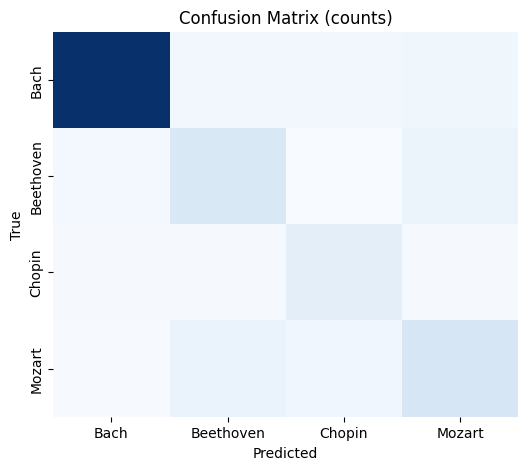

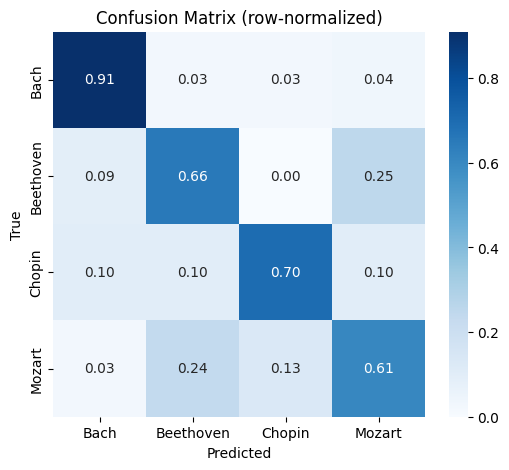

              precision    recall  f1-score   support

        Bach       0.96      0.91      0.93       155
   Beethoven       0.58      0.66      0.62        32
      Chopin       0.61      0.70      0.65        20
      Mozart       0.59      0.61      0.60        38

    accuracy                           0.81       245
   macro avg       0.69      0.72      0.70       245
weighted avg       0.82      0.81      0.82       245

Top-2 accuracy: 0.9306
Ablation: no extra_meta -> loss: 0.8981  acc: 0.7102
Ablation: no chord_freqs -> loss: 0.6523  acc: 0.8041
Ablation: sequence-only (all meta zeroed) -> loss: 1.1503  acc: 0.6000


[1.1502556800842285, 0.6000000238418579]

In [ ]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# === 0) Pack the test Sequence into arrays (one quick pass, no model calls) ===
# Peek one batch to get shapes
# --- pack test_seq into arrays safely ---
xb, yb = test_seq[0]
N = sum(test_seq[idx][1].shape[0] for idx in range(len(test_seq)))  # exact total

X_full = {k: np.empty((N, *np.shape(v)[1:]), dtype=v.dtype) for k, v in xb.items()}
y_true = np.empty((N,), dtype=yb.dtype)

i = 0
for idx in range(len(test_seq)):           # <= key change
    x, y = test_seq[idx]
    b = y.shape[0]
    X_full = {k: (lambda arr, v=x[k]: (arr.__setitem__(slice(i,i+b), v), arr)[1])(arr)
              for k, arr in X_full.items()}
    y_true[i:i+b] = y
    i += b

# sanity
print({k: v.shape for k,v in X_full.items()}, "y_true:", y_true.shape)


# === 1) Predict once on packed arrays ===
probs = model.predict(X_full, batch_size=512, verbose=1)
y_pred = probs.argmax(axis=1)

# Label maps
label_map = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}
idx2lab = {v:k for k,v in label_map.items()}

# === 2) Confusion matrices ===
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(min=1)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=False,
            xticklabels=[idx2lab[i] for i in range(4)],
            yticklabels=[idx2lab[i] for i in range(4)])
plt.title("Confusion Matrix (counts)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=[idx2lab[i] for i in range(4)],
            yticklabels=[idx2lab[i] for i in range(4)])
plt.title("Confusion Matrix (row-normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# === 3) Classification report + Top-2 accuracy ===
print(classification_report(y_true, y_pred, target_names=[idx2lab[i] for i in range(4)]))

top2 = np.argsort(probs, axis=1)[:, -2:]
top2_acc = ((top2[:,0] == y_true) | (top2[:,1] == y_true)).mean()
print(f"Top-2 accuracy: {top2_acc:.4f}")

# === 4) Ablations (zero some inputs and re-evaluate/predict) ===
def evaluate_with_inputs(X_dict, y, batch_size=512, label=""):
    out = model.evaluate(X_dict, y, batch_size=batch_size, verbose=0)
    # model.metrics_names -> ['loss', 'accuracy']
    print(f"{label} -> loss: {out[0]:.4f}  acc: {out[1]:.4f}")
    return out

# a) No extra_meta
X_no_extra = {k: v.copy() for k, v in X_full.items()}
X_no_extra["extra_meta"].fill(0.0)
evaluate_with_inputs(X_no_extra, y_true, label="Ablation: no extra_meta")

# b) No chord_freqs
X_no_chords = {k: v.copy() for k, v in X_full.items()}
X_no_chords["chord_freqs"].fill(0.0)
evaluate_with_inputs(X_no_chords, y_true, label="Ablation: no chord_freqs")

# c) Sequence-only (all meta zeroed)
X_seq_only = {k: v.copy() for k, v in X_full.items()}
for meta_key in ["bpm_mean", "bpm_std", "time_sig", "entropy", "chord_freqs", "extra_meta"]:
    X_seq_only[meta_key].fill(0.0)
evaluate_with_inputs(X_seq_only, y_true, label="Ablation: sequence-only (all meta zeroed)")


In [ ]:
# ============================== #
# Multi-input Sequence + Model   #
# ============================== #
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

train_df = pd.read_pickle('/content/train_features.pkl')
val_df   = pd.read_pickle('/content/val_features.pkl')
test_df  = pd.read_pickle('/content/test_features.pkl')

# ---- constants ----
N_CLASSES = 4
N_NOTES   = 256
BATCH     = 32
TRANSPOSE = 3
JITTER    = 0.10

# pull dims from your DF rows
TS_DIM     = int(train_df['ts_onehot'].iloc[0].shape[0])     # e.g. 48
CHORD_DIM  = int(train_df['chord_freqs'].iloc[0].shape[0])   # e.g. 10
EXTRA_DIM  = 7
label_map  = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}

# ---- compute MU/SIG over meta (bpm_mean, bpm_std, entropy, extra_meta[7]) ----
def row_meta_vec(row):
    base = np.array([row['bpm_mean'], row['bpm_std'], row['entropy']], dtype=np.float32)
    ex   = row['extra_meta'].astype(np.float32)
    if ex.shape[0] < EXTRA_DIM:
        ex = np.pad(ex, (0, EXTRA_DIM-ex.shape[0]))
    else:
        ex = ex[:EXTRA_DIM]
    return np.concatenate([base, ex], axis=0)  # (3 + EXTRA_DIM,)

meta_mat = np.stack([row_meta_vec(r) for _, r in train_df.iterrows()], axis=0)
MU  = meta_mat.mean(axis=0).astype(np.float32)
SIG = meta_mat.std(axis=0).astype(np.float32)
SIG = np.where(SIG==0, 1.0, SIG).astype(np.float32)

# ---- helpers ----
def pad_or_truncate(seq, N=N_NOTES):
    """seq: (L,5) -> (N,5) [pitch,dur,vel,rest,interval]"""
    if seq is None:
        return np.zeros((N,5), dtype=np.float32)
    seq = np.asarray(seq, dtype=np.float32)
    L = seq.shape[0]
    if L >= N:
        return seq[:N].copy()
    out = np.zeros((N,5), dtype=np.float32)
    out[:L] = seq
    return out

def balance_indices(y):
    classes, counts = np.unique(y, return_counts=True)
    m = counts.max()
    idxs = np.concatenate([
        np.random.choice(np.where(y==c)[0], size=m, replace=True) for c in classes
    ])
    np.random.shuffle(idxs)
    return idxs

# ---- Sequence that returns a DICT keyed by input names ----
class BalancedMultiInputSequence(Sequence):
    def __init__(self, df, mu, sig, training=True, batch_size=BATCH, **kwargs):
        super().__init__(**kwargs)          # <- important in Keras 3
        self.df = df.reset_index(drop=True)
        self.mu = mu.astype(np.float32)
        self.sig = sig.astype(np.float32)
        self.training = training
        self.batch_size = batch_size
        self.y_int = self.df['composer'].map(label_map).values.astype(np.int32)
        self.on_epoch_end()

    def __len__(self):
        return (len(self.idxs) + self.batch_size - 1) // self.batch_size

    def on_epoch_end(self):
        self.idxs = balance_indices(self.y_int) if self.training else np.arange(len(self.df))

    def __getitem__(self, i):
        batch_idxs = self.idxs[i*self.batch_size:(i+1)*self.batch_size]
        n = len(batch_idxs)

        pitch = np.zeros((n, N_NOTES),    dtype=np.int32)
        num   = np.zeros((n, N_NOTES, 4), dtype=np.float32)
        bpm_m = np.zeros((n, 1),          dtype=np.float32)
        bpm_s = np.zeros((n, 1),          dtype=np.float32)
        ts    = np.zeros((n, TS_DIM),     dtype=np.float32)
        ent   = np.zeros((n, 1),          dtype=np.float32)
        cf    = np.zeros((n, CHORD_DIM),  dtype=np.float32)
        extra = np.zeros((n, EXTRA_DIM),  dtype=np.float32)
        y     = np.zeros((n,),            dtype=np.int32)

        for j, idx in enumerate(batch_idxs):
            row = self.df.iloc[idx]
            seq = pad_or_truncate(row['features_array'], N_NOTES)  # (N,5)

            if self.training:
                # transpose pitch
                shift = np.random.randint(-TRANSPOSE, TRANSPOSE+1)
                seq[:,0] = np.clip(seq[:,0] + shift, 0, 127)
                # jitter dur & vel
                dj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                vj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                seq[:,1] *= dj
                seq[:,2] = np.clip(seq[:,2]*vj, 0., 1.)

            pitch[j] = seq[:,0].astype(np.int32)
            num[j]   = seq[:,1:5].astype(np.float32)

            # meta -> z-norm
            mvec = row_meta_vec(row)                     # (3+EXTRA_DIM,)
            mz   = (mvec - self.mu) / self.sig
            bpm_m[j,0] = mz[0]; bpm_s[j,0] = mz[1]; ent[j,0] = mz[2]
            extra[j]   = mz[3:3+EXTRA_DIM]

            # onehots/freqs (ensure fixed dims)
            tsv = np.asarray(row['ts_onehot'],   dtype=np.float32)
            cfv = np.asarray(row['chord_freqs'], dtype=np.float32)
            if tsv.shape[0] != TS_DIM:     tsv = np.pad(tsv, (0, TS_DIM - tsv.shape[0]))[:TS_DIM]
            if cfv.shape[0] != CHORD_DIM:  cfv = np.pad(cfv, (0, CHORD_DIM - cfv.shape[0]))[:CHORD_DIM]
            ts[j] = tsv
            cf[j] = cfv

            y[j] = label_map[row['composer']]

        return (
            {
                "pitch_in":    pitch,
                "num_in":      num,
                "bpm_mean":    bpm_m,
                "bpm_std":     bpm_s,
                "time_sig":    ts,
                "entropy":     ent,
                "chord_freqs": cf,
                "extra_meta":  extra,
            },
            y,
        )

# ---- build the multi-input model (names must match dict keys) ----
def build_model(
    n_notes=N_NOTES, ts_dim=TS_DIM, chord_dim=CHORD_DIM, extra_dim=EXTRA_DIM,
    embed_dim=32, lstm1=64, lstm2=32, drop=0.3
):
    pitch_in  = tf.keras.Input(shape=(n_notes,),    dtype=tf.int32,   name="pitch_in")
    num_in    = tf.keras.Input(shape=(n_notes, 4),  dtype=tf.float32, name="num_in")
    bpm_m     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_mean")
    bpm_s     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_std")
    ts_in     = tf.keras.Input(shape=(ts_dim,),     dtype=tf.float32, name="time_sig")
    ent_in    = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="entropy")
    cf_in     = tf.keras.Input(shape=(chord_dim,),  dtype=tf.float32, name="chord_freqs")
    extra_in  = tf.keras.Input(shape=(extra_dim,),  dtype=tf.float32, name="extra_meta")

    emb = tf.keras.layers.Embedding(input_dim=128, output_dim=embed_dim)(pitch_in)
    x   = tf.keras.layers.Concatenate()([emb, num_in])  # (B, n_notes, embed+4)

    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1, return_sequences=True))(x)
    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2, return_sequences=True))(x)

    # light attention (global additive)
    score = tf.keras.layers.Dense(1)(x)                         # (B,T,1)
    attn  = tf.keras.layers.Softmax(axis=1)(score)              # (B,T,1)
    xsum  = tf.keras.layers.Multiply()([x, attn])
    xsum  = tf.keras.layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(xsum)  # (B, 2*lstm2)

    meta = tf.keras.layers.Concatenate()([bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in])
    meta = tf.keras.layers.Dense(64, activation='relu')(meta)

    h = tf.keras.layers.Concatenate()([xsum, meta])
    h = tf.keras.layers.Dense(64, activation='relu')(h)
    h = tf.keras.layers.Dropout(drop)(h)
    out = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(h)

    model = tf.keras.Model(
        inputs=[pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in],
        outputs=out
    )
    return model

model = build_model()


# ============================== #
# Multi-input Sequence + Model   #
# ============================== #
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

train_df = pd.read_pickle('/content/train_features.pkl')
val_df   = pd.read_pickle('/content/val_features.pkl')
test_df  = pd.read_pickle('/content/test_features.pkl')

# ---- constants ----
N_CLASSES = 4
N_NOTES   = 256
BATCH     = 32
TRANSPOSE = 3
JITTER    = 0.10

# pull dims from your DF rows
TS_DIM     = int(train_df['ts_onehot'].iloc[0].shape[0])     # e.g. 48
CHORD_DIM  = int(train_df['chord_freqs'].iloc[0].shape[0])   # e.g. 10
EXTRA_DIM  = 7
label_map  = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}

# ---- compute MU/SIG over meta (bpm_mean, bpm_std, entropy, extra_meta[7]) ----
def row_meta_vec(row):
    base = np.array([row['bpm_mean'], row['bpm_std'], row['entropy']], dtype=np.float32)
    ex   = row['extra_meta'].astype(np.float32)
    if ex.shape[0] < EXTRA_DIM:
        ex = np.pad(ex, (0, EXTRA_DIM-ex.shape[0]))
    else:
        ex = ex[:EXTRA_DIM]
    return np.concatenate([base, ex], axis=0)  # (3 + EXTRA_DIM,)

meta_mat = np.stack([row_meta_vec(r) for _, r in train_df.iterrows()], axis=0)
MU  = meta_mat.mean(axis=0).astype(np.float32)
SIG = meta_mat.std(axis=0).astype(np.float32)
SIG = np.where(SIG==0, 1.0, SIG).astype(np.float32)

# ---- helpers ----
def pad_or_truncate(seq, N=N_NOTES):
    """seq: (L,5) -> (N,5) [pitch,dur,vel,rest,interval]"""
    if seq is None:
        return np.zeros((N,5), dtype=np.float32)
    seq = np.asarray(seq, dtype=np.float32)
    L = seq.shape[0]
    if L >= N:
        return seq[:N].copy()
    out = np.zeros((N,5), dtype=np.float32)
    out[:L] = seq
    return out

def balance_indices(y):
    classes, counts = np.unique(y, return_counts=True)
    m = counts.max()
    idxs = np.concatenate([
        np.random.choice(np.where(y==c)[0], size=m, replace=True) for c in classes
    ])
    np.random.shuffle(idxs)
    return idxs

# ---- Sequence that returns a DICT keyed by input names ----
class BalancedMultiInputSequence(Sequence):
    def __init__(self, df, mu, sig, training=True, batch_size=BATCH, **kwargs):
        super().__init__(**kwargs)          # <- important in Keras 3
        self.df = df.reset_index(drop=True)
        self.mu = mu.astype(np.float32)
        self.sig = sig.astype(np.float32)
        self.training = training
        self.batch_size = batch_size
        self.y_int = self.df['composer'].map(label_map).values.astype(np.int32)
        self.on_epoch_end()

    def __len__(self):
        return (len(self.idxs) + self.batch_size - 1) // self.batch_size

    def on_epoch_end(self):
        self.idxs = balance_indices(self.y_int) if self.training else np.arange(len(self.df))

    def __getitem__(self, i):
        batch_idxs = self.idxs[i*self.batch_size:(i+1)*self.batch_size]
        n = len(batch_idxs)

        pitch = np.zeros((n, N_NOTES),    dtype=np.int32)
        num   = np.zeros((n, N_NOTES, 4), dtype=np.float32)
        bpm_m = np.zeros((n, 1),          dtype=np.float32)
        bpm_s = np.zeros((n, 1),          dtype=np.float32)
        ts    = np.zeros((n, TS_DIM),     dtype=np.float32)
        ent   = np.zeros((n, 1),          dtype=np.float32)
        cf    = np.zeros((n, CHORD_DIM),  dtype=np.float32)
        extra = np.zeros((n, EXTRA_DIM),  dtype=np.float32)
        y     = np.zeros((n,),            dtype=np.int32)

        for j, idx in enumerate(batch_idxs):
            row = self.df.iloc[idx]
            seq = pad_or_truncate(row['features_array'], N_NOTES)  # (N,5)

            if self.training:
                # transpose pitch
                shift = np.random.randint(-TRANSPOSE, TRANSPOSE+1)
                seq[:,0] = np.clip(seq[:,0] + shift, 0, 127)
                # jitter dur & vel
                dj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                vj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                seq[:,1] *= dj
                seq[:,2] = np.clip(seq[:,2]*vj, 0., 1.)

            pitch[j] = seq[:,0].astype(np.int32)
            num[j]   = seq[:,1:5].astype(np.float32)

            # meta -> z-norm
            mvec = row_meta_vec(row)                     # (3+EXTRA_DIM,)
            mz   = (mvec - self.mu) / self.sig
            bpm_m[j,0] = mz[0]; bpm_s[j,0] = mz[1]; ent[j,0] = mz[2]
            extra[j]   = mz[3:3+EXTRA_DIM]

            # onehots/freqs (ensure fixed dims)
            tsv = np.asarray(row['ts_onehot'],   dtype=np.float32)
            cfv = np.asarray(row['chord_freqs'], dtype=np.float32)
            if tsv.shape[0] != TS_DIM:     tsv = np.pad(tsv, (0, TS_DIM - tsv.shape[0]))[:TS_DIM]
            if cfv.shape[0] != CHORD_DIM:  cfv = np.pad(cfv, (0, CHORD_DIM - cfv.shape[0]))[:CHORD_DIM]
            ts[j] = tsv
            cf[j] = cfv

            y[j] = label_map[row['composer']]

        return (
            {
                "pitch_in":    pitch,
                "num_in":      num,
                "bpm_mean":    bpm_m,
                "bpm_std":     bpm_s,
                "time_sig":    ts,
                "entropy":     ent,
                "chord_freqs": cf,
                "extra_meta":  extra,
            },
            y,
        )

# ---- build the multi-input model (names must match dict keys) ----
def build_model(
    n_notes=N_NOTES, ts_dim=TS_DIM, chord_dim=CHORD_DIM, extra_dim=EXTRA_DIM,
    embed_dim=32, lstm1=64, lstm2=32, drop=0.3
):
    pitch_in  = tf.keras.Input(shape=(n_notes,),    dtype=tf.int32,   name="pitch_in")
    num_in    = tf.keras.Input(shape=(n_notes, 4),  dtype=tf.float32, name="num_in")
    bpm_m     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_mean")
    bpm_s     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_std")
    ts_in     = tf.keras.Input(shape=(ts_dim,),     dtype=tf.float32, name="time_sig")
    ent_in    = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="entropy")
    cf_in     = tf.keras.Input(shape=(chord_dim,),  dtype=tf.float32, name="chord_freqs")
    extra_in  = tf.keras.Input(shape=(extra_dim,),  dtype=tf.float32, name="extra_meta")

    emb = tf.keras.layers.Embedding(input_dim=128, output_dim=embed_dim)(pitch_in)
    x   = tf.keras.layers.Concatenate()([emb, num_in])  # (B, n_notes, embed+4)

    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1, return_sequences=True))(x)
    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2, return_sequences=True))(x)

    # light attention (global additive)
    score = tf.keras.layers.Dense(1)(x)                         # (B,T,1)
    attn  = tf.keras.layers.Softmax(axis=1)(score)              # (B,T,1)
    xsum  = tf.keras.layers.Multiply()([x, attn])
    xsum  = tf.keras.layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(xsum)  # (B, 2*lstm2)

    meta = tf.keras.layers.Concatenate()([bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in])
    meta = tf.keras.layers.Dense(64, activation='relu')(meta)

    h = tf.keras.layers.Concatenate()([xsum, meta])
    h = tf.keras.layers.Dense(64, activation='relu')(h)
    h = tf.keras.layers.Dropout(drop)(h)
    out = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(h)

    model = tf.keras.Model(
        inputs=[pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in],
        outputs=out
    )
    return model

model = build_model()
# label smoothing for sparse targets
# 1) Per-class α from training distribution (inverse-frequency, mean=1.0)
label_map = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}
y_train_int = train_df['composer'].map(label_map).values
counts = np.array([np.sum(y_train_int==i) for i in range(4)], dtype=np.float32)

inv = 1.0 / counts
alpha = (inv / inv.sum()) * len(counts)            # normalized so avg α = 1
alpha = alpha.astype('float32')
print("class counts:", counts, " alpha:", alpha)

# 2) Focal loss (with label smoothing)
def focal_loss_with_label_smoothing(num_classes=4, gamma=2.0, alpha_vec=None, label_smooth=0.05):
    cce = tf.keras.losses.CategoricalCrossentropy(reduction='none', label_smoothing=label_smooth)
    alpha_vec = tf.constant(alpha_vec if alpha_vec is not None else np.ones(num_classes, dtype=np.float32))

    def loss_fn(y_true, y_pred):
        # sparse ints -> one-hot
        y_true = tf.one_hot(tf.cast(tf.squeeze(y_true), tf.int32), depth=num_classes)
        # clip to keep logs sane
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        ce   = cce(y_true, y_pred)                     # [B]
        p_t  = tf.reduce_sum(y_true * y_pred, -1)      # [B]
        focal = tf.pow(1.0 - p_t, gamma)               # [B]
        cls   = tf.argmax(y_true, -1)                  # [B]
        a     = tf.gather(alpha_vec, cls)              # [B]
        return tf.reduce_mean(a * focal * ce)
    return loss_fn

loss_fn = focal_loss_with_label_smoothing(
    num_classes=4, gamma=2.0, alpha_vec=alpha, label_smooth=0.05
)

# 3) Compile (no class_weight since we’re handling balance in the loss)
model.compile(optimizer=tf.keras.optimizers.Adam(4e-4),
              loss=loss_fn,
              metrics=['accuracy'],
              run_eagerly=True)

# ---- build sequences (NO steps_per_epoch/workers/use_multiprocessing) ----
train_seq = BalancedMultiInputSequence(train_df, MU, SIG, training=True,  batch_size=BATCH)
val_seq   = BalancedMultiInputSequence(val_df,   MU, SIG, training=False, batch_size=BATCH)
test_seq  = BalancedMultiInputSequence(test_df,  MU, SIG, training=False, batch_size=BATCH)

# quick sanity check
x0, y0 = train_seq[0]
for k,v in x0.items():
    print(k, v.shape, v.dtype)
print("y batch:", y0.shape, y0.dtype)

# ---- train ----
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=60,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.5),
        tf.keras.callbacks.EarlyStopping('val_loss', patience=6, restore_best_weights=True),
    ],
    verbose=1
)

# ---- evaluate ----
test_loss, test_acc = model.evaluate(test_seq, verbose=0)
print(f"Test acc: {test_acc:.4f}")


class counts: [716. 148.  95. 180.]  alpha: [0.23051488 1.1151937  1.7373544  0.91693705]
pitch_in (32, 256) int32
num_in (32, 256, 4) float32
bpm_mean (32, 1) float32
bpm_std (32, 1) float32
time_sig (32, 48) float32
entropy (32, 1) float32
chord_freqs (32, 10) float32
extra_meta (32, 7) float32
y batch: (32,) int32
Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.3300 - loss: 0.6221 - val_accuracy: 0.3197 - val_loss: 0.4159 - learning_rate: 4.0000e-04
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.5318 - loss: 0.4493 - val_accuracy: 0.5164 - val_loss: 0.3340 - learning_rate: 4.0000e-04
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.6038 - loss: 0.3731 - val_accuracy: 0.6107 - val_loss: 0.2818 - learning_rate: 4.0000e-04
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.6935 - loss: 0.3087 - val_accuracy: 0.6270 - val_loss: 0.2741 - learning_rate: 4.0000e-04
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step 

In [ ]:
# ============================== #
# Multi-input Sequence + Model   #
# ============================== #
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

train_df = pd.read_pickle('/content/train_features.pkl')
val_df   = pd.read_pickle('/content/val_features.pkl')
test_df  = pd.read_pickle('/content/test_features.pkl')

# ---- constants ----
N_CLASSES = 4
N_NOTES   = 256
BATCH     = 32
TRANSPOSE = 3
JITTER    = 0.10

# pull dims from your DF rows
TS_DIM     = int(train_df['ts_onehot'].iloc[0].shape[0])     # e.g. 48
CHORD_DIM  = int(train_df['chord_freqs'].iloc[0].shape[0])   # e.g. 10
EXTRA_DIM  = 7
label_map  = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}

# ---- compute MU/SIG over meta (bpm_mean, bpm_std, entropy, extra_meta[7]) ----
def row_meta_vec(row):
    base = np.array([row['bpm_mean'], row['bpm_std'], row['entropy']], dtype=np.float32)
    ex   = row['extra_meta'].astype(np.float32)
    if ex.shape[0] < EXTRA_DIM:
        ex = np.pad(ex, (0, EXTRA_DIM-ex.shape[0]))
    else:
        ex = ex[:EXTRA_DIM]
    return np.concatenate([base, ex], axis=0)  # (3 + EXTRA_DIM,)

meta_mat = np.stack([row_meta_vec(r) for _, r in train_df.iterrows()], axis=0)
MU  = meta_mat.mean(axis=0).astype(np.float32)
SIG = meta_mat.std(axis=0).astype(np.float32)
SIG = np.where(SIG==0, 1.0, SIG).astype(np.float32)

# ---- helpers ----
def pad_or_truncate(seq, N=N_NOTES):
    """seq: (L,5) -> (N,5) [pitch,dur,vel,rest,interval]"""
    if seq is None:
        return np.zeros((N,5), dtype=np.float32)
    seq = np.asarray(seq, dtype=np.float32)
    L = seq.shape[0]
    if L >= N:
        return seq[:N].copy()
    out = np.zeros((N,5), dtype=np.float32)
    out[:L] = seq
    return out

def balance_indices(y):
    classes, counts = np.unique(y, return_counts=True)
    m = counts.max()
    idxs = np.concatenate([
        np.random.choice(np.where(y==c)[0], size=m, replace=True) for c in classes
    ])
    np.random.shuffle(idxs)
    return idxs

# ---- Sequence that returns a DICT keyed by input names ----
class BalancedMultiInputSequence(Sequence):
    def __init__(self, df, mu, sig, training=True, batch_size=BATCH, **kwargs):
        super().__init__(**kwargs)          # <- important in Keras 3
        self.df = df.reset_index(drop=True)
        self.mu = mu.astype(np.float32)
        self.sig = sig.astype(np.float32)
        self.training = training
        self.batch_size = batch_size
        self.y_int = self.df['composer'].map(label_map).values.astype(np.int32)
        self.on_epoch_end()

    def __len__(self):
        return (len(self.idxs) + self.batch_size - 1) // self.batch_size

    def on_epoch_end(self):
        self.idxs = balance_indices(self.y_int) if self.training else np.arange(len(self.df))

    def __getitem__(self, i):
        batch_idxs = self.idxs[i*self.batch_size:(i+1)*self.batch_size]
        n = len(batch_idxs)

        pitch = np.zeros((n, N_NOTES),    dtype=np.int32)
        num   = np.zeros((n, N_NOTES, 4), dtype=np.float32)
        bpm_m = np.zeros((n, 1),          dtype=np.float32)
        bpm_s = np.zeros((n, 1),          dtype=np.float32)
        ts    = np.zeros((n, TS_DIM),     dtype=np.float32)
        ent   = np.zeros((n, 1),          dtype=np.float32)
        cf    = np.zeros((n, CHORD_DIM),  dtype=np.float32)
        extra = np.zeros((n, EXTRA_DIM),  dtype=np.float32)
        y     = np.zeros((n,),            dtype=np.int32)

        for j, idx in enumerate(batch_idxs):
            row = self.df.iloc[idx]
            seq = pad_or_truncate(row['features_array'], N_NOTES)  # (N,5)

            if self.training:
                # transpose pitch
                shift = np.random.randint(-TRANSPOSE, TRANSPOSE+1)
                seq[:,0] = np.clip(seq[:,0] + shift, 0, 127)
                # jitter dur & vel
                dj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                vj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                seq[:,1] *= dj
                seq[:,2] = np.clip(seq[:,2]*vj, 0., 1.)

            pitch[j] = seq[:,0].astype(np.int32)
            num[j]   = seq[:,1:5].astype(np.float32)

            # meta -> z-norm
            mvec = row_meta_vec(row)                     # (3+EXTRA_DIM,)
            mz   = (mvec - self.mu) / self.sig
            bpm_m[j,0] = mz[0]; bpm_s[j,0] = mz[1]; ent[j,0] = mz[2]
            extra[j]   = mz[3:3+EXTRA_DIM]

            # onehots/freqs (ensure fixed dims)
            tsv = np.asarray(row['ts_onehot'],   dtype=np.float32)
            cfv = np.asarray(row['chord_freqs'], dtype=np.float32)
            if tsv.shape[0] != TS_DIM:     tsv = np.pad(tsv, (0, TS_DIM - tsv.shape[0]))[:TS_DIM]
            if cfv.shape[0] != CHORD_DIM:  cfv = np.pad(cfv, (0, CHORD_DIM - cfv.shape[0]))[:CHORD_DIM]
            ts[j] = tsv
            cf[j] = cfv

            y[j] = label_map[row['composer']]

        return (
            {
                "pitch_in":    pitch,
                "num_in":      num,
                "bpm_mean":    bpm_m,
                "bpm_std":     bpm_s,
                "time_sig":    ts,
                "entropy":     ent,
                "chord_freqs": cf,
                "extra_meta":  extra,
            },
            y,
        )

# ---- build the multi-input model (names must match dict keys) ----
def build_model(
    n_notes=N_NOTES, ts_dim=TS_DIM, chord_dim=CHORD_DIM, extra_dim=EXTRA_DIM,
    embed_dim=32, lstm1=64, lstm2=32, drop=0.3
):
    pitch_in  = tf.keras.Input(shape=(n_notes,),    dtype=tf.int32,   name="pitch_in")
    num_in    = tf.keras.Input(shape=(n_notes, 4),  dtype=tf.float32, name="num_in")
    bpm_m     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_mean")
    bpm_s     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_std")
    ts_in     = tf.keras.Input(shape=(ts_dim,),     dtype=tf.float32, name="time_sig")
    ent_in    = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="entropy")
    cf_in     = tf.keras.Input(shape=(chord_dim,),  dtype=tf.float32, name="chord_freqs")
    extra_in  = tf.keras.Input(shape=(extra_dim,),  dtype=tf.float32, name="extra_meta")

    emb = tf.keras.layers.Embedding(input_dim=128, output_dim=embed_dim)(pitch_in)
    x   = tf.keras.layers.Concatenate()([emb, num_in])  # (B, n_notes, embed+4)

    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1, return_sequences=True))(x)
    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2, return_sequences=True))(x)

    # light attention (global additive)
    score = tf.keras.layers.Dense(1)(x)                         # (B,T,1)
    attn  = tf.keras.layers.Softmax(axis=1)(score)              # (B,T,1)
    xsum  = tf.keras.layers.Multiply()([x, attn])
    xsum  = tf.keras.layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(xsum)  # (B, 2*lstm2)

    meta = tf.keras.layers.Concatenate()([bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in])
    meta = tf.keras.layers.Dense(64, activation='relu')(meta)

    h = tf.keras.layers.Concatenate()([xsum, meta])
    h = tf.keras.layers.Dense(64, activation='relu')(h)
    h = tf.keras.layers.Dropout(drop)(h)
    out = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(h)

    model = tf.keras.Model(
        inputs=[pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in],
        outputs=out
    )
    return model

model = build_model()
# label smoothing for sparse targets
cce = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.07)
def smoothed_sparse_cce(y_true, y_pred):
    y_true = tf.cast(tf.squeeze(y_true), tf.int32)
    y_oh   = tf.one_hot(y_true, depth=N_CLASSES)
    return cce(y_oh, y_pred)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4, weight_decay=1e-5),
              loss=smoothed_sparse_cce,
              metrics=['accuracy'],
              run_eagerly=True)
model.summary()

# ---- build sequences (NO steps_per_epoch/workers/use_multiprocessing) ----
train_seq = BalancedMultiInputSequence(train_df, MU, SIG, training=True,  batch_size=BATCH)
val_seq   = BalancedMultiInputSequence(val_df,   MU, SIG, training=False, batch_size=BATCH)
test_seq  = BalancedMultiInputSequence(test_df,  MU, SIG, training=False, batch_size=BATCH)

# quick sanity check
x0, y0 = train_seq[0]
for k,v in x0.items():
    print(k, v.shape, v.dtype)
print("y batch:", y0.shape, y0.dtype)

# ---- train ----
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=60,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau('val_accuracy', patience=3, factor=0.5),
        tf.keras.callbacks.EarlyStopping('val_accuracy', patience=6, restore_best_weights=True),
    ],
    verbose=1
)

# ---- evaluate ----
test_loss, test_acc = model.evaluate(test_seq, verbose=0)
print(f"Test acc: {test_acc:.4f}")


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 256, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 256, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 256, 36)   │          0 │ embedding_11[0][… │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_22    │ (None, 256, 128)  │     51,712 │ concatenate_33[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_23    │ (None, 256, 64)   │     41,216 │ bidirectional_22… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 256, 1)    │         65 │ bidirectional_23… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_11          │ (None, 256, 1)    │          0 │ dense_44[0][0]    │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_mean            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_std             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_sig            │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chord_freqs         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_meta          │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_11         │ (None, 256, 64)   │          0 │ bidirectional_23… │
│ (Multiply)          │                   │            │ softmax_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_34      │ (None, 68)        │          0 │ bpm_mean[0][0],   │
│ (Concatenate)       │                   │            │ bpm_std[0][0],    │
│                     │                   │            │ time_sig[0][0],   │
│                     │                   │            │ entropy[0][0],    │
│                     │                   │            │ chord_freqs[0][0… │
│                     │                   │            │ extra_meta[0][0]

 Total params: 110,021 (429.77 KB)

 Trainable params: 110,021 (429.77 KB)

 Non-trainable params: 0 (0.00 B)

pitch_in (32, 256) int32
num_in (32, 256, 4) float32
bpm_mean (32, 1) float32
bpm_std (32, 1) float32
time_sig (32, 48) float32
entropy (32, 1) float32
chord_freqs (32, 10) float32
extra_meta (32, 7) float32
y batch: (32,) int32
Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 240ms/step - accuracy: 0.3620 - loss: 1.3227 - val_accuracy: 0.6393 - val_loss: 1.0140 - learning_rate: 4.0000e-04
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.5993 - loss: 1.0569 - val_accuracy: 0.7049 - val_loss: 0.8429 - learning_rate: 4.0000e-04
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 0.6765 - loss: 0.9137 - val_accuracy: 0.7131 - val_loss: 0.8137 - learning_rate: 4.0000e-04
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.7105 - loss: 0.8242 - val_accuracy: 0.7910 - val_loss: 0.7156 - learning_rate: 4.0000e-04
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.7430 - loss: 0.7629 - val_accuracy: 0.7869 - val_loss: 0.6994 - learning_rat